# Generative Models

## GANs & VAE

### HW4

**Full Name:** Amirhossein Akbari

**SID:** 400104737

In this notebook, we are going to implement Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN) on the MNIST dataset. VAEs learn a latent variable model from input data. They sample from this distribution and decode it to generate new data. GANs uses a generator to make images based on a prior distribution.


+ Complete the `TODO` parts in the code accordingly.

In [1]:
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

We will be using MNIST dataset which consists of 60000 data. We split them into train and validation sets, each having 50000 and 10000 data respectively.

In [2]:
transformation = transforms.Compose([
        transforms.ToTensor(),
    ])

In [3]:
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

train_data, valid_data = random_split(mnist_data, [50000, 10000])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 32970298.49it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1009438.88it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 7951146.58it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2605378.66it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
num_threads = 4
batch_size = 128


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)
val_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)

# VAE

Variational Autoencoders (VAEs) are a class of generative models that aim to learn the probability distribution of a given dataset in order to generate new data points that resemble the original data. They use and encoder that embeds each data to a smaller latent space and a decoder that tries to generate the original image, given this latent space.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png)
---


In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        ##########################################################
        # TODO
        # Define your variational encoder layers.
        ##########################################################
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1) # (28 - 3 + 2) / 2 + 1 = 14 **** out: 16 * 14 * 14
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1) # (14 - 3 + 2) / 2 + 1 = 7 **** out: 32 * 7 * 7
        self.fc1 = nn.Linear(32 * 7 * 7, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):

        ##########################################################
        # TODO
        # Convert input `x` to mean and log variance of latent
        # space which is then used to sample data for the decoder.
        ##########################################################
        z = F.relu(self.conv1(x))
        z = F.relu(self.conv2(z))
        z = torch.flatten(z, start_dim=1)
        z = F.relu(self.fc1(z))
        z_mean = self.fc_mu(z)
        z_log_var = self.fc_log_var(z)
        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        ##############################
        # TODO
        # Define your decoder layers.
        ##############################
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 32 * 7 * 7)
        self.conv_trans1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1) # out: 16 * 14 * 14
        self.conv_trans2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)  # out: 1 * 28 * 28

    def forward(self, z):
        ########################################
        # TODO
        # Decode the latent vector `z` to images.
        ########################################
        x = F.relu(self.fc2(z))
        x = F.relu(self.fc3(x))
        x = x.view(-1, 32, 7, 7)
        x = F.relu(self.conv_trans1(x))
        x = torch.sigmoid(self.conv_trans2(x))
        return x

In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, 32 * 7 * 7)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

model_vae = VAE()
if torch.cuda.is_available():
    model_vae.cuda()

In [7]:
def loss_function(recon_y, x, mu, log_var):
    recon_y = recon_y.view(-1, 784)
    x = x.view(-1, 784) 
    BCE = F.binary_cross_entropy(recon_y, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD, BCE, KLD

In [8]:
def reconstruct_images(model, images):
    with torch.no_grad():
        recon_images, _, _ = model(images)
    return recon_images.view(-1, 1, 28, 28)

def plot_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 2))
    for idx, img in enumerate(images):
        axes[idx].imshow(img.squeeze(), cmap='gray')
        axes[idx].axis('off')
    plt.show()

In [9]:
def train_vae(dataloader, latent_dim, hidden_dim, input_dim, learning_rate=1e-4, num_epochs=20):
    ###############################################
    # TODO
    # Define the loss fc, optimizer and VAE model.
    ###############################################
    model_vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
#     criterion = # TODO
    optimizer = torch.optim.Adam(model_vae.parameters(), lr = 0.002)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, 
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001, verbose=True)

    count = 0
    for epoch in range(num_epochs):
        model_vae.train()
        train_loss = 0
#         with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (data, _) in enumerate(dataloader):

            ###############################################
            # TODO
            # Calculate the loss.
            # (optional) Use the KL divergence loss to normalize the
            # output distribution of decoder.
            ###############################################
            count += 1
            bsize = data.shape[0]

            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, log_var = model_vae(data)
            loss, bce, kld = loss_function(recon_batch, data, mu, log_var)
            n_wu.append(count)
            err_l.append(bce.item()/bsize)
            kld_l.append(kld.item()/bsize)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
#             print(f"Epoch {epoch+1} Loss: {loss.item()/len(data):.4f}")
    
        scheduler.step(train_loss / len(train_loader.dataset))
        print(f'====> Epoch: {epoch+1} Average loss: {train_loss / len(dataloader.dataset):.4f}')
        
        model_vae.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                recon, mu, log_var = model_vae(data)
                loss, _, _ = loss_function(recon, data, mu, log_var)
                test_loss += loss.item()
        
        test_loss /= len(val_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
        
        if epoch % 4 == 0:
            sample_images, _ = next(iter(val_loader))
            sample_images = sample_images.to('cuda')

            recon, mu, std = model_vae(sample_images[:1])
            b = recon.squeeze().detach().cpu().numpy()

            f, axarr = plt.subplots(1, 2)
            axarr[0].imshow(sample_images[0].squeeze().detach().cpu().numpy(), cmap='gray')
            axarr[1].imshow(b, cmap='gray') 
            plt.show()
        
    return model_vae

====> Epoch: 1 Average loss: 184.3644
====> Test set loss: 140.9323


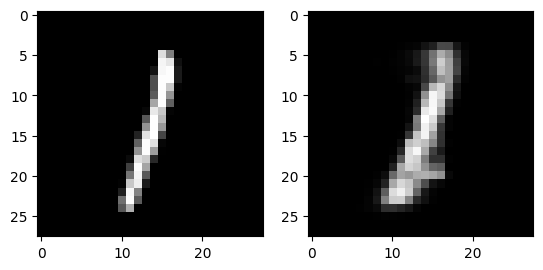

====> Epoch: 2 Average loss: 127.2697
====> Test set loss: 119.0666
====> Epoch: 3 Average loss: 114.8073
====> Test set loss: 112.0937
====> Epoch: 4 Average loss: 110.1859
====> Test set loss: 110.0176
====> Epoch: 5 Average loss: 108.1570
====> Test set loss: 107.5015


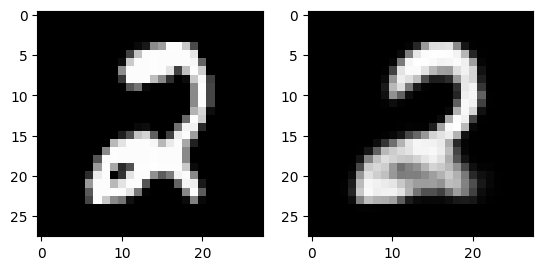

====> Epoch: 6 Average loss: 106.8547
====> Test set loss: 106.8383
Epoch 00007: reducing learning rate of group 0 to 1.0000e-03.
====> Epoch: 7 Average loss: 105.9747
====> Test set loss: 106.4357
====> Epoch: 8 Average loss: 104.3499
====> Test set loss: 104.5028
====> Epoch: 9 Average loss: 103.9961
====> Test set loss: 104.5347


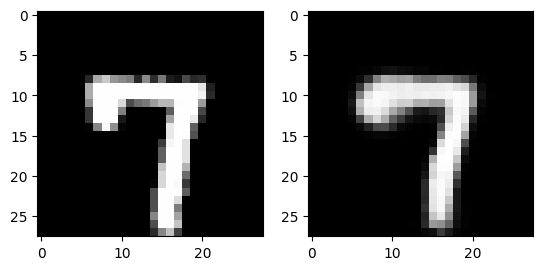

====> Epoch: 10 Average loss: 103.7039
====> Test set loss: 104.1255
====> Epoch: 11 Average loss: 103.4101
====> Test set loss: 103.7445
====> Epoch: 12 Average loss: 103.2162
====> Test set loss: 103.5342
Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.
====> Epoch: 13 Average loss: 102.9662
====> Test set loss: 103.7122


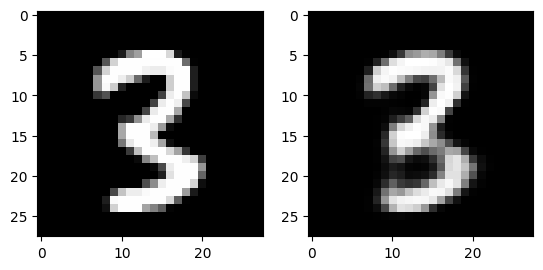

====> Epoch: 14 Average loss: 102.2349
====> Test set loss: 102.7612
====> Epoch: 15 Average loss: 102.0977
====> Test set loss: 102.7426
====> Epoch: 16 Average loss: 101.9406
====> Test set loss: 102.6715
====> Epoch: 17 Average loss: 101.8724
====> Test set loss: 102.6319


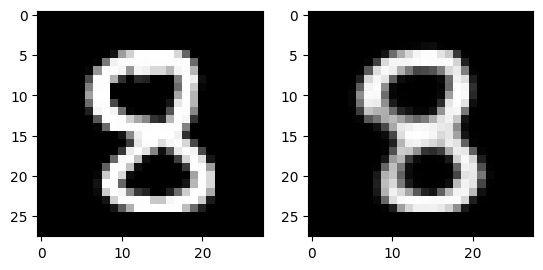

====> Epoch: 18 Average loss: 101.7381
====> Test set loss: 102.4217
Epoch 00019: reducing learning rate of group 0 to 2.5000e-04.
====> Epoch: 19 Average loss: 101.6283
====> Test set loss: 102.3966
====> Epoch: 20 Average loss: 101.2979
====> Test set loss: 101.9831


In [10]:
err_l, kld_l, n_wu= [], [], []
model_vae = train_vae(train_loader, 20, 128, 784, learning_rate=1e-4, num_epochs=20)

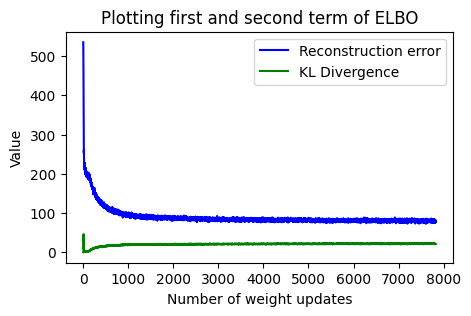

In [11]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, err_l, 'b', label='Reconstruction error')
plt.plot(n_wu, kld_l, 'g', label='KL Divergence')
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()
    

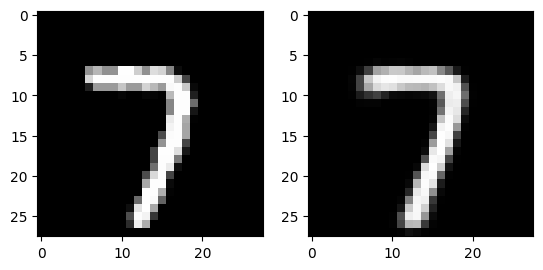

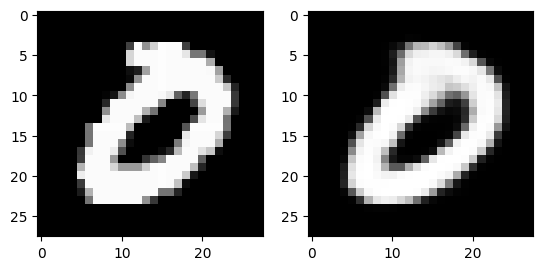

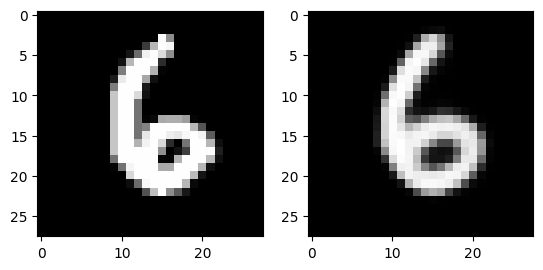

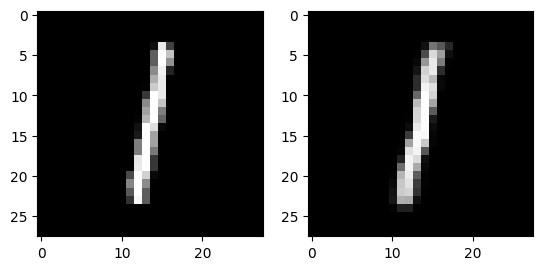

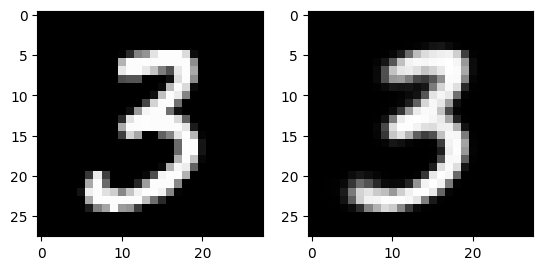

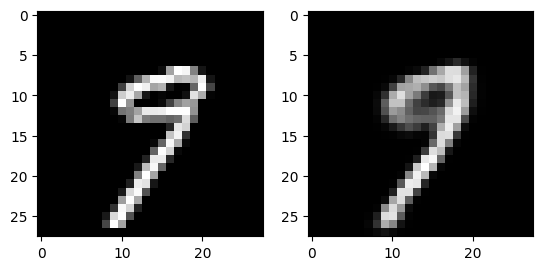

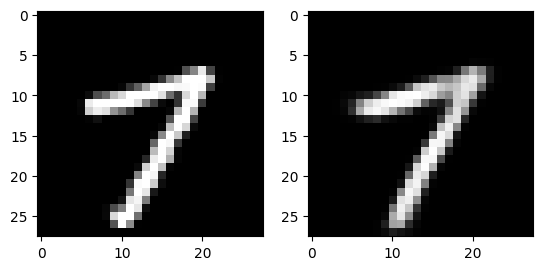

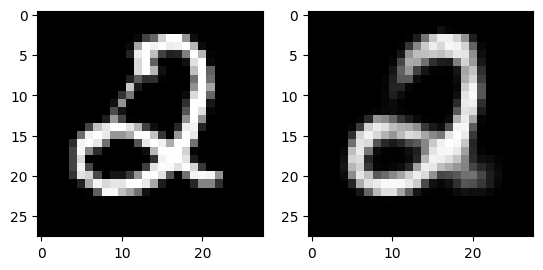

In [12]:
import matplotlib.pyplot as plt

model_vae.eval()
for i in range(8):
    a, t = next(iter(train_loader))
    a = a.to('cuda') 

    recon, mu, std = model_vae(a[:1])
    

    b = recon.squeeze().detach().cpu().numpy()

    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(a[0].squeeze().detach().cpu().numpy(), cmap='gray') 
    axarr[1].imshow(b, cmap='gray') 
    plt.show()


# GAN

GANs consist of two models: a generator and a discriminator. The generator creates new data points, and the discriminator evaluates them, trying to distinguish between real and generated (fake) data points. The training process involves updating the generator to produce more realistic data, as judged by the discriminator, and simultaneously updating the discriminator to get better at distinguishing real from fake. This adversarial process leads to improvements in both models, with the generator producing highly realistic data points as a result.

In [15]:
# class Generator(nn.Module):
#     def __init__(self, batch_size=128, img_size=28):
#         super(Generator, self).__init__()

#         #######################
#         # TODO
#         # Define your generator
#         #######################

#         self.hidden0 = nn.Sequential(
#             nn.Linear(batch_size, 256),
#             nn.LeakyReLU(0.2),
#         )
#         self.hidden1 = nn.Sequential(
#             nn.Linear(256, 512),
#             nn.LeakyReLU(0.2),
#         )
#         self.hidden2 = nn.Sequential(
#             nn.Linear(512, 1024),
#             nn.LeakyReLU(0.2),
#         )
#         self.out = nn.Sequential(
#             nn.Linear(1024, img_size * img_size),
#             nn.Tanh(),
#         )

#     def forward(self, z):
#         ##############################################
#         # TODO
#         # generate an image using `z` vector, sampled
#         # from a prior distribution.
#         # Reshape the result to the shape of original images
#         ##############################################
#         x = self.hidden0(z)
#         x = self.hidden1(x)
#         x = self.hidden2(x)
#         x = self.out(x)
#         return x

# class Discriminator(nn.Module):
#     def __init__(self,  n_out=1, img_size=28):
#         super(Discriminator, self).__init__()

#         ###########################
#         # TODO
#         # Define your discriminator
#         ###########################

#         self.hidden0 = nn.Sequential(
#             nn.Linear(img_size * img_size, 1024),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.3),
#         )
#         self.hidden1 = nn.Sequential(
#             nn.Linear(1024, 512),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.3),
#         )
#         self.hidden2 = nn.Sequential(
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.3),
#         )
#         self.out = nn.Sequential(
#             nn.Linear(256, n_out),
#             nn.Sigmoid()
#         )

#     def forward(self, img):
#         ##############################################
#         # TODO
#         # Predict whether each image in `img` is real or fake.
#         ##############################################
#         x = self.hidden0(img)
#         x = self.hidden1(x)
#         x = self.hidden2(x)
#         x = self.out(x)
#         return x

In [16]:
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=1):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(nz, ngf * 4 * 7 * 7),
            nn.ReLU(True),
            nn.BatchNorm1d(ngf * 4 * 7 * 7),
            nn.Unflatten(1, (ngf * 4, 7, 7)),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, stride=2, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(ngf * 2),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, stride=2, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(ngf),

            nn.ConvTranspose2d(ngf, nc, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [17]:
class Discriminator(nn.Module):
    def __init__(self, ndf=64, nc=1):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3),

            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf * 2),
            nn.Dropout2d(0.3),

            nn.Conv2d(ndf * 2, ndf * 4, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf * 4),
            nn.Dropout2d(0.3),

            nn.Flatten(),
            nn.Linear(ndf * 4 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)


In [18]:
def real_data_target(size):
    data = Variable(torch.ones(size, 1)).to(device)
    return data

def fake_data_target(size):
    data = Variable(torch.zeros(size, 1)).to(device)
    return data

def imgs_to_vec(imgs, img_size=28):
    return imgs.view(imgs.size(0), img_size * img_size)

def vec_to_imgs(vec):
    return vec.view(vec.size(0), 1, 28, 28)

def noise(size=128, nz=100):
    n = torch.randn(size, nz)
    return n

In [19]:
log_data = []

def log(e, E, b, B, de, ge):
    row = {
        'epoch': e, 'epochs': E,
        'batch': b, 'batches': B,
        'derror': de, 'gerror': ge,
    }

def display_logs(e, E, b, B, de, ge, dr, df, batch_size=128):
    print(f"Epoch {e+1}/{E} ({(e/E)*100:.1f}%):"
          f" [{b*batch_size}/{B*batch_size}] ({(b/B)*100:.1f}%)"
          f" D Error: {de:.4f} G Error: {ge:.4f}") 

In [20]:
def display_images(imgs):
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8,8))
    count = 0
    for y in range(4):
        for x in range(4):
            img = imgs[count].view(28, 28)
            axs[y][x].axis('off')
            axs[y][x].imshow(img, cmap="gray")
            count += 1
    plt.show()

In [21]:
def train_discriminator(dmodel, optimizer, loss_func, real_data, fake_data):
    optimizer.zero_grad()
    pred_real = dmodel(real_data)
    error_real = loss_func(pred_real, real_data_target(real_data.size(0)))
    error_real.backward()
    pred_fake = dmodel(fake_data)
    error_fake = loss_func(pred_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    optimizer.step()
    return error_real + error_fake, pred_real, pred_fake

In [22]:
def train_generator(dmodel, optimizer, loss_func, fake_data):
    optimizer.zero_grad()
    pred = dmodel(fake_data)
    error = loss_func(pred, real_data_target(pred.size(0)))
    error.backward()
    optimizer.step()
    return error

In [23]:
NUM_BATCHES = len(train_loader)
DISPLAY_EVERY = 1000

num_samples = 16
test_noise = noise(num_samples).to(device)
test_noise

tensor([[-0.4225,  2.0709,  0.3689,  ..., -1.3660,  0.9015, -1.7198],
        [-0.9830, -0.0518,  0.3599,  ...,  1.1598, -0.7406, -1.4238],
        [-0.6509, -1.2540, -1.4799,  ...,  1.0588,  0.1067,  0.3719],
        ...,
        [ 0.4620, -0.8131,  0.0344,  ...,  0.2455,  0.0445, -1.8528],
        [-0.6490,  0.2237, -0.9072,  ...,  0.0652,  0.6938,  1.0405],
        [-0.5608, -0.0134, -0.8750,  ..., -0.4098,  1.0022, -0.0941]],
       device='cuda:0')

In [24]:
def mnist_data():
    compose = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])])
    out_dir = '/kaggle/working/mnist/'
    return datasets.MNIST(root="data/", transform=compose, download=True)

data = mnist_data()
train_data, valid_data = random_split(data, [50000, 10000])
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=128, shuffle=True)

In [25]:
def train_gan(dataloader, latent_dim, img_shape=(1, 28, 28), learning_rate=3e-4, num_epochs=185):
    ###############################################
    # TODO
    # Define the loss fc, optimizers, generator and discriminator.
    ###############################################
    discriminator = Discriminator().to(device)
    generator = Generator().to(device)
    
    adversarial_loss = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

    for epoch in range(num_epochs):
#         with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for batch_idx, (batch, _) in enumerate(dataloader):

            real_data = batch.to(device)
            fake_data = generator(noise(real_data.size(0)).to(device)).detach()
            d_error, d_pred_real, d_pred_fake, = train_discriminator(
                discriminator, optimizer_D, adversarial_loss, real_data, fake_data)

            fake_data = generator(noise(real_data.size(0)).to(device))
            g_error = train_generator(
                discriminator, optimizer_G, adversarial_loss, fake_data)

            if (batch_idx % DISPLAY_EVERY) == 0:
                test_images = vec_to_imgs(generator(test_noise.to(device))).data.cpu()
                display_images(test_images)
                display_logs(epoch, num_epochs, batch_idx, NUM_BATCHES,
                             d_error, g_error, d_pred_real, d_pred_fake)

    return generator, discriminator

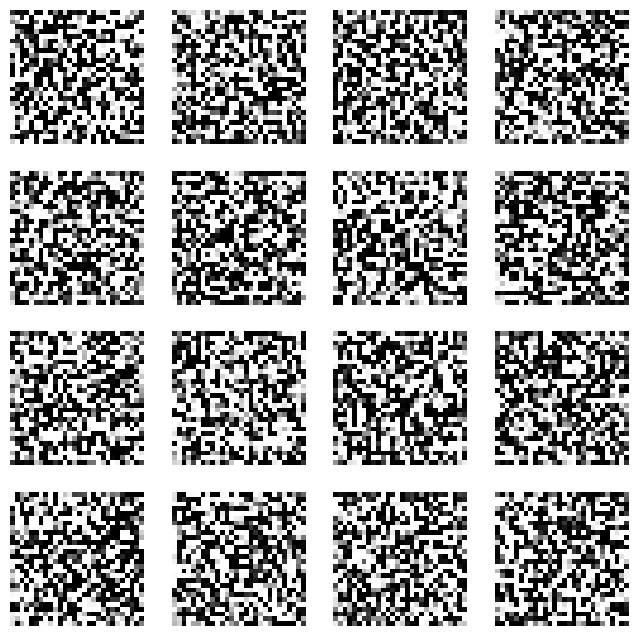

Epoch 1/185 (0.0%): [0/50048] (0.0%) D Error: 1.5357 G Error: 0.7260


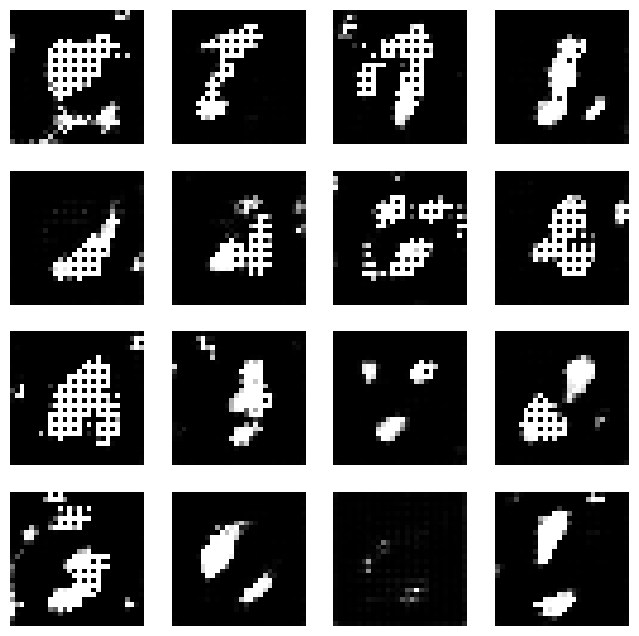

Epoch 2/185 (0.5%): [0/50048] (0.0%) D Error: 0.2013 G Error: 5.6108


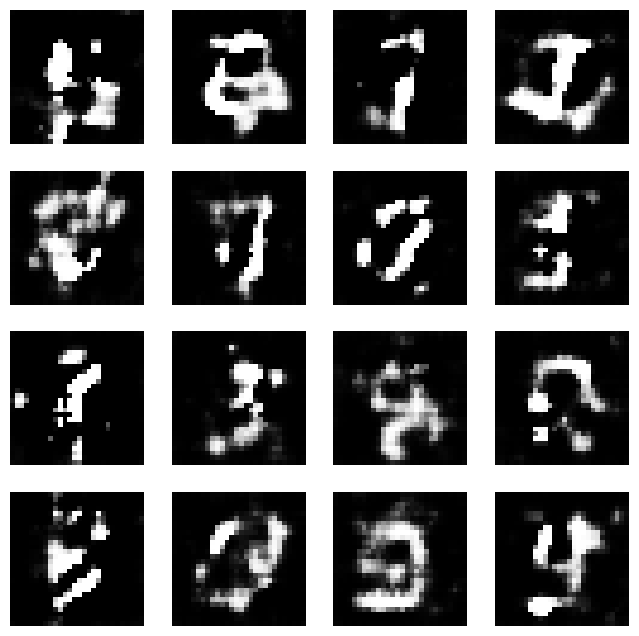

Epoch 3/185 (1.1%): [0/50048] (0.0%) D Error: 0.0880 G Error: 4.1339


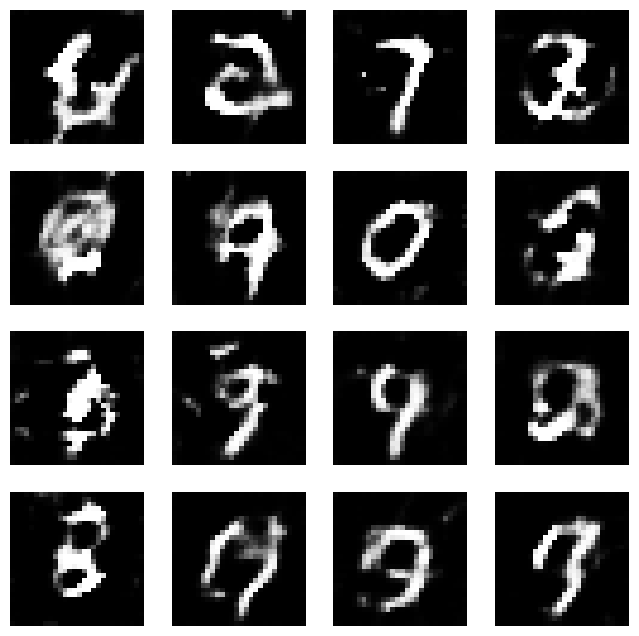

Epoch 4/185 (1.6%): [0/50048] (0.0%) D Error: 0.3468 G Error: 2.8869


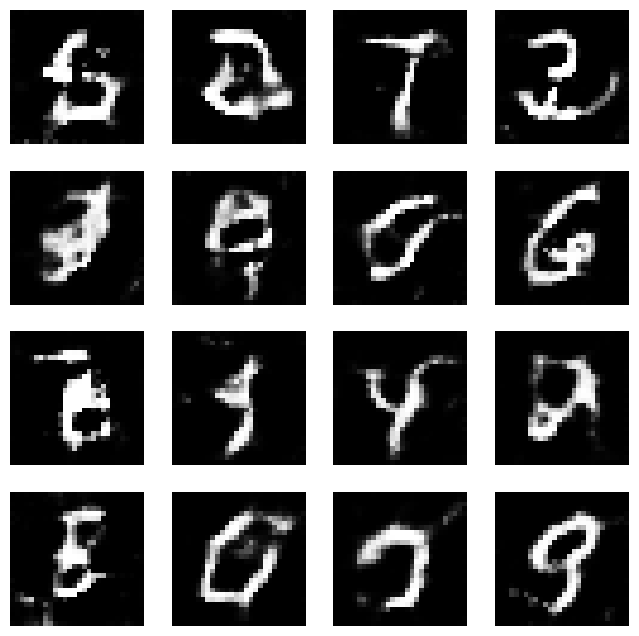

Epoch 5/185 (2.2%): [0/50048] (0.0%) D Error: 0.9444 G Error: 1.7666


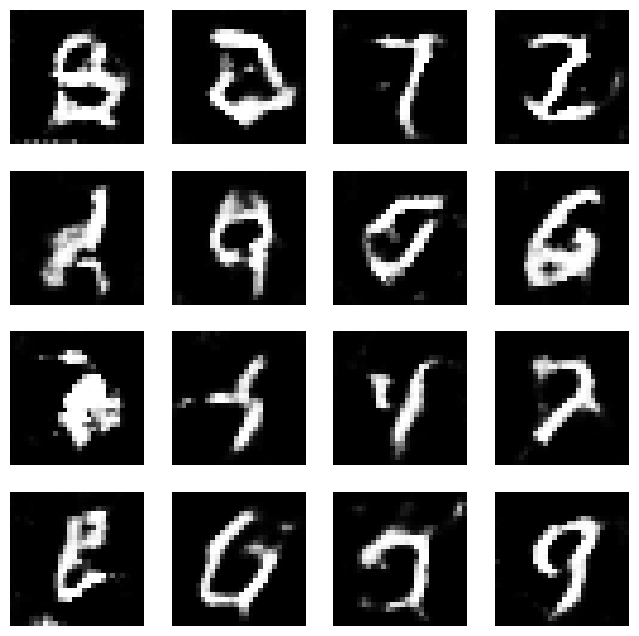

Epoch 6/185 (2.7%): [0/50048] (0.0%) D Error: 0.8917 G Error: 2.2551


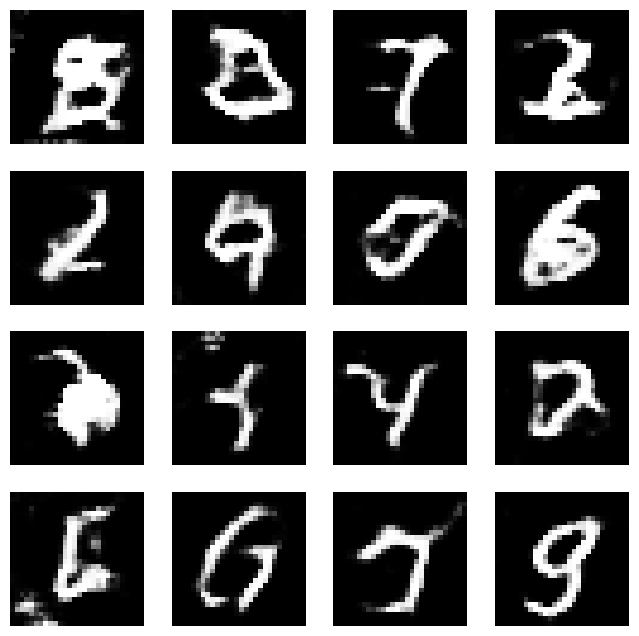

Epoch 7/185 (3.2%): [0/50048] (0.0%) D Error: 0.6530 G Error: 3.2299


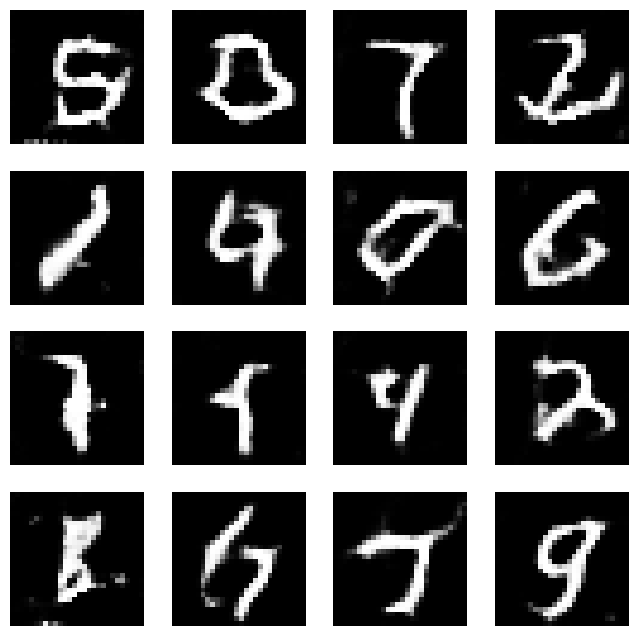

Epoch 8/185 (3.8%): [0/50048] (0.0%) D Error: 0.3026 G Error: 1.3673


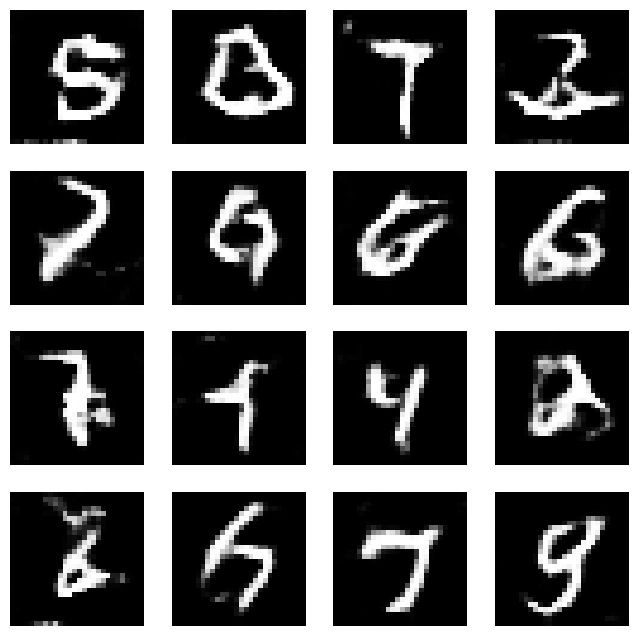

Epoch 9/185 (4.3%): [0/50048] (0.0%) D Error: 0.6056 G Error: 2.4425


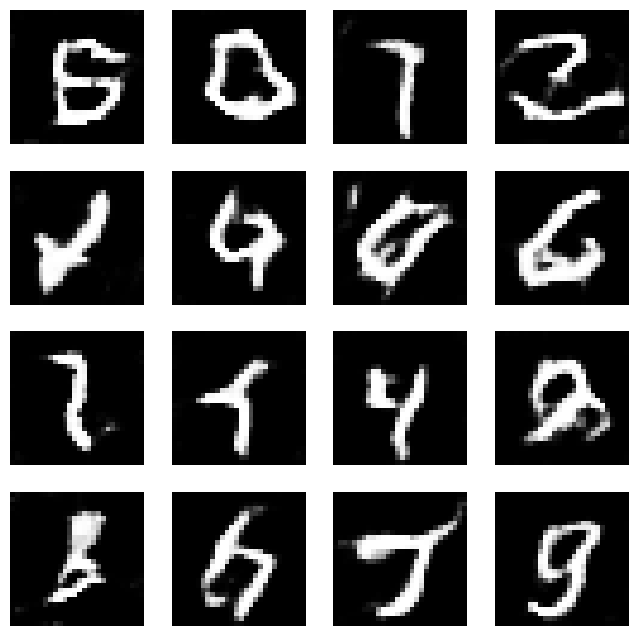

Epoch 10/185 (4.9%): [0/50048] (0.0%) D Error: 0.6489 G Error: 3.6673


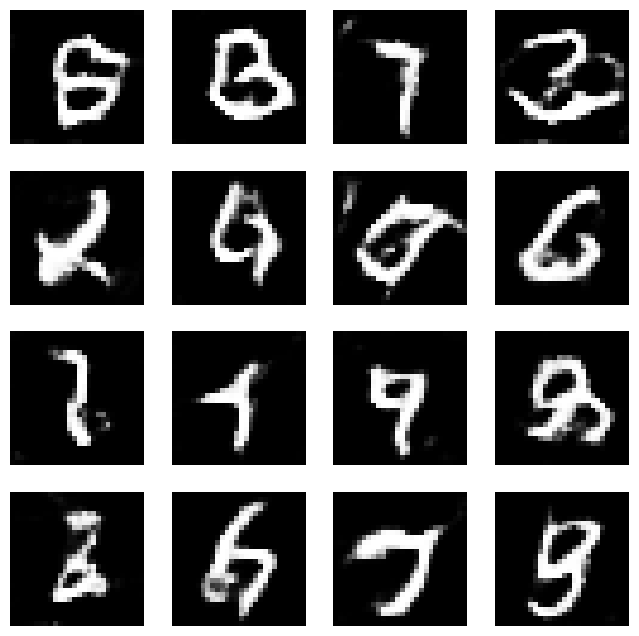

Epoch 11/185 (5.4%): [0/50048] (0.0%) D Error: 0.7668 G Error: 2.1885


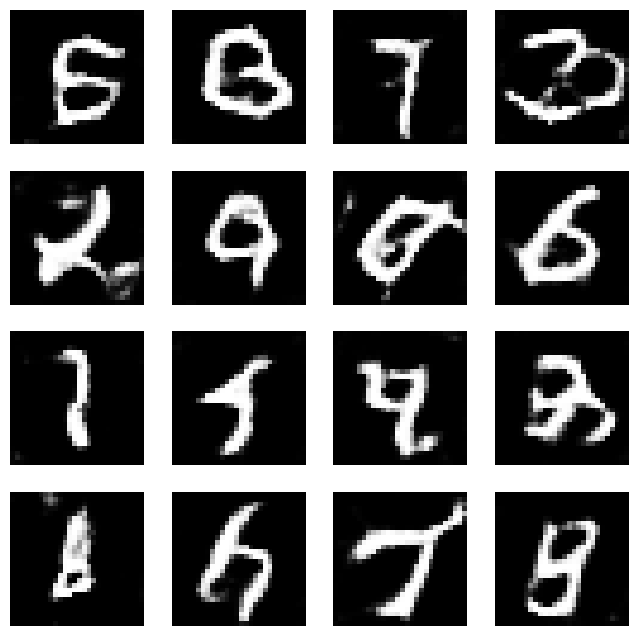

Epoch 12/185 (5.9%): [0/50048] (0.0%) D Error: 0.3878 G Error: 3.0165


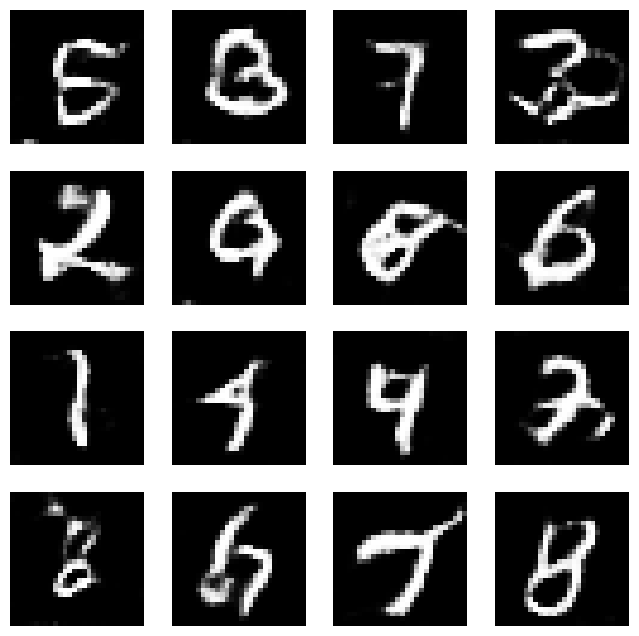

Epoch 13/185 (6.5%): [0/50048] (0.0%) D Error: 0.6868 G Error: 2.0005


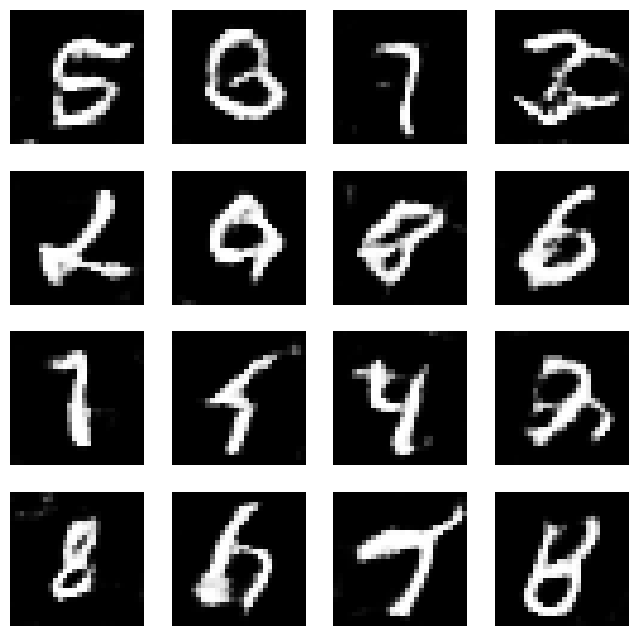

Epoch 14/185 (7.0%): [0/50048] (0.0%) D Error: 0.3031 G Error: 2.6243


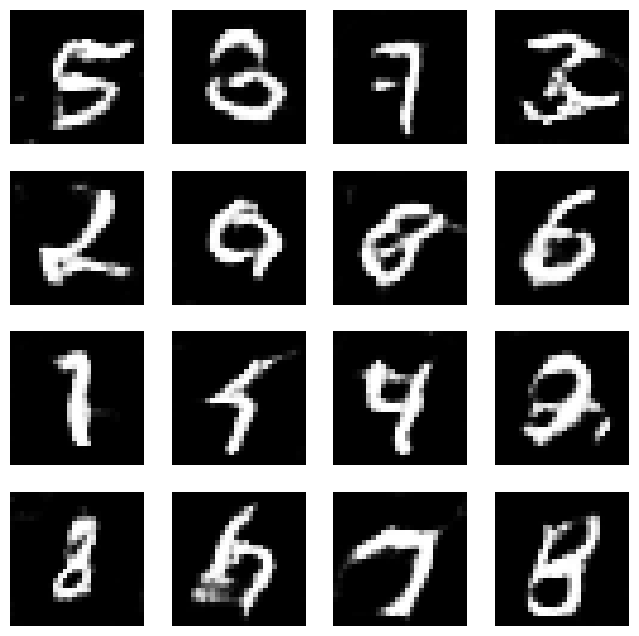

Epoch 15/185 (7.6%): [0/50048] (0.0%) D Error: 0.4271 G Error: 2.8472


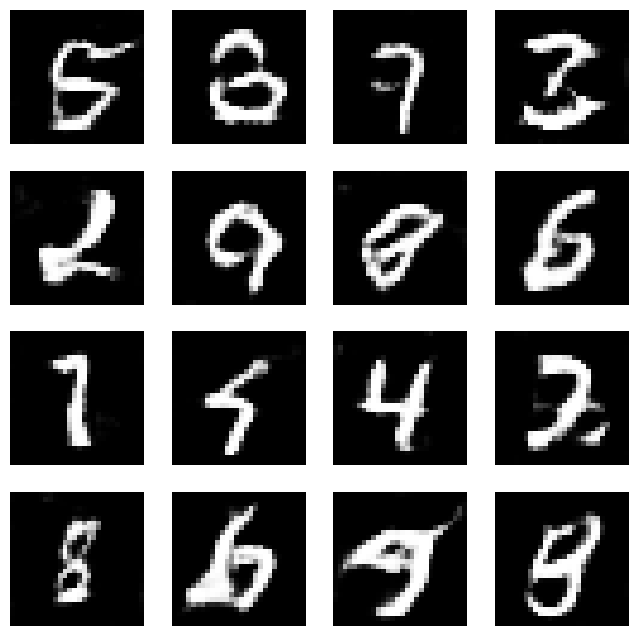

Epoch 16/185 (8.1%): [0/50048] (0.0%) D Error: 0.2281 G Error: 3.2676


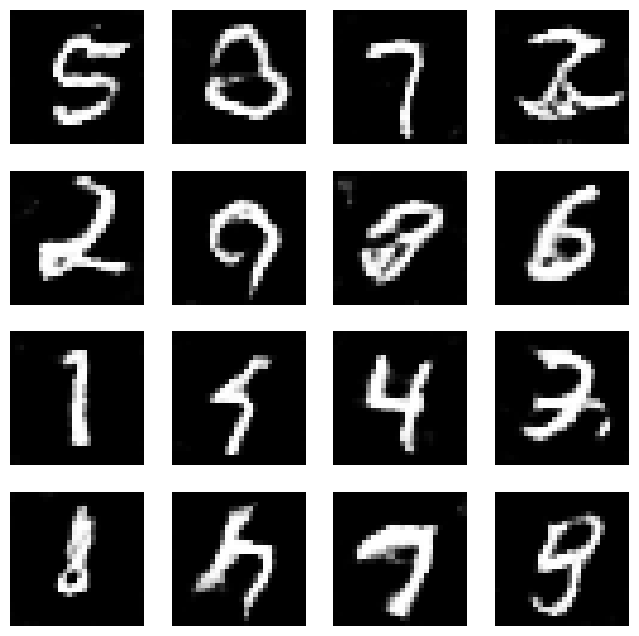

Epoch 17/185 (8.6%): [0/50048] (0.0%) D Error: 0.9508 G Error: 2.3194


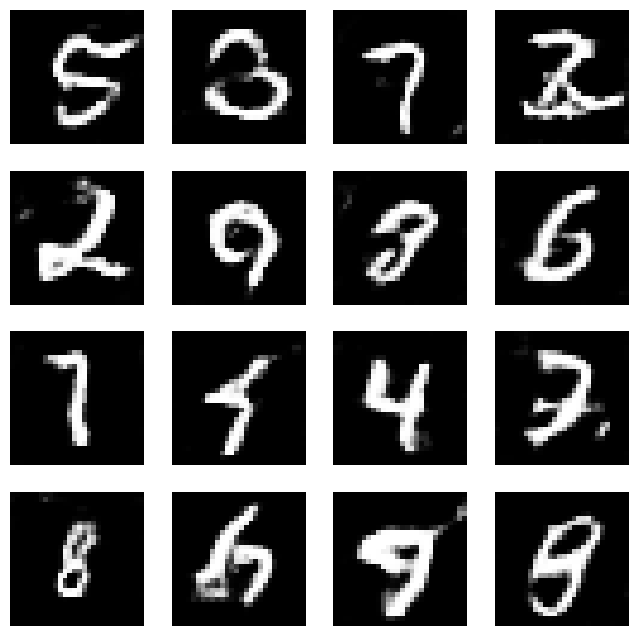

Epoch 18/185 (9.2%): [0/50048] (0.0%) D Error: 0.9277 G Error: 1.1511


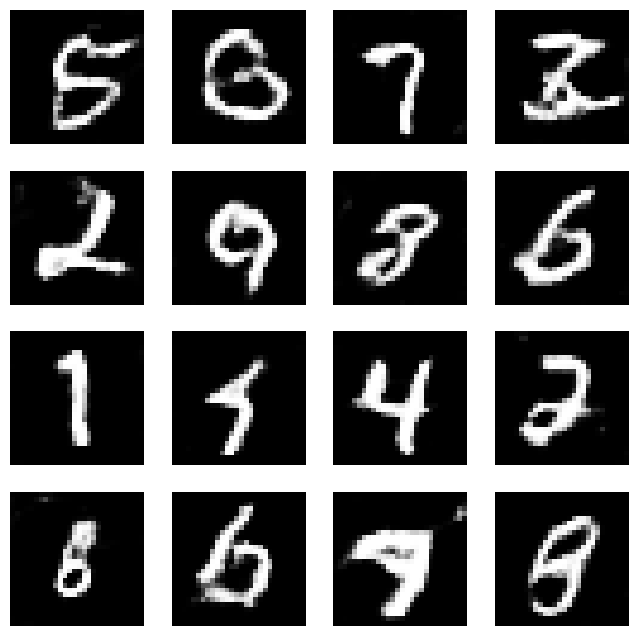

Epoch 19/185 (9.7%): [0/50048] (0.0%) D Error: 0.6075 G Error: 3.2926


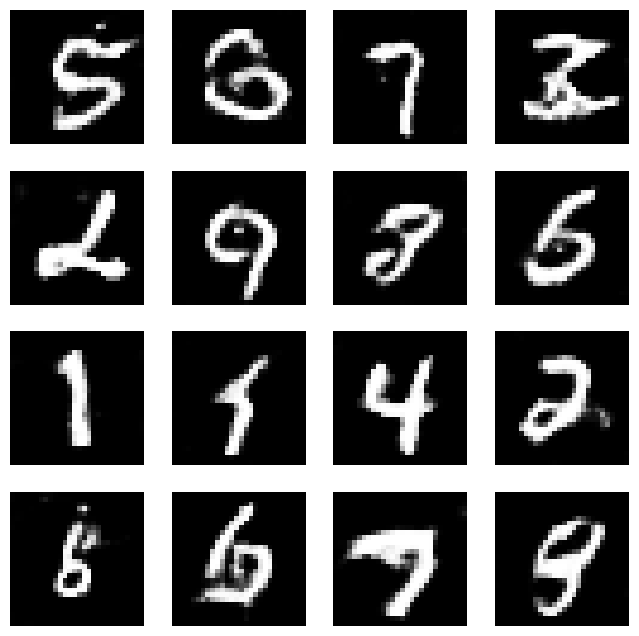

Epoch 20/185 (10.3%): [0/50048] (0.0%) D Error: 0.4972 G Error: 1.4938


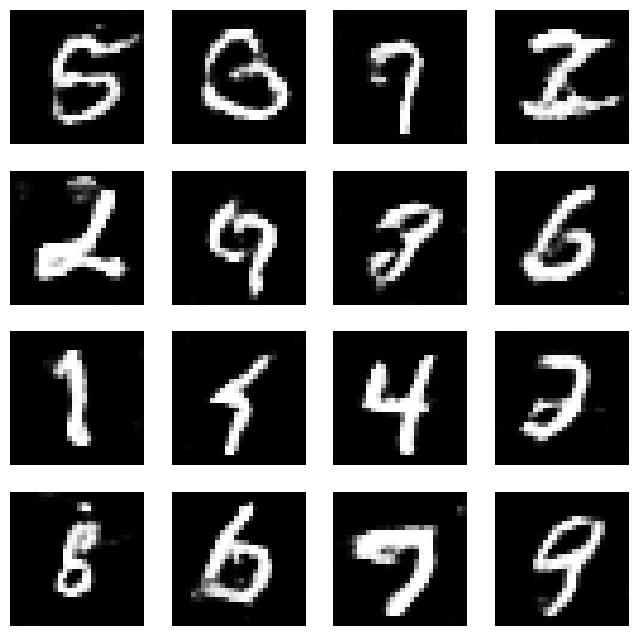

Epoch 21/185 (10.8%): [0/50048] (0.0%) D Error: 0.9989 G Error: 1.2546


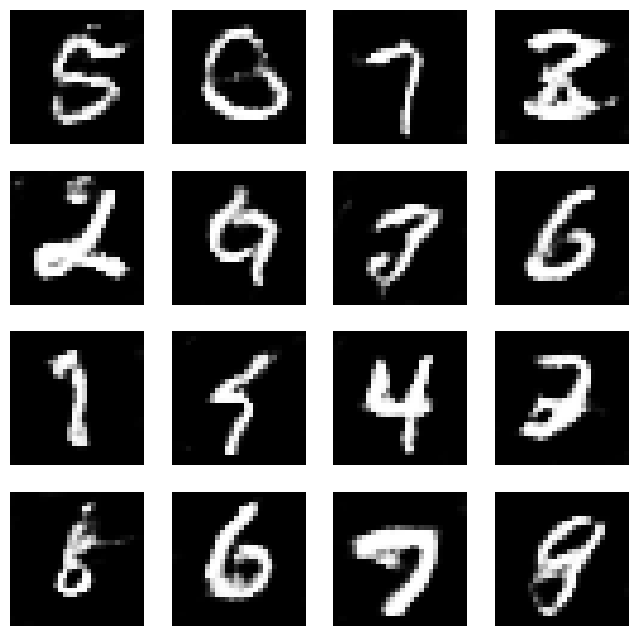

Epoch 22/185 (11.4%): [0/50048] (0.0%) D Error: 0.6487 G Error: 0.8016


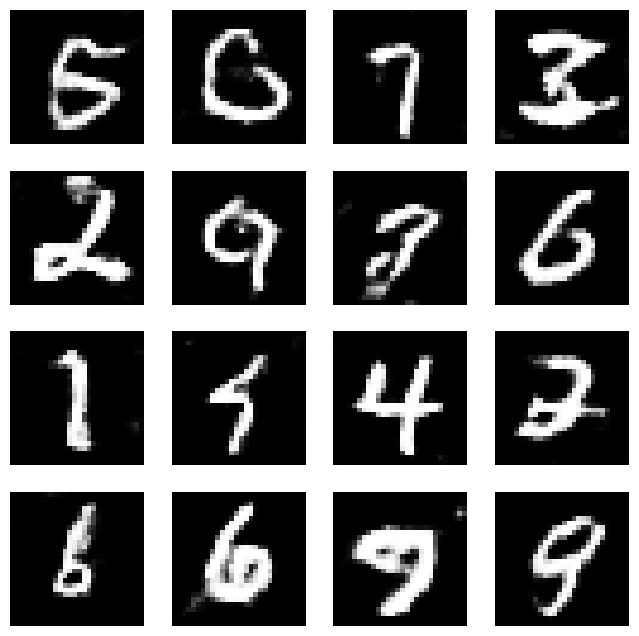

Epoch 23/185 (11.9%): [0/50048] (0.0%) D Error: 0.6712 G Error: 1.5779


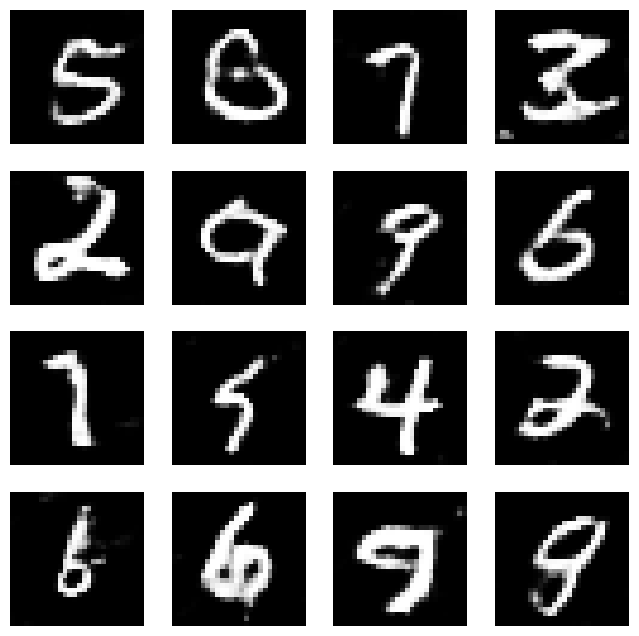

Epoch 24/185 (12.4%): [0/50048] (0.0%) D Error: 1.1654 G Error: 2.0614


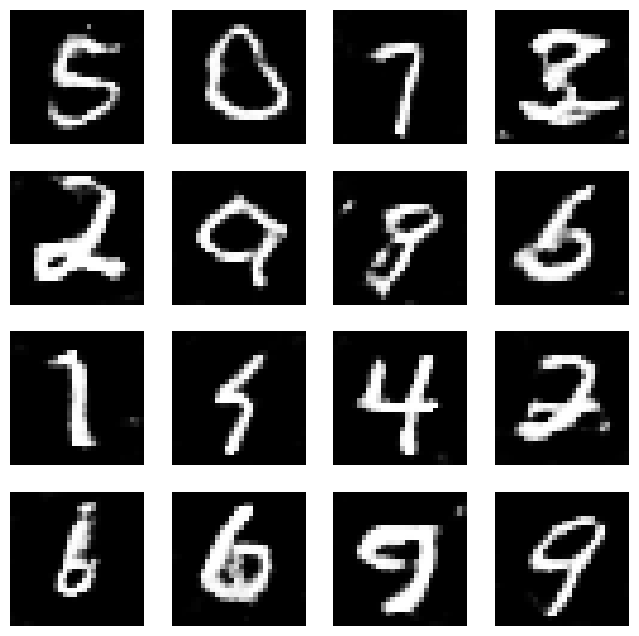

Epoch 25/185 (13.0%): [0/50048] (0.0%) D Error: 0.4322 G Error: 3.0339


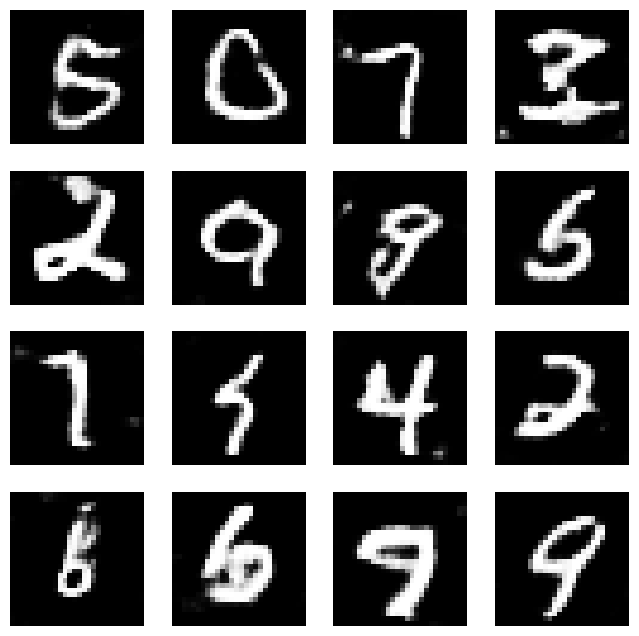

Epoch 26/185 (13.5%): [0/50048] (0.0%) D Error: 1.0965 G Error: 3.0307


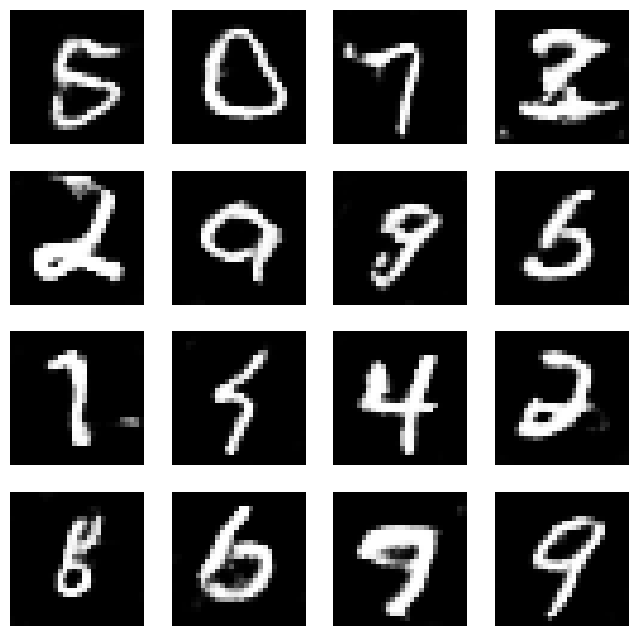

Epoch 27/185 (14.1%): [0/50048] (0.0%) D Error: 0.8272 G Error: 2.8313


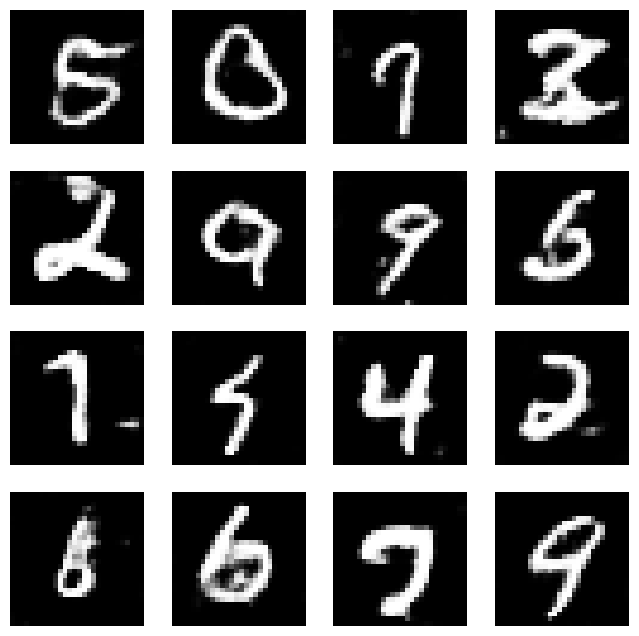

Epoch 28/185 (14.6%): [0/50048] (0.0%) D Error: 0.3430 G Error: 3.2430


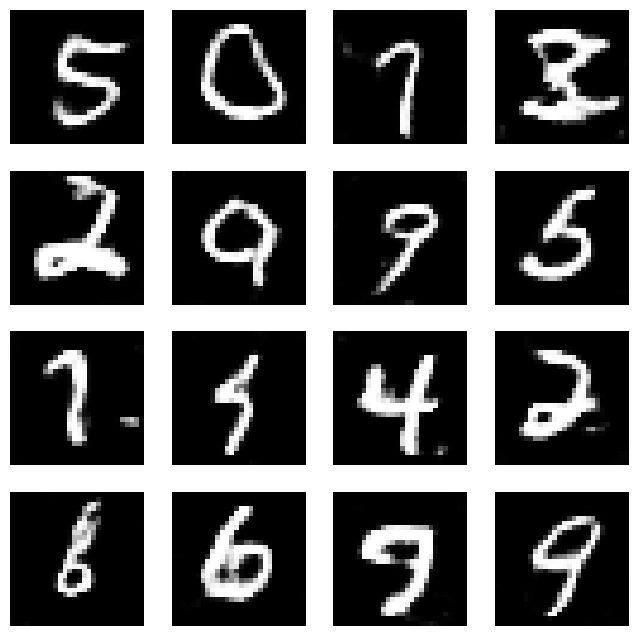

Epoch 29/185 (15.1%): [0/50048] (0.0%) D Error: 0.7094 G Error: 3.2880


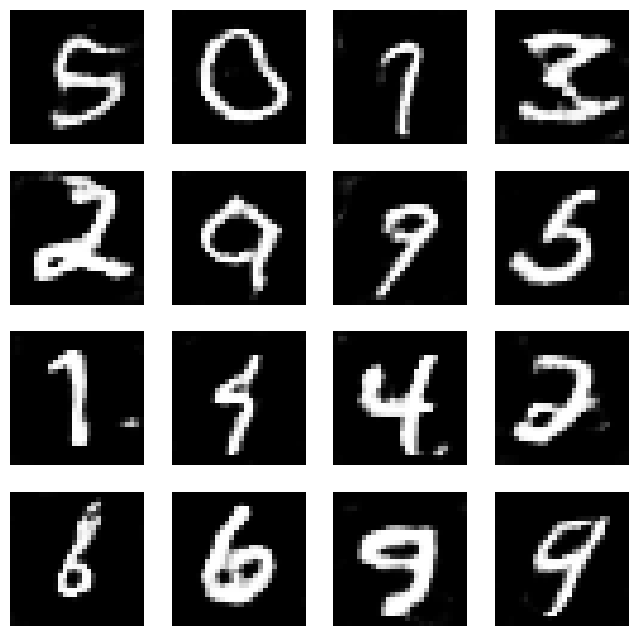

Epoch 30/185 (15.7%): [0/50048] (0.0%) D Error: 0.4110 G Error: 2.0469


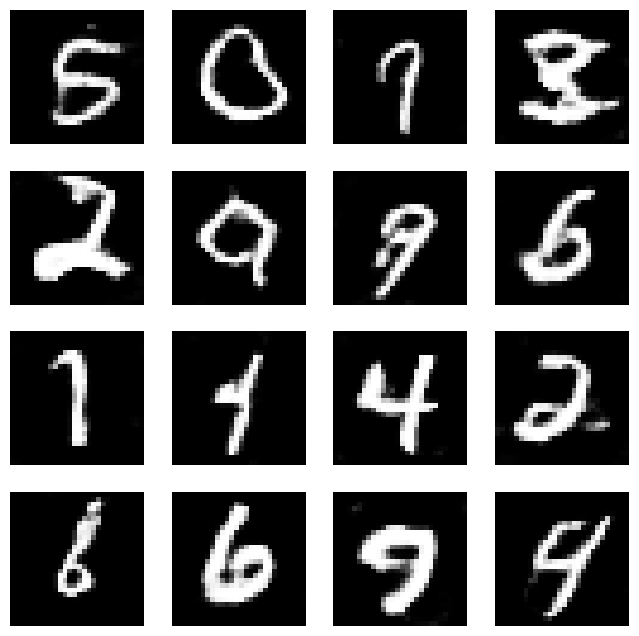

Epoch 31/185 (16.2%): [0/50048] (0.0%) D Error: 0.9081 G Error: 2.3480


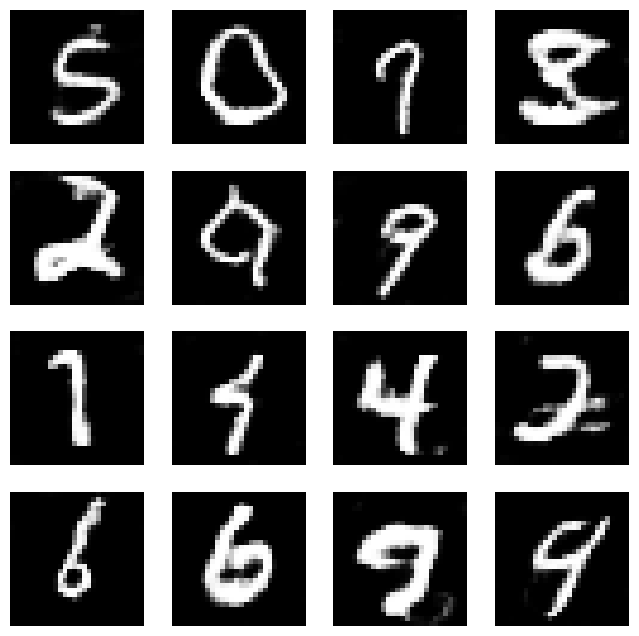

Epoch 32/185 (16.8%): [0/50048] (0.0%) D Error: 0.7614 G Error: 0.5455


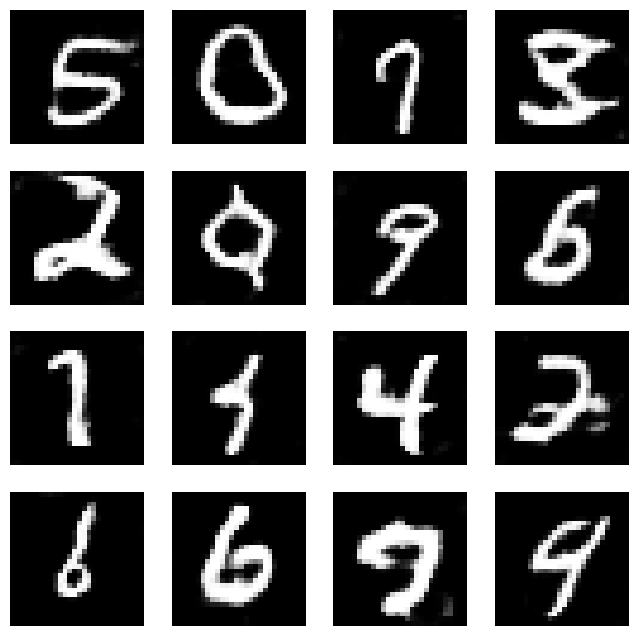

Epoch 33/185 (17.3%): [0/50048] (0.0%) D Error: 1.3248 G Error: 3.3935


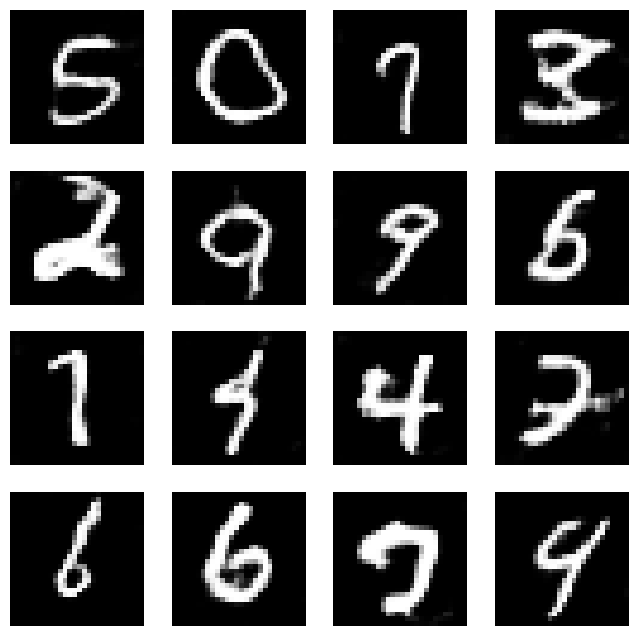

Epoch 34/185 (17.8%): [0/50048] (0.0%) D Error: 1.0506 G Error: 2.2670


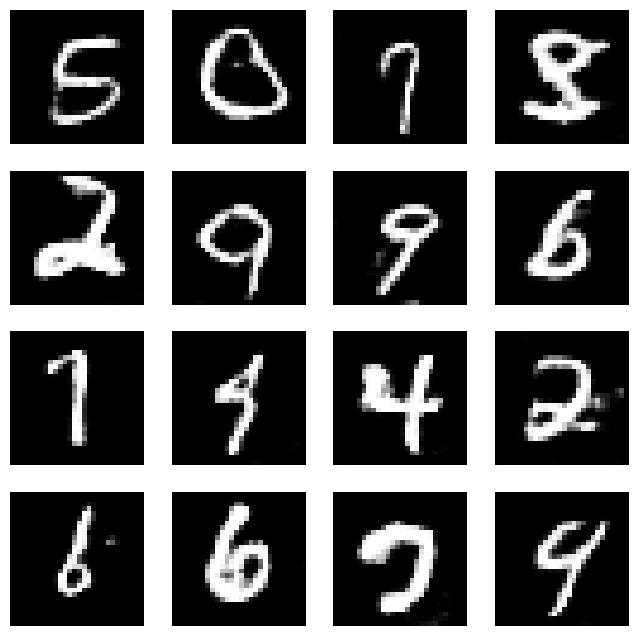

Epoch 35/185 (18.4%): [0/50048] (0.0%) D Error: 1.1100 G Error: 1.5957


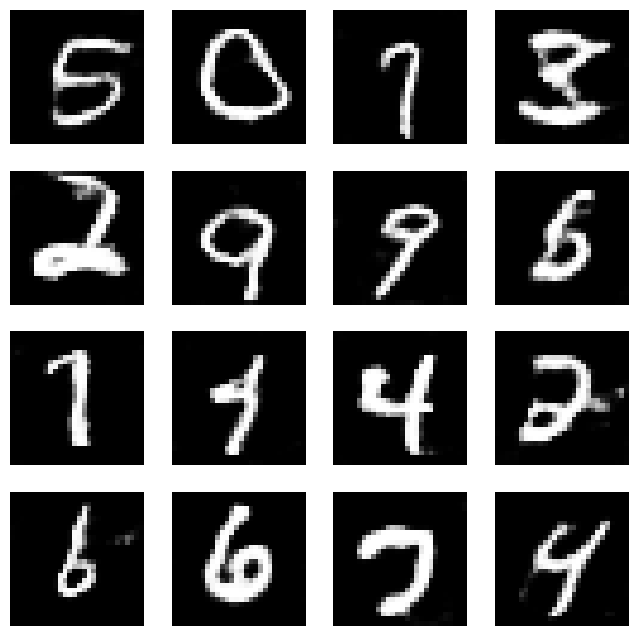

Epoch 36/185 (18.9%): [0/50048] (0.0%) D Error: 0.5188 G Error: 1.7943


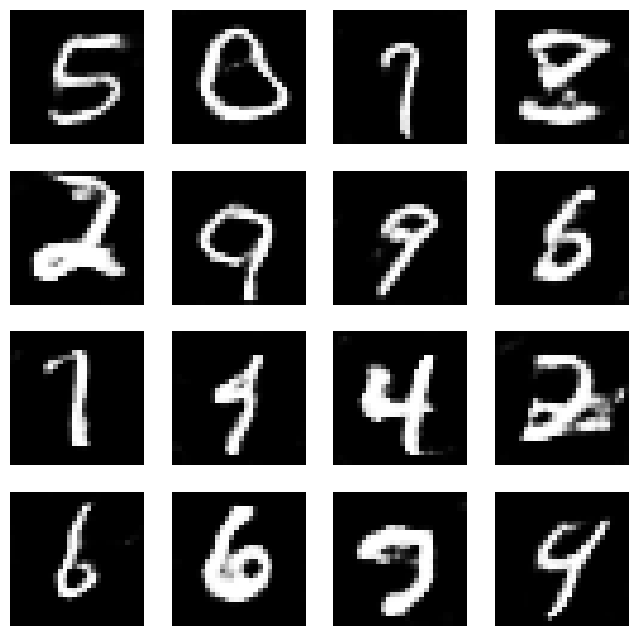

Epoch 37/185 (19.5%): [0/50048] (0.0%) D Error: 1.1827 G Error: 2.0783


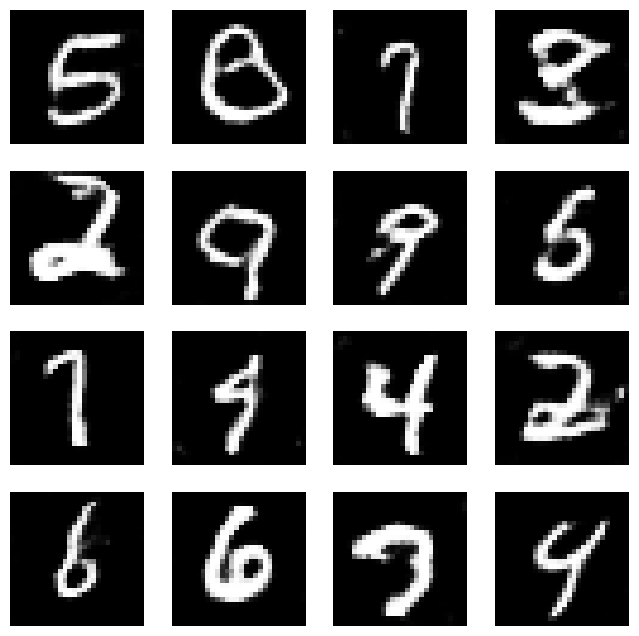

Epoch 38/185 (20.0%): [0/50048] (0.0%) D Error: 0.2615 G Error: 2.6089


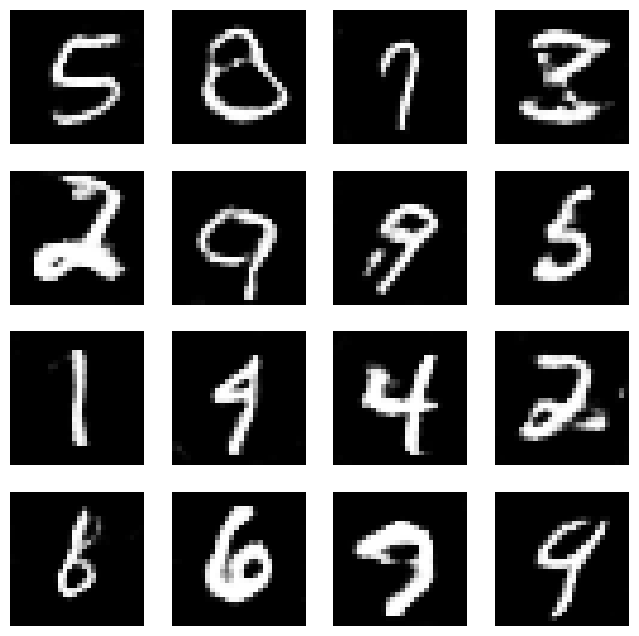

Epoch 39/185 (20.5%): [0/50048] (0.0%) D Error: 0.4702 G Error: 2.4843


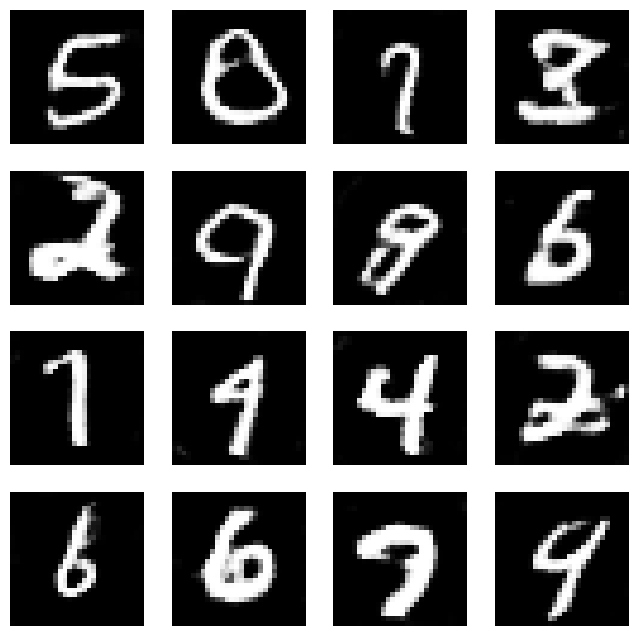

Epoch 40/185 (21.1%): [0/50048] (0.0%) D Error: 0.8030 G Error: 0.7151


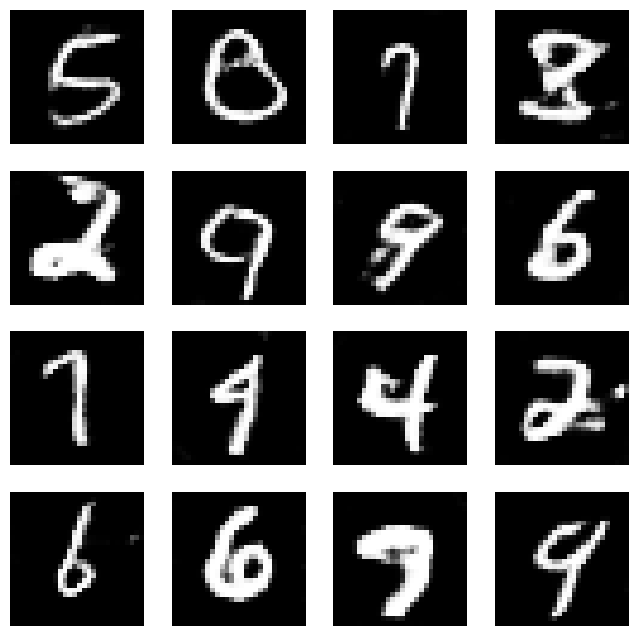

Epoch 41/185 (21.6%): [0/50048] (0.0%) D Error: 0.8241 G Error: 1.6234


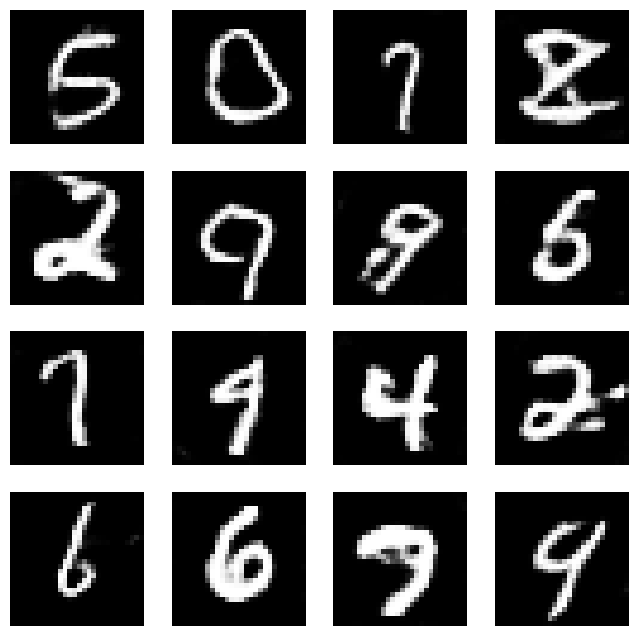

Epoch 42/185 (22.2%): [0/50048] (0.0%) D Error: 0.4474 G Error: 1.3434


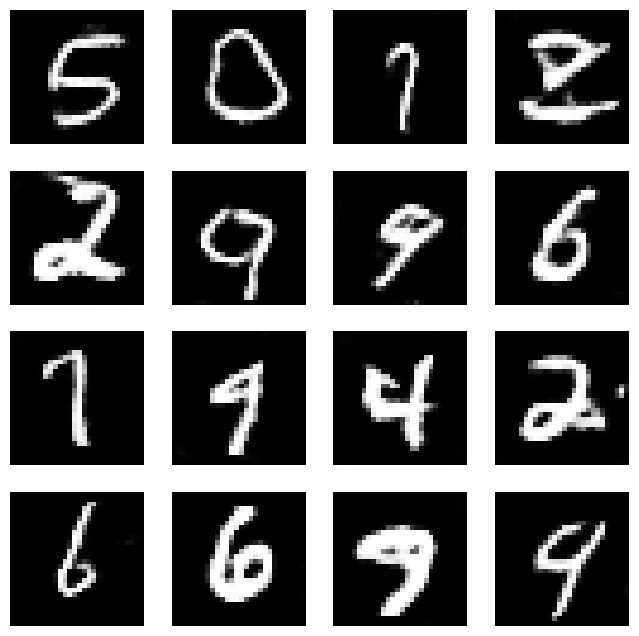

Epoch 43/185 (22.7%): [0/50048] (0.0%) D Error: 1.5258 G Error: 1.7340


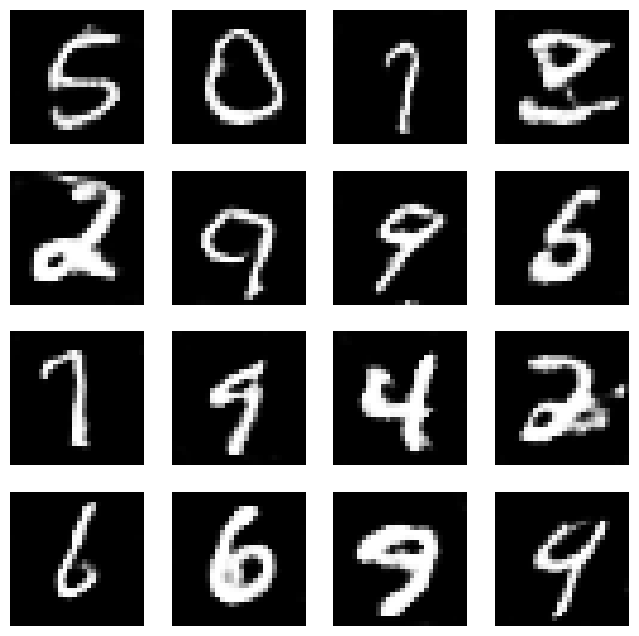

Epoch 44/185 (23.2%): [0/50048] (0.0%) D Error: 0.9358 G Error: 1.2935


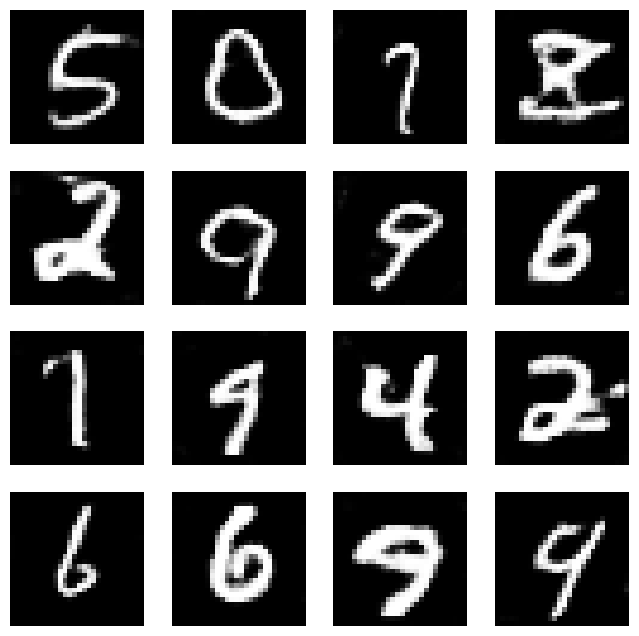

Epoch 45/185 (23.8%): [0/50048] (0.0%) D Error: 0.5366 G Error: 1.8490


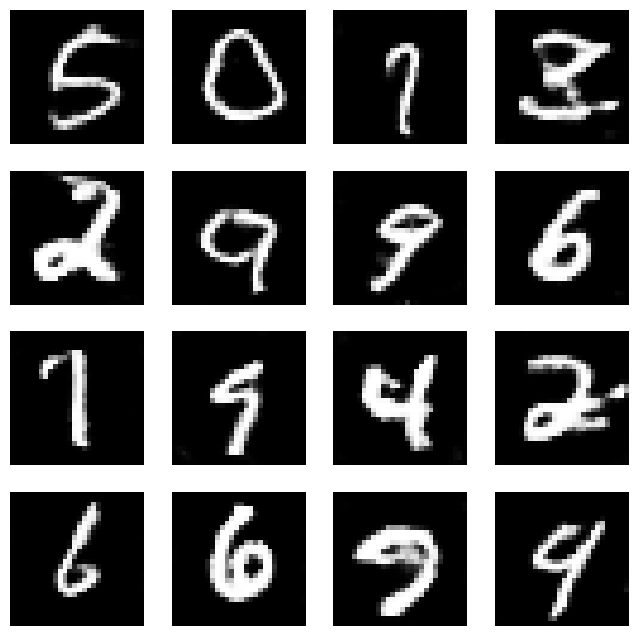

Epoch 46/185 (24.3%): [0/50048] (0.0%) D Error: 0.6306 G Error: 1.8541


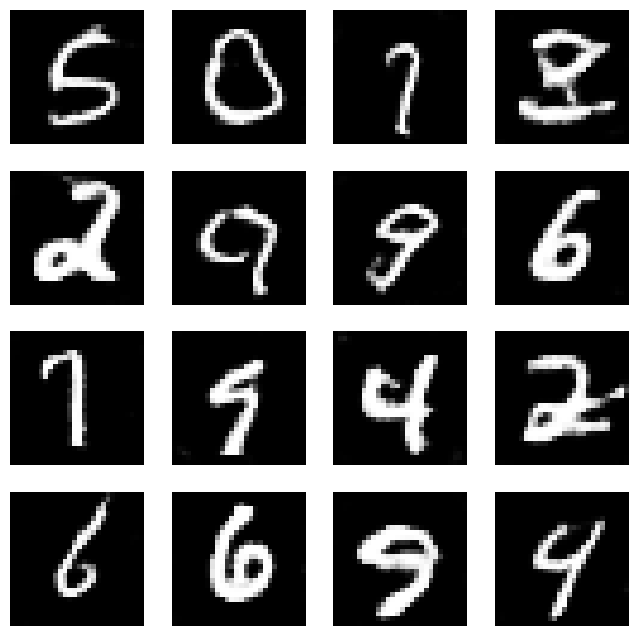

Epoch 47/185 (24.9%): [0/50048] (0.0%) D Error: 0.6568 G Error: 1.0097


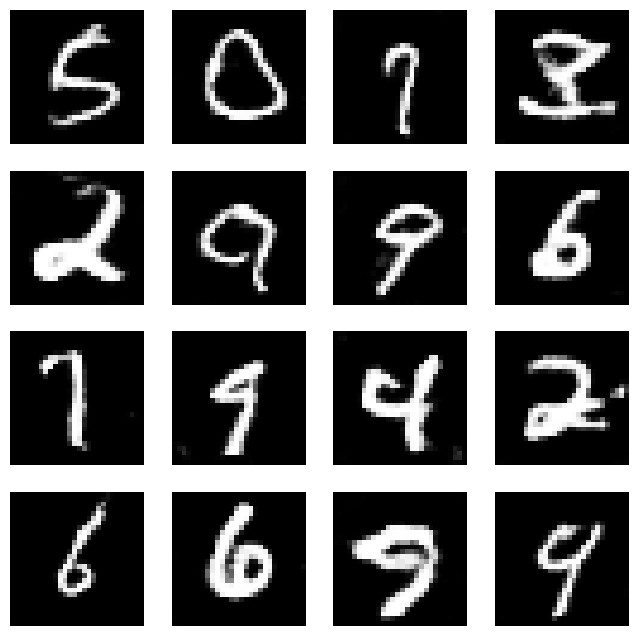

Epoch 48/185 (25.4%): [0/50048] (0.0%) D Error: 0.3523 G Error: 3.8234


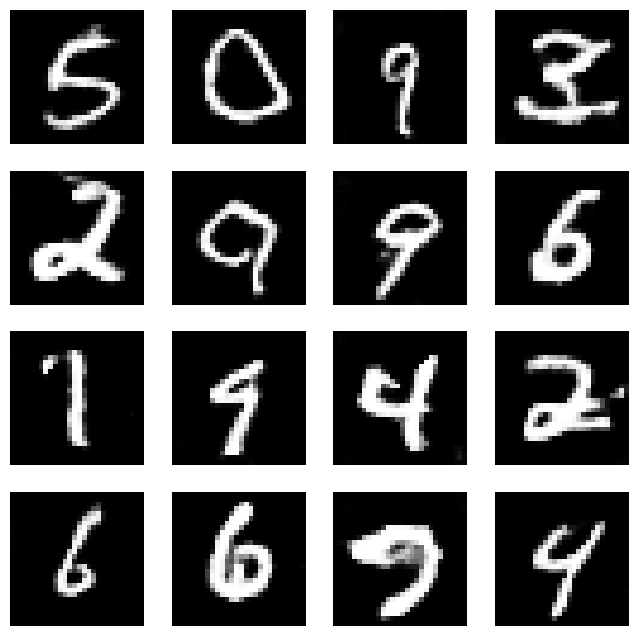

Epoch 49/185 (25.9%): [0/50048] (0.0%) D Error: 0.8718 G Error: 1.7715


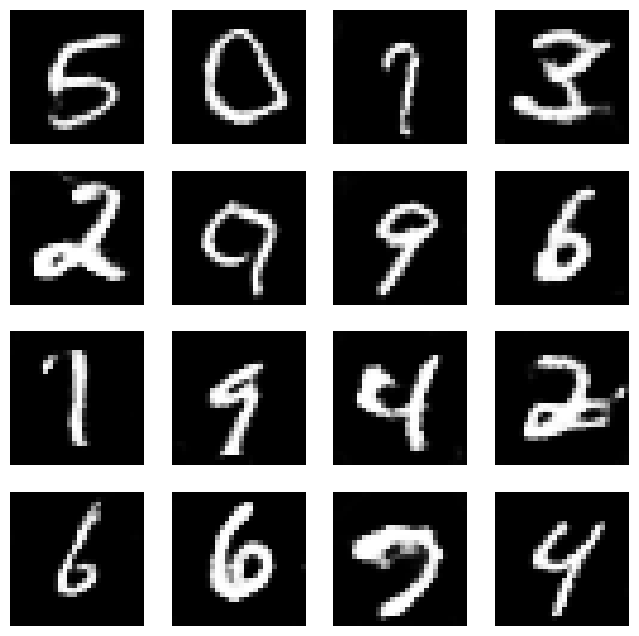

Epoch 50/185 (26.5%): [0/50048] (0.0%) D Error: 0.8821 G Error: 0.7300


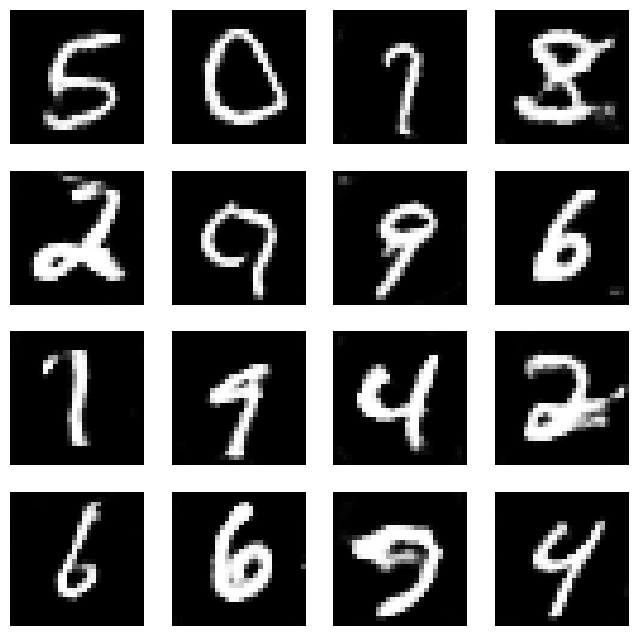

Epoch 51/185 (27.0%): [0/50048] (0.0%) D Error: 0.6661 G Error: 2.1695


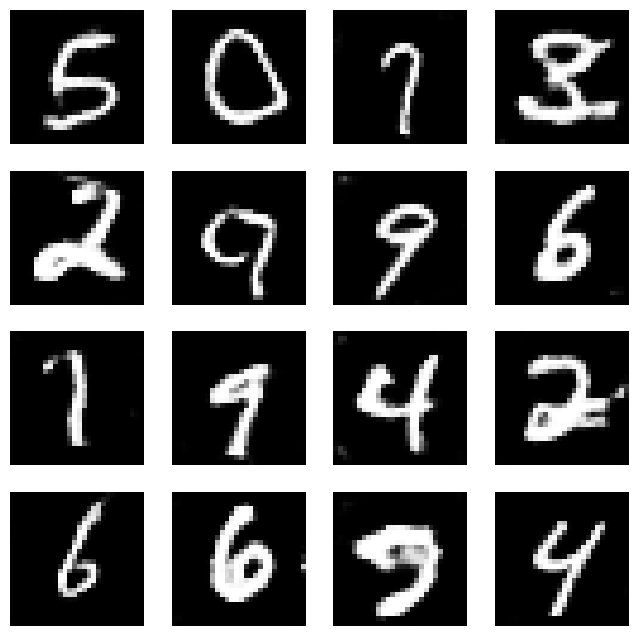

Epoch 52/185 (27.6%): [0/50048] (0.0%) D Error: 0.7666 G Error: 2.6471


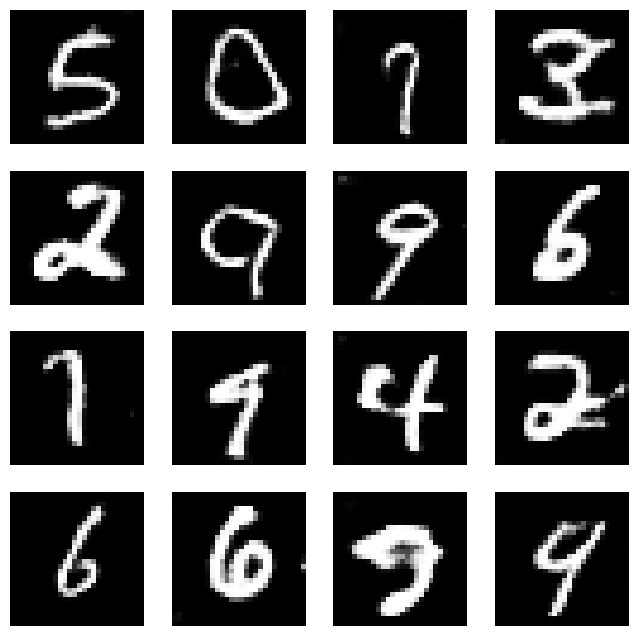

Epoch 53/185 (28.1%): [0/50048] (0.0%) D Error: 0.8265 G Error: 0.5568


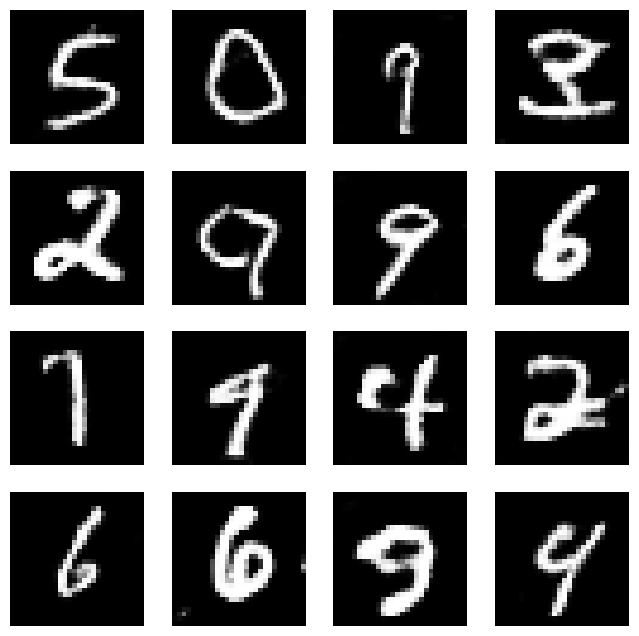

Epoch 54/185 (28.6%): [0/50048] (0.0%) D Error: 0.5008 G Error: 1.7427


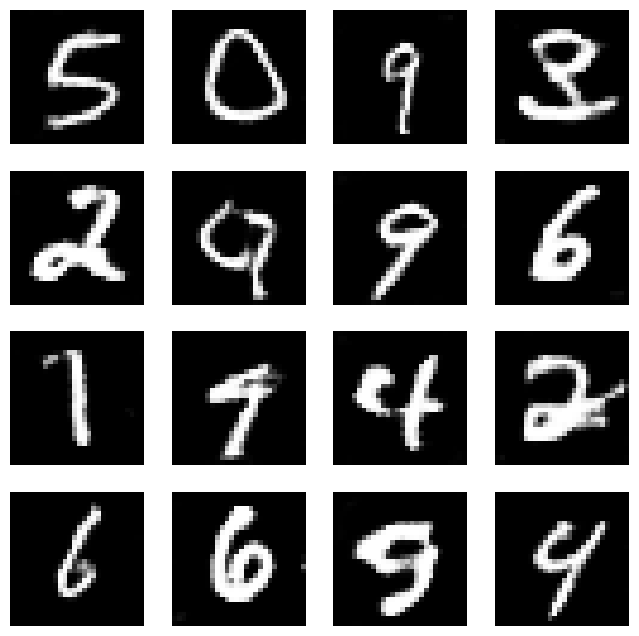

Epoch 55/185 (29.2%): [0/50048] (0.0%) D Error: 2.3985 G Error: 3.7509


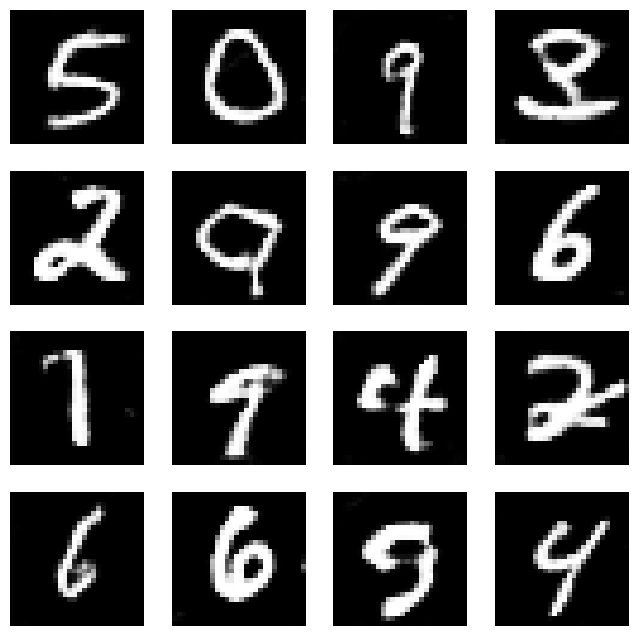

Epoch 56/185 (29.7%): [0/50048] (0.0%) D Error: 0.8501 G Error: 2.1679


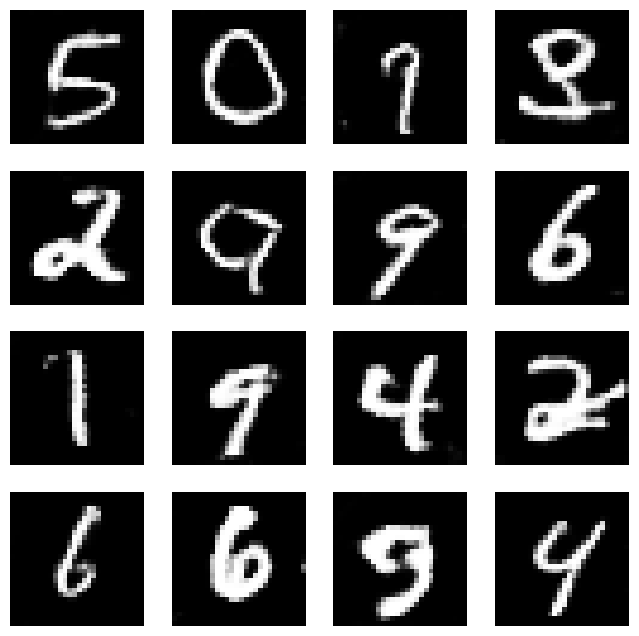

Epoch 57/185 (30.3%): [0/50048] (0.0%) D Error: 0.3505 G Error: 2.2123


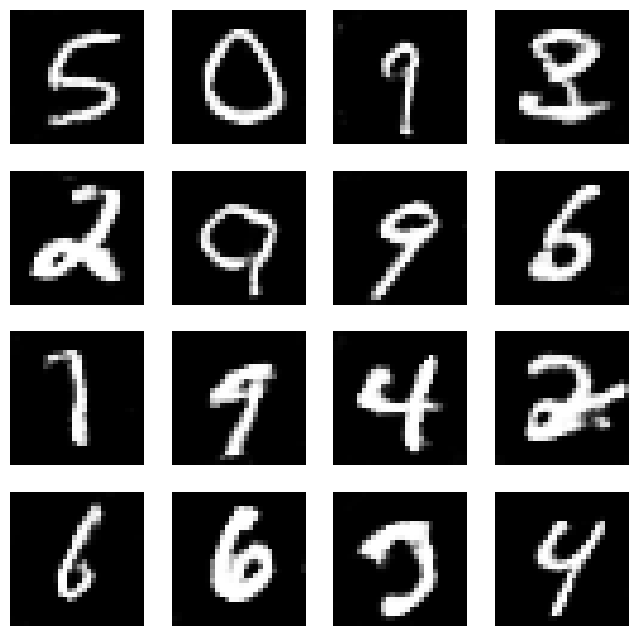

Epoch 58/185 (30.8%): [0/50048] (0.0%) D Error: 1.0173 G Error: 1.7763


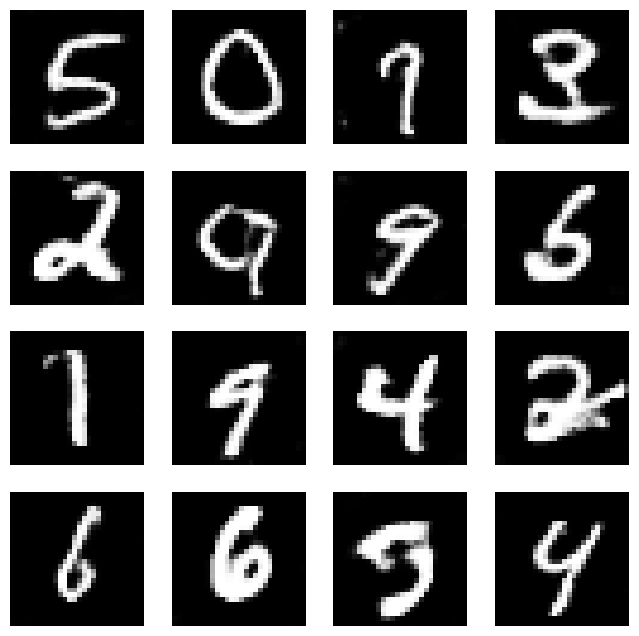

Epoch 59/185 (31.4%): [0/50048] (0.0%) D Error: 0.3012 G Error: 1.3142


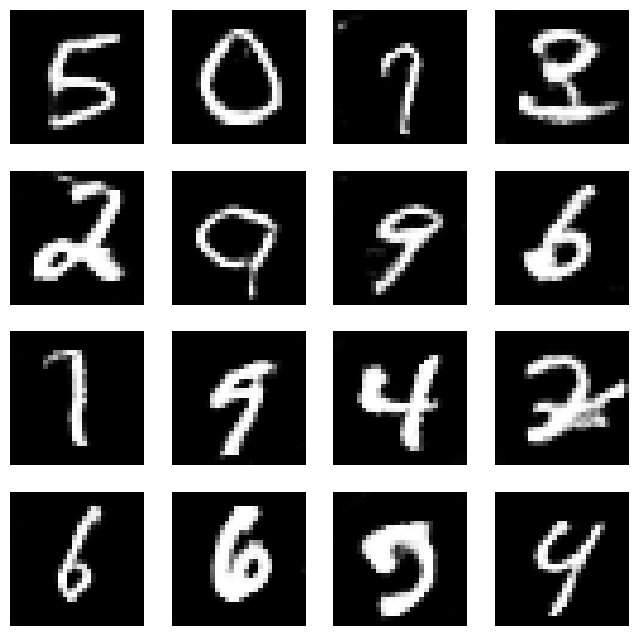

Epoch 60/185 (31.9%): [0/50048] (0.0%) D Error: 0.9427 G Error: 1.4408


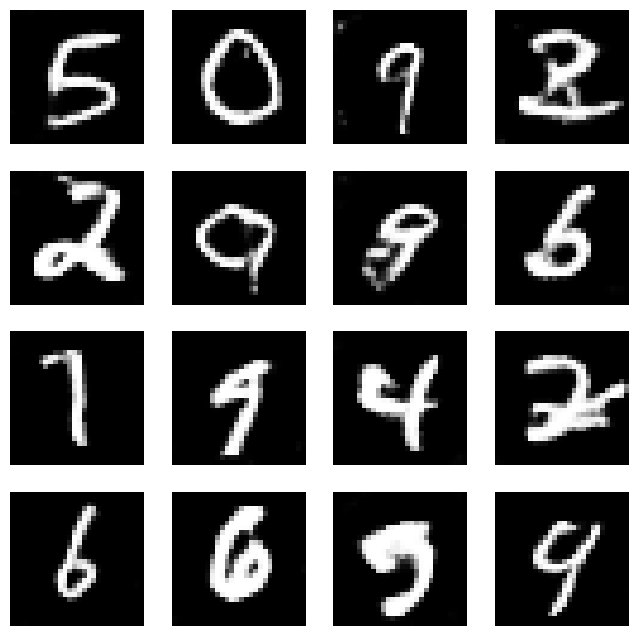

Epoch 61/185 (32.4%): [0/50048] (0.0%) D Error: 0.5408 G Error: 0.8433


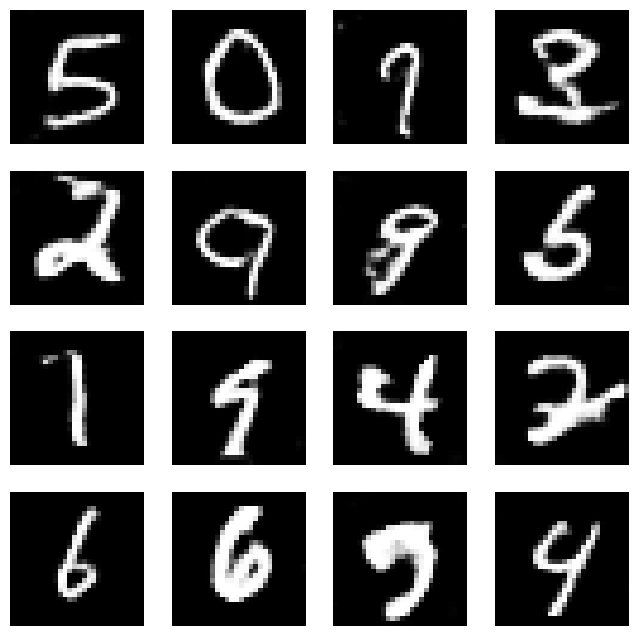

Epoch 62/185 (33.0%): [0/50048] (0.0%) D Error: 0.9205 G Error: 1.1190


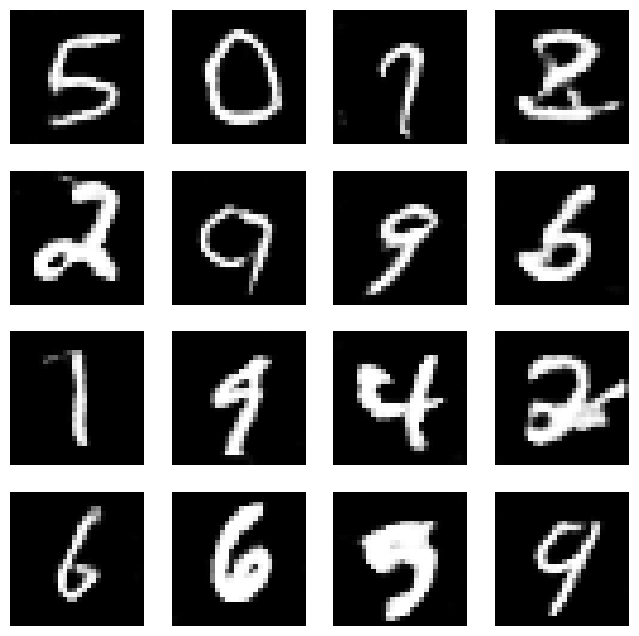

Epoch 63/185 (33.5%): [0/50048] (0.0%) D Error: 0.7664 G Error: 2.3296


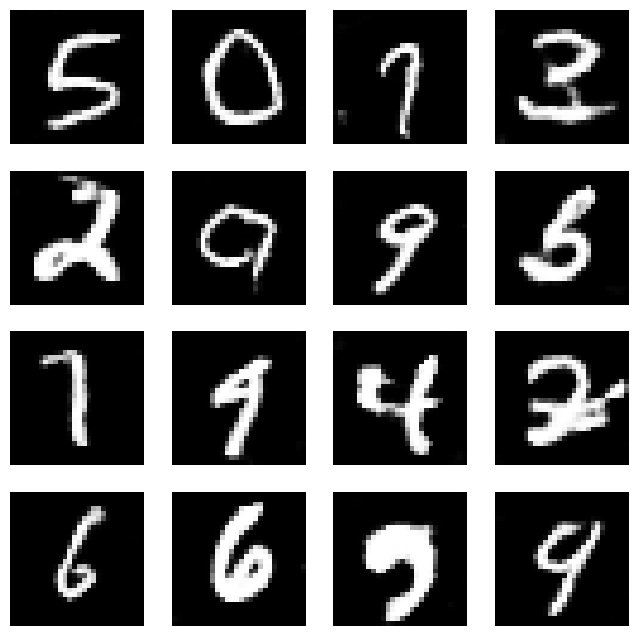

Epoch 64/185 (34.1%): [0/50048] (0.0%) D Error: 0.5620 G Error: 2.2919


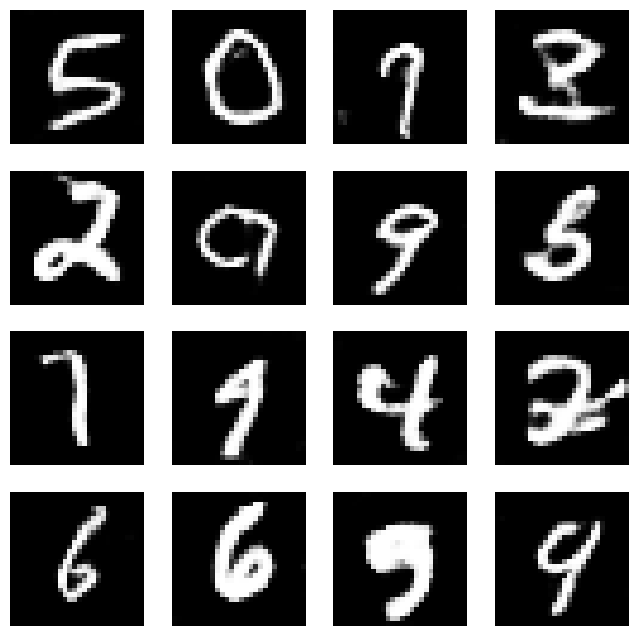

Epoch 65/185 (34.6%): [0/50048] (0.0%) D Error: 0.8170 G Error: 3.3296


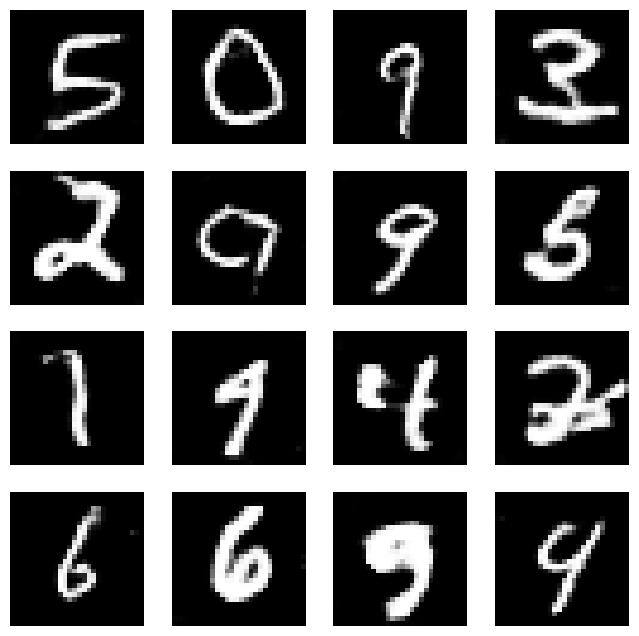

Epoch 66/185 (35.1%): [0/50048] (0.0%) D Error: 0.5917 G Error: 2.2827


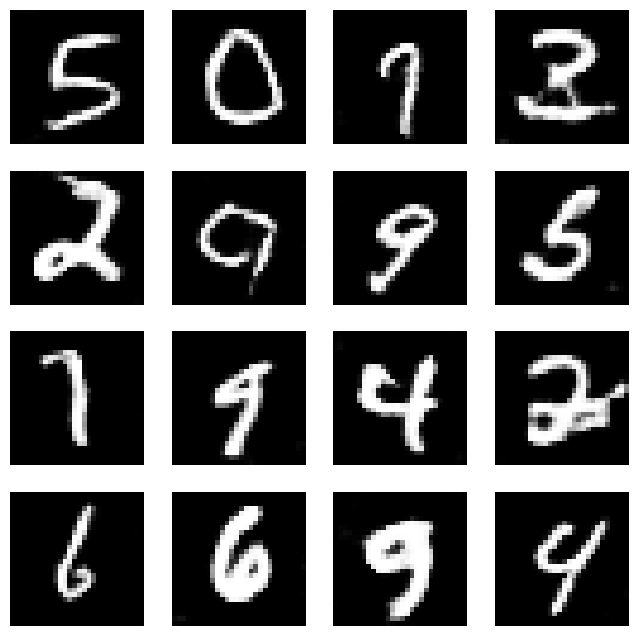

Epoch 67/185 (35.7%): [0/50048] (0.0%) D Error: 0.6799 G Error: 0.5630


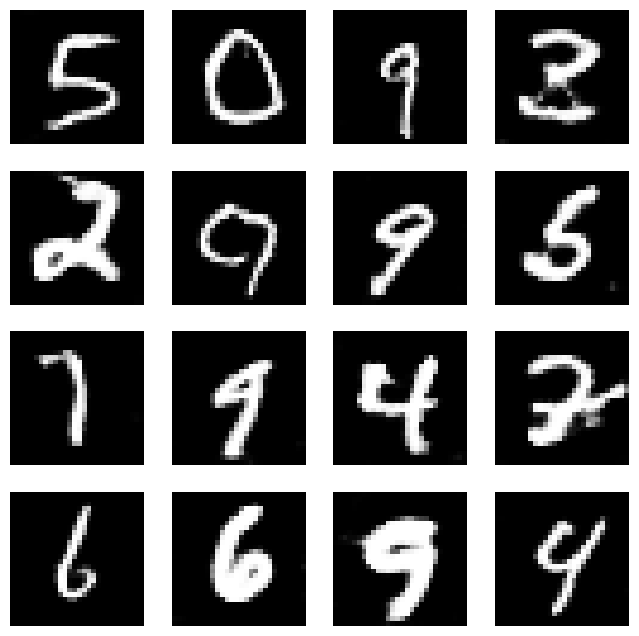

Epoch 68/185 (36.2%): [0/50048] (0.0%) D Error: 0.5840 G Error: 1.5301


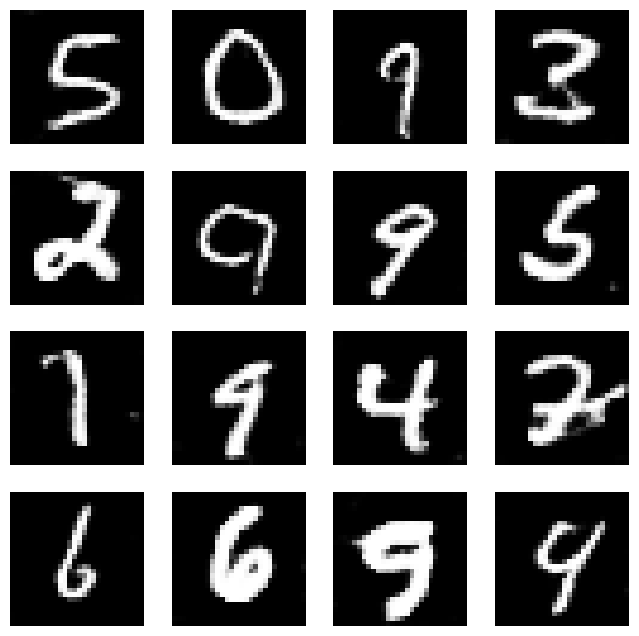

Epoch 69/185 (36.8%): [0/50048] (0.0%) D Error: 1.2528 G Error: 1.5042


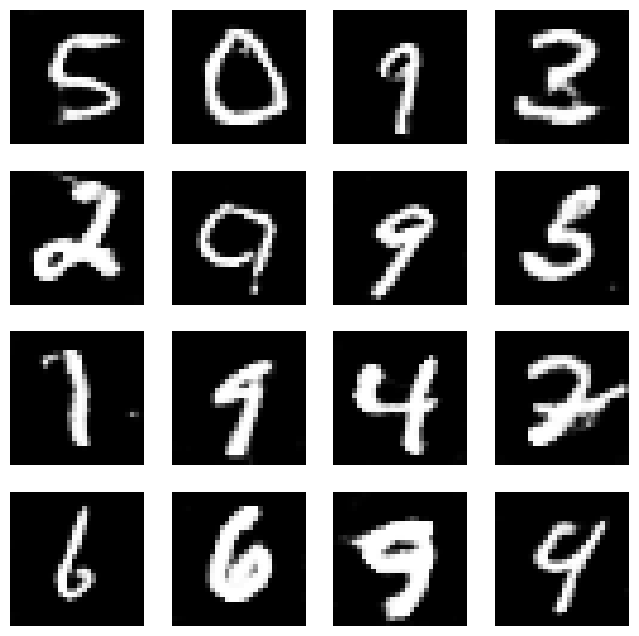

Epoch 70/185 (37.3%): [0/50048] (0.0%) D Error: 0.5929 G Error: 2.9120


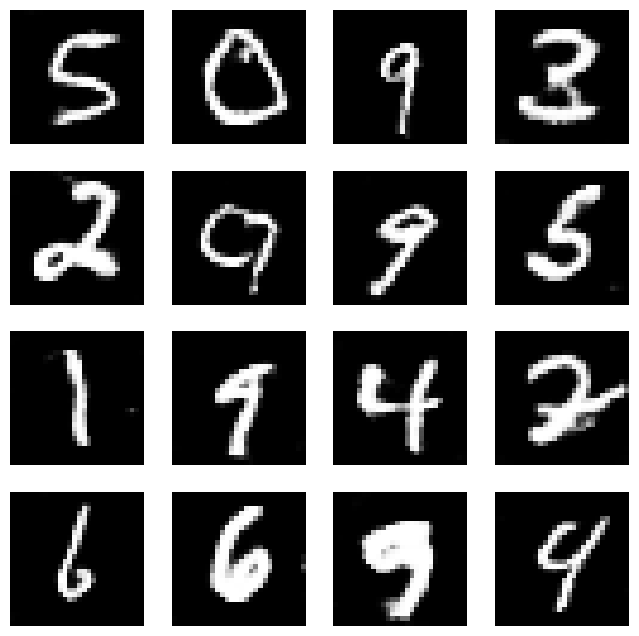

Epoch 71/185 (37.8%): [0/50048] (0.0%) D Error: 0.7832 G Error: 1.1538


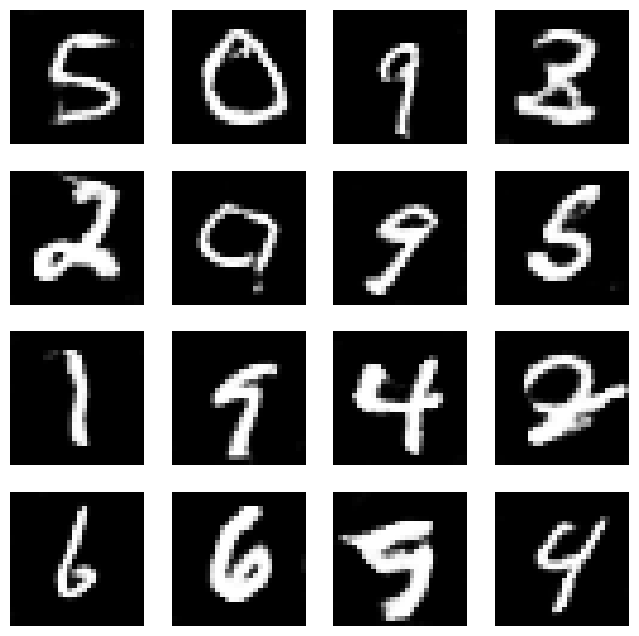

Epoch 72/185 (38.4%): [0/50048] (0.0%) D Error: 1.2516 G Error: 2.6640


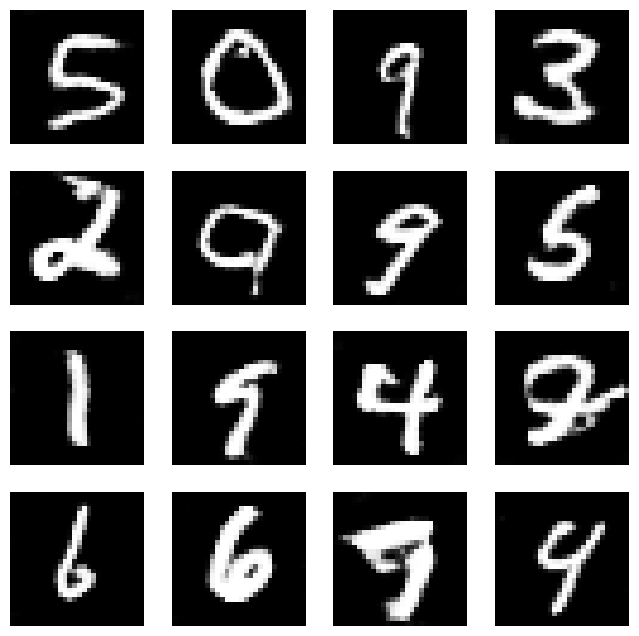

Epoch 73/185 (38.9%): [0/50048] (0.0%) D Error: 1.0923 G Error: 2.4459


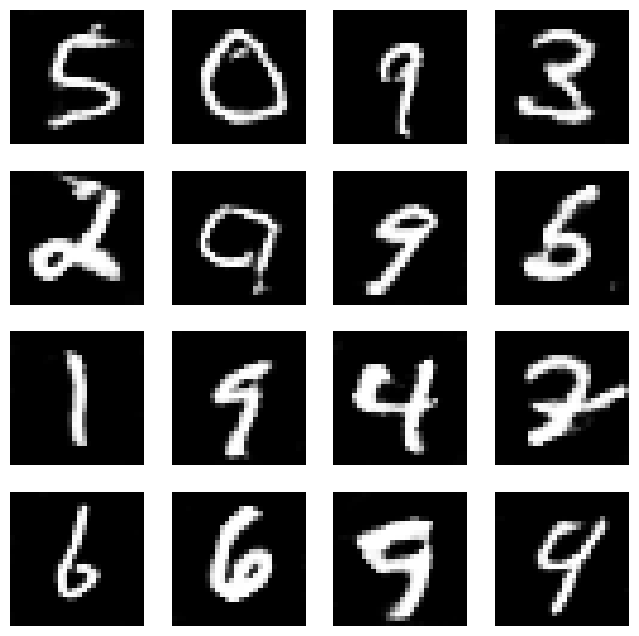

Epoch 74/185 (39.5%): [0/50048] (0.0%) D Error: 0.5927 G Error: 2.9286


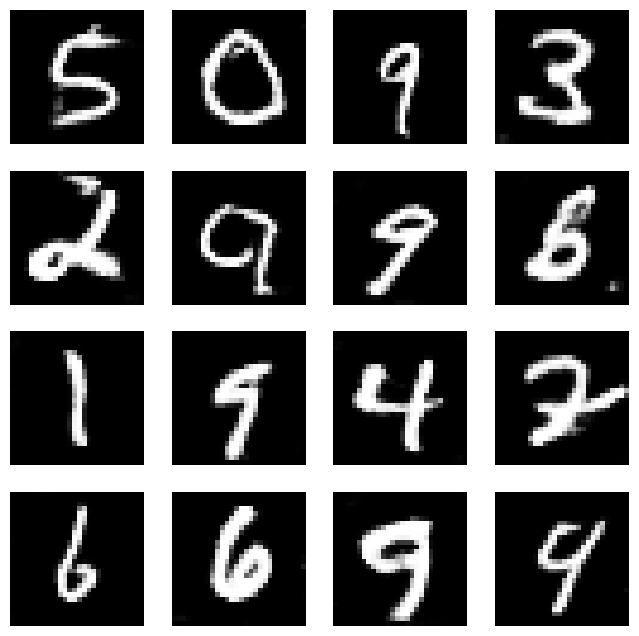

Epoch 75/185 (40.0%): [0/50048] (0.0%) D Error: 0.7802 G Error: 1.3739


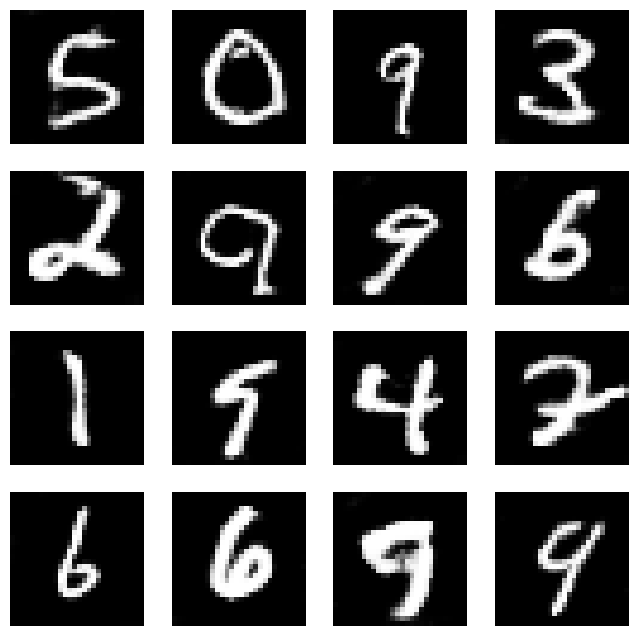

Epoch 76/185 (40.5%): [0/50048] (0.0%) D Error: 0.4559 G Error: 1.2874


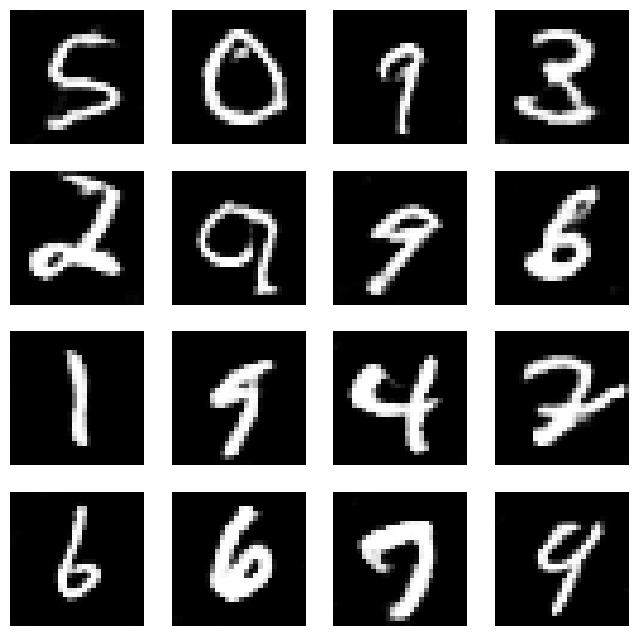

Epoch 77/185 (41.1%): [0/50048] (0.0%) D Error: 1.3937 G Error: 3.0417


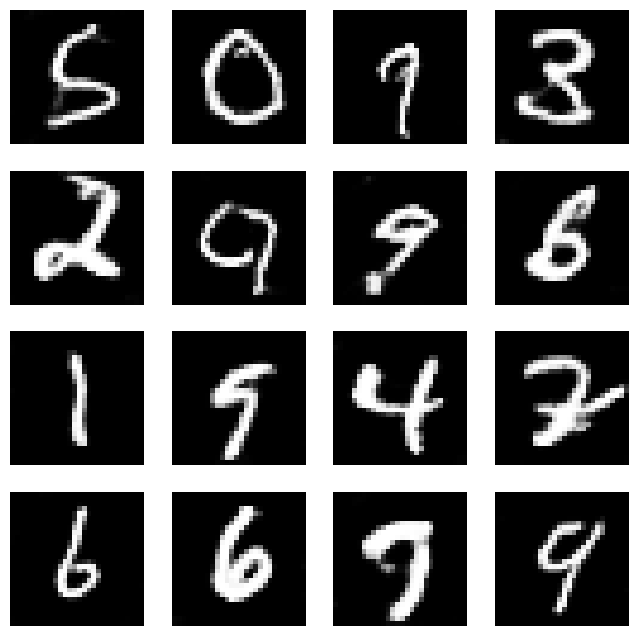

Epoch 78/185 (41.6%): [0/50048] (0.0%) D Error: 0.8364 G Error: 0.9488


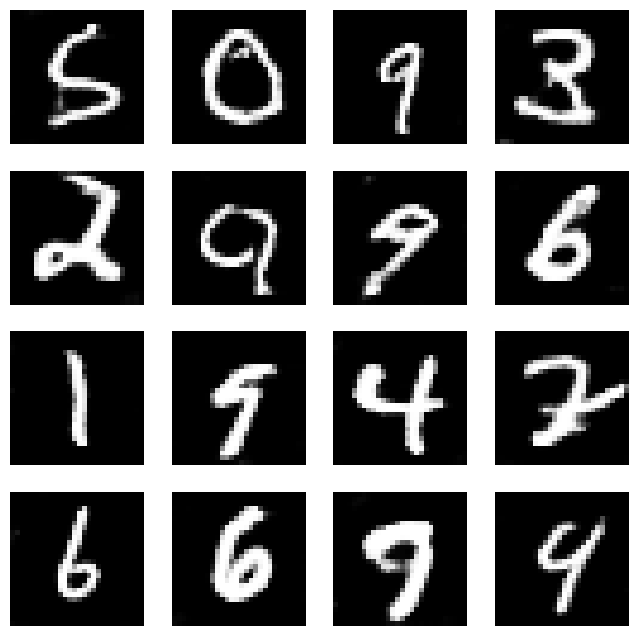

Epoch 79/185 (42.2%): [0/50048] (0.0%) D Error: 0.5380 G Error: 1.7286


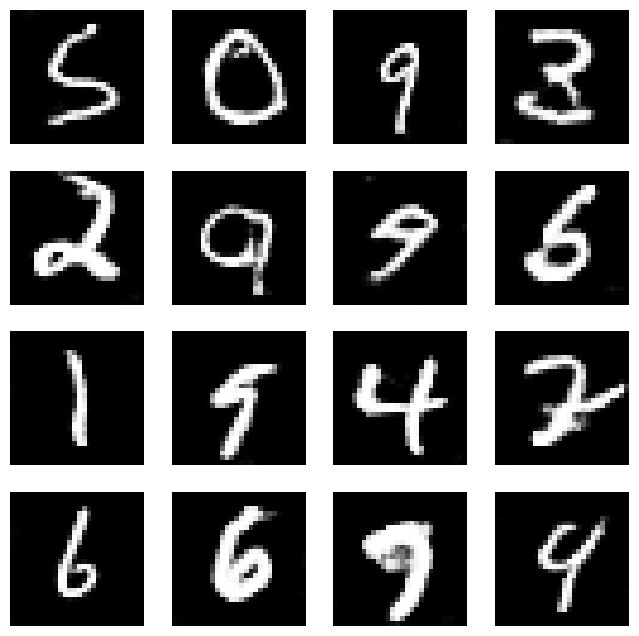

Epoch 80/185 (42.7%): [0/50048] (0.0%) D Error: 1.3675 G Error: 2.8311


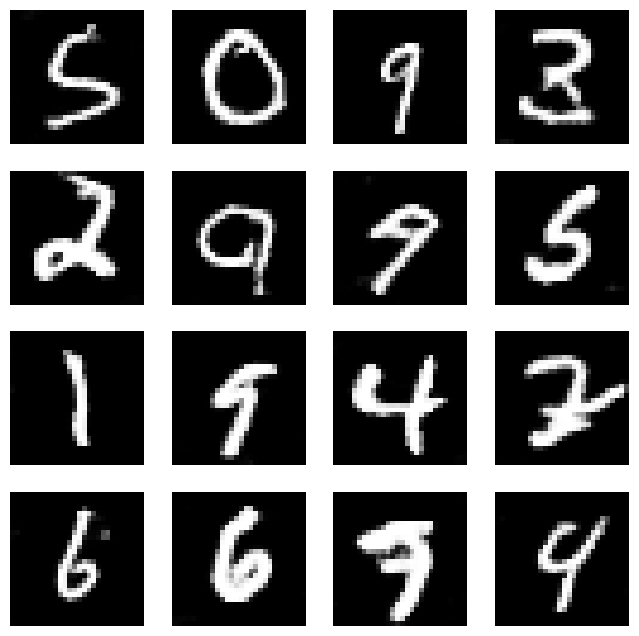

Epoch 81/185 (43.2%): [0/50048] (0.0%) D Error: 1.0185 G Error: 1.2036


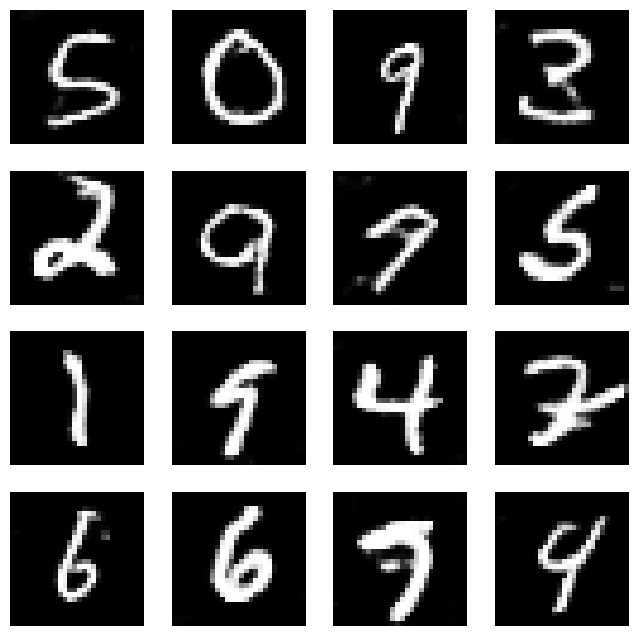

Epoch 82/185 (43.8%): [0/50048] (0.0%) D Error: 1.6930 G Error: 2.2372


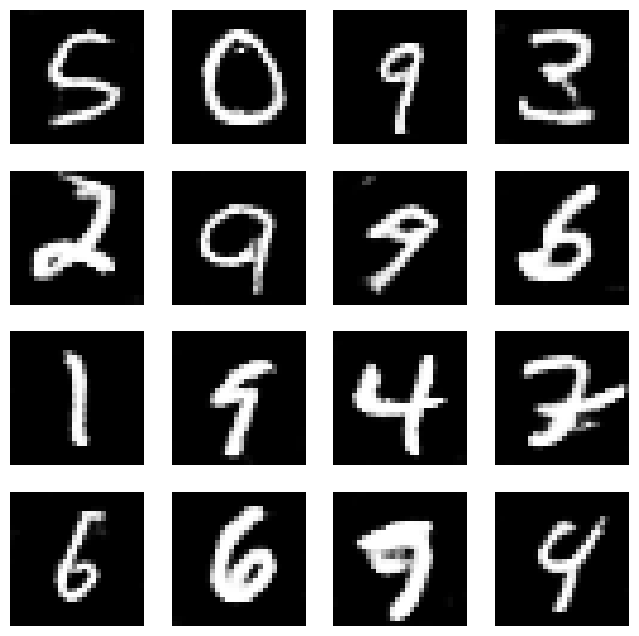

Epoch 83/185 (44.3%): [0/50048] (0.0%) D Error: 1.0484 G Error: 2.7706


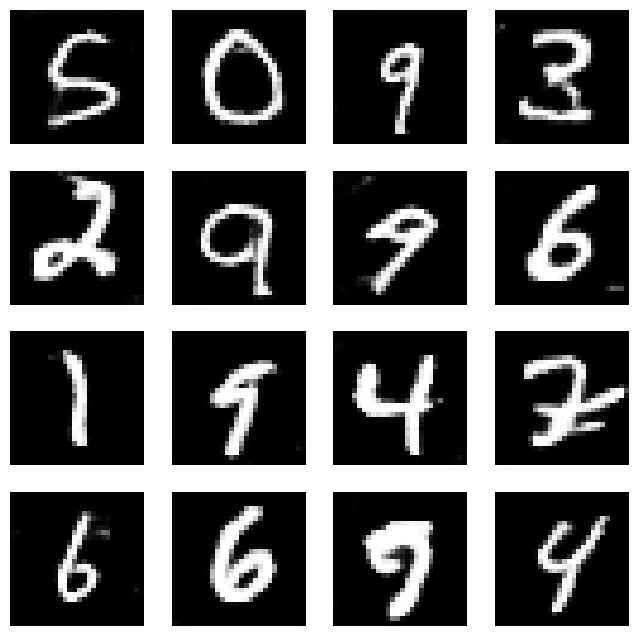

Epoch 84/185 (44.9%): [0/50048] (0.0%) D Error: 1.4016 G Error: 2.1233


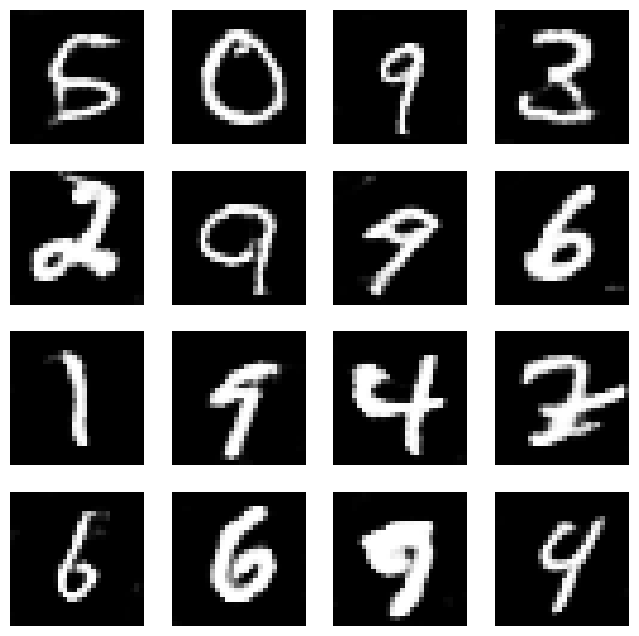

Epoch 85/185 (45.4%): [0/50048] (0.0%) D Error: 0.9103 G Error: 1.7573


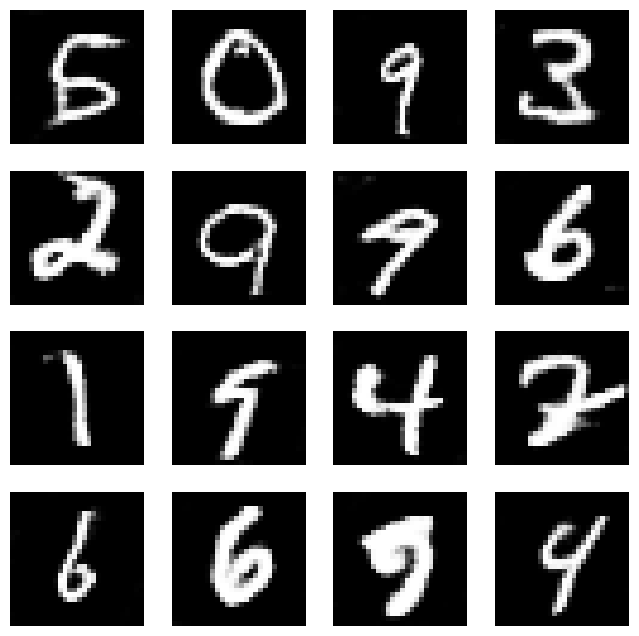

Epoch 86/185 (45.9%): [0/50048] (0.0%) D Error: 0.8682 G Error: 2.3850


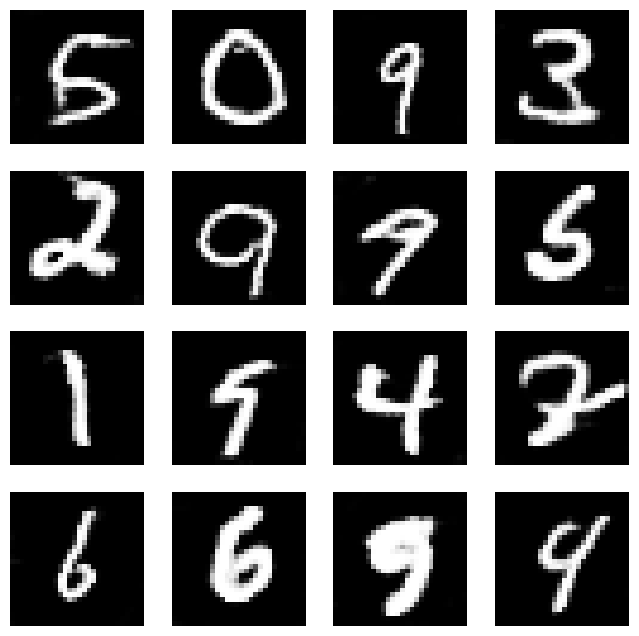

Epoch 87/185 (46.5%): [0/50048] (0.0%) D Error: 0.8807 G Error: 1.3663


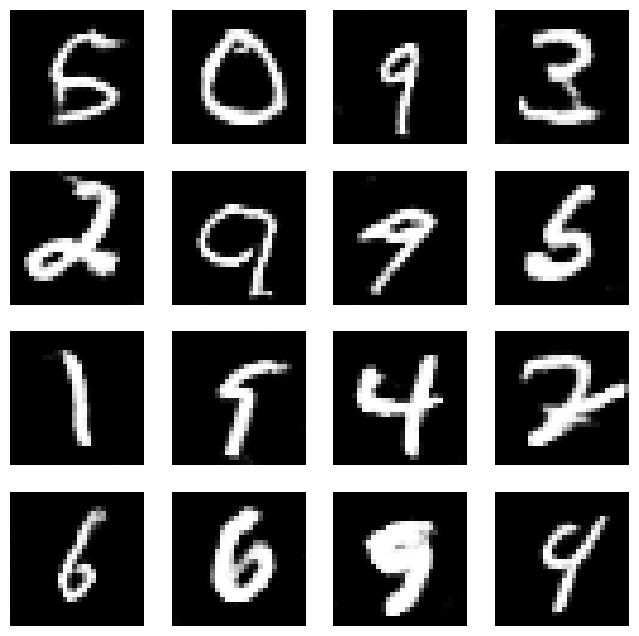

Epoch 88/185 (47.0%): [0/50048] (0.0%) D Error: 0.5931 G Error: 1.6956


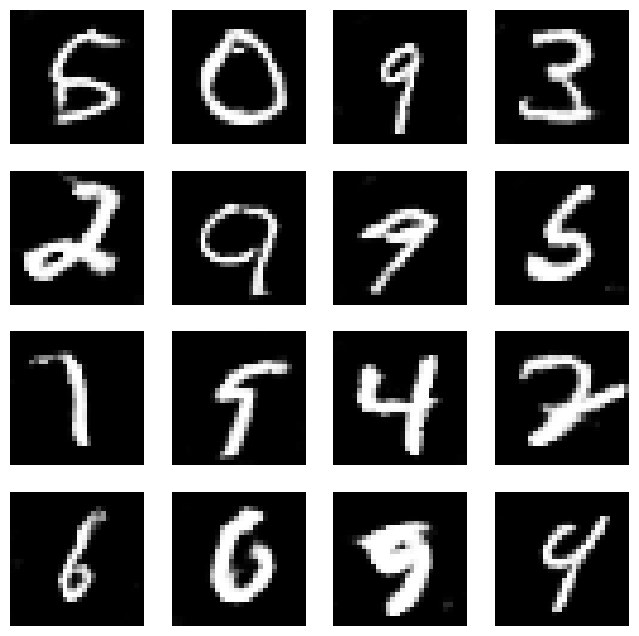

Epoch 89/185 (47.6%): [0/50048] (0.0%) D Error: 0.8294 G Error: 1.4368


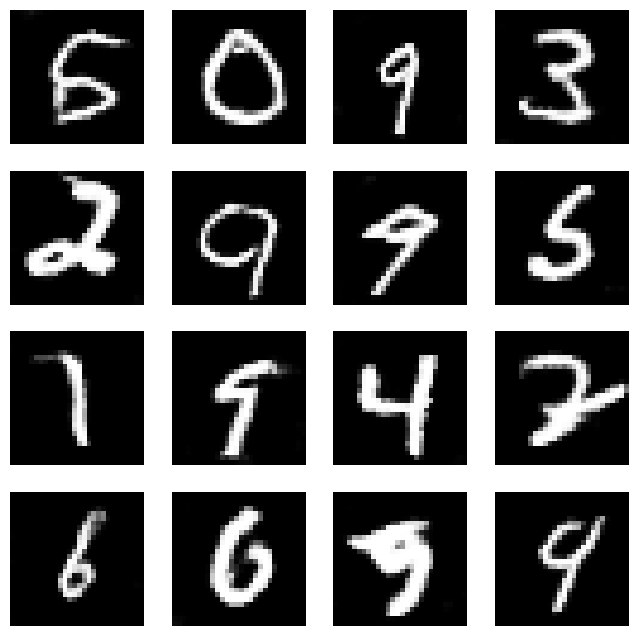

Epoch 90/185 (48.1%): [0/50048] (0.0%) D Error: 0.3097 G Error: 1.3823


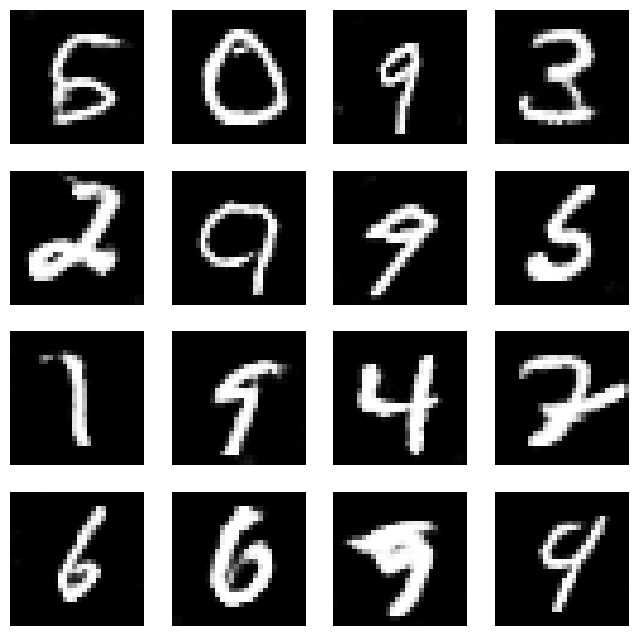

Epoch 91/185 (48.6%): [0/50048] (0.0%) D Error: 1.6036 G Error: 1.0262


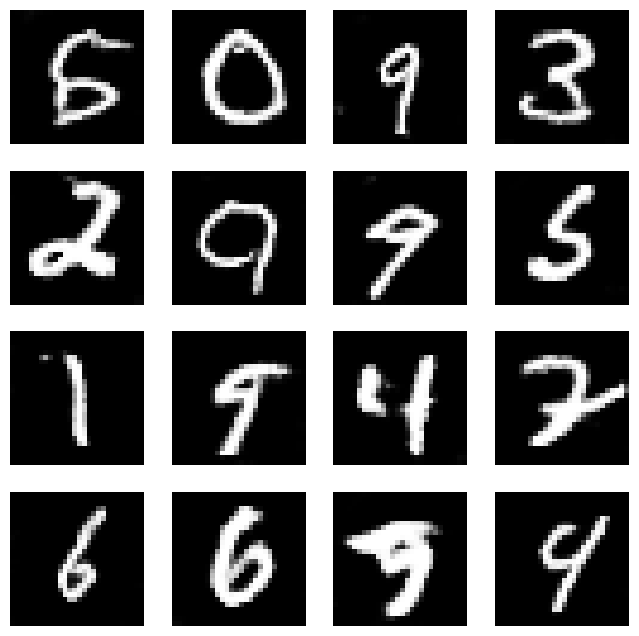

Epoch 92/185 (49.2%): [0/50048] (0.0%) D Error: 0.5148 G Error: 0.2347


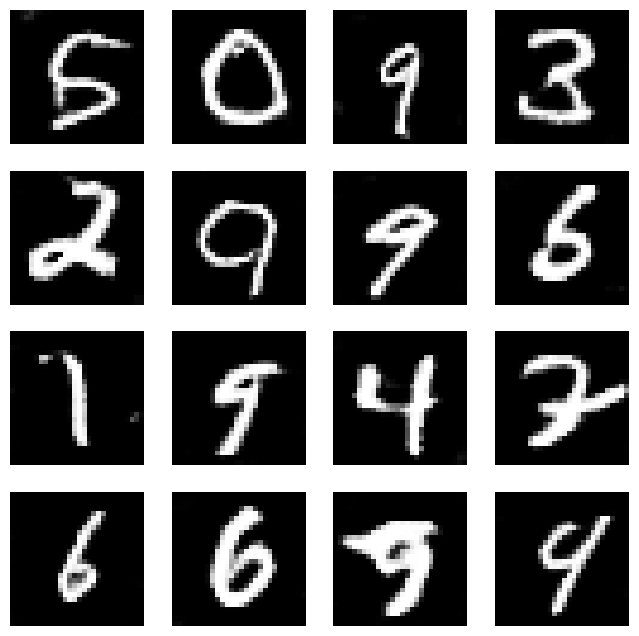

Epoch 93/185 (49.7%): [0/50048] (0.0%) D Error: 0.4751 G Error: 0.7331


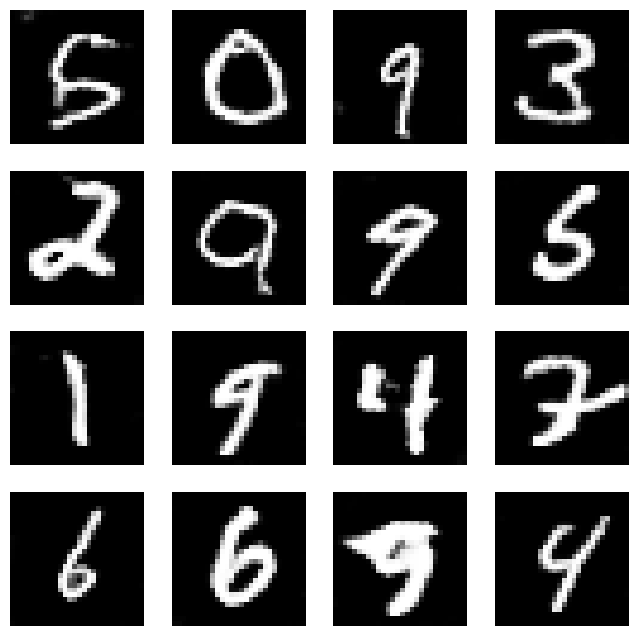

Epoch 94/185 (50.3%): [0/50048] (0.0%) D Error: 0.3559 G Error: 2.7805


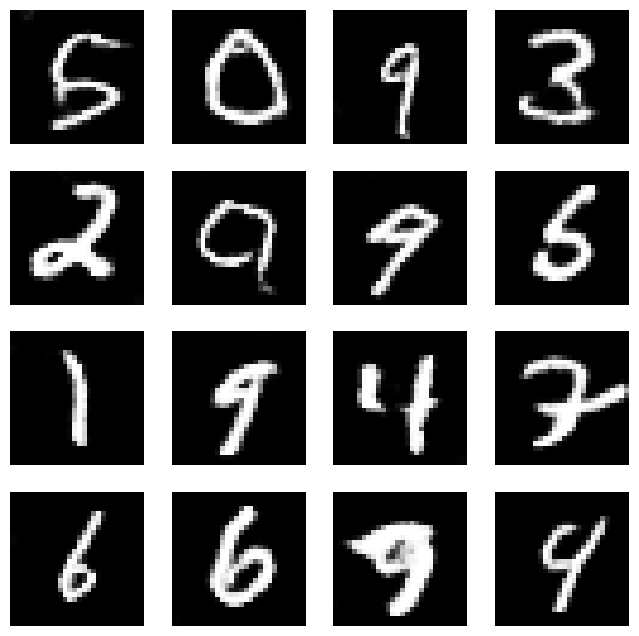

Epoch 95/185 (50.8%): [0/50048] (0.0%) D Error: 0.8718 G Error: 3.3340


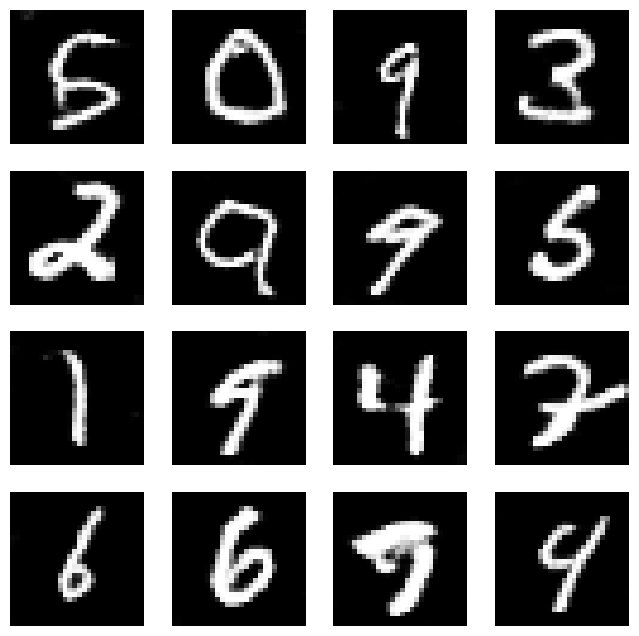

Epoch 96/185 (51.4%): [0/50048] (0.0%) D Error: 0.8937 G Error: 1.1253


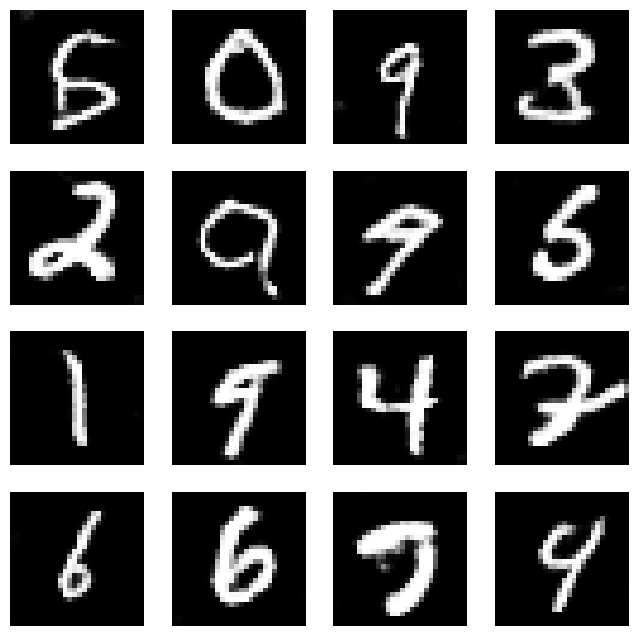

Epoch 97/185 (51.9%): [0/50048] (0.0%) D Error: 1.1754 G Error: 2.7713


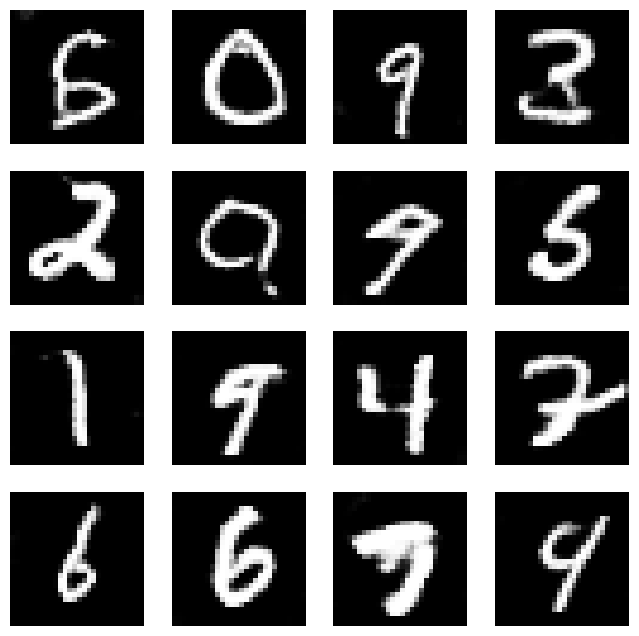

Epoch 98/185 (52.4%): [0/50048] (0.0%) D Error: 0.5163 G Error: 1.1448


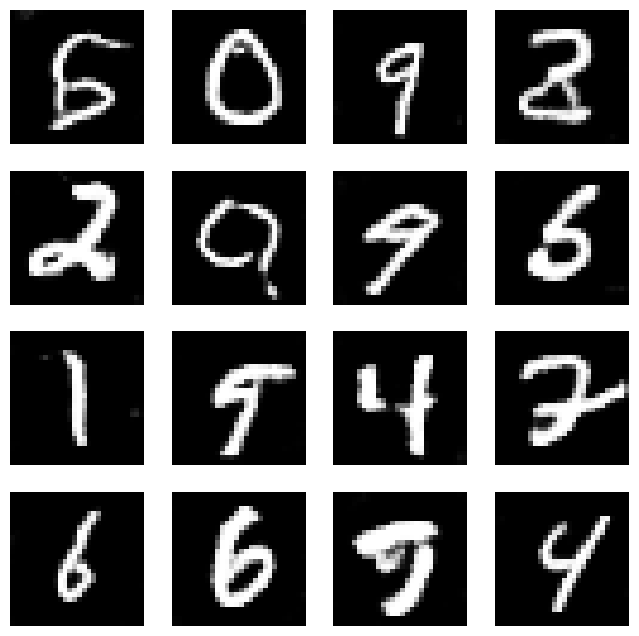

Epoch 99/185 (53.0%): [0/50048] (0.0%) D Error: 1.0091 G Error: 1.4502


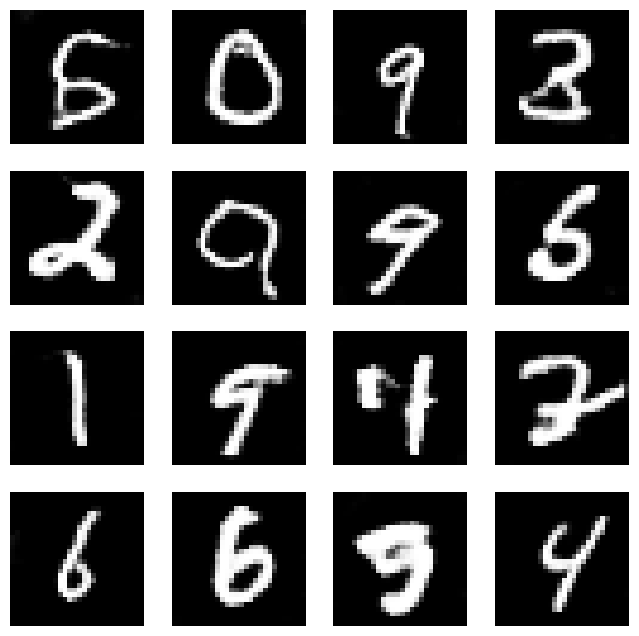

Epoch 100/185 (53.5%): [0/50048] (0.0%) D Error: 0.5390 G Error: 2.7512


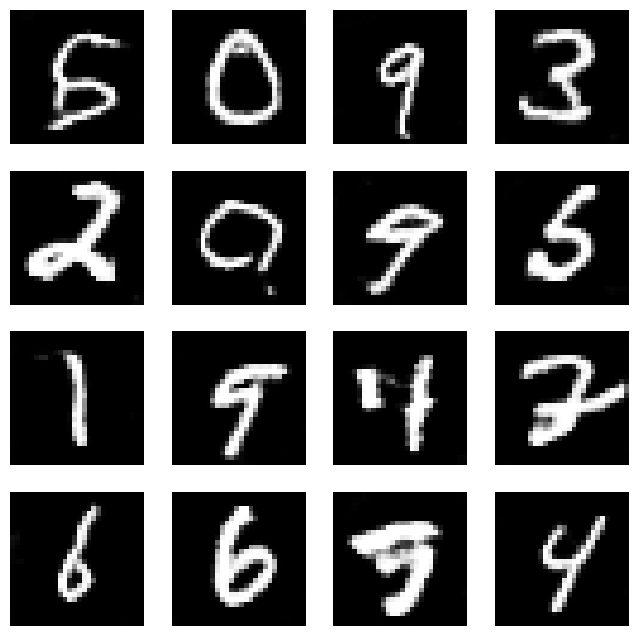

Epoch 101/185 (54.1%): [0/50048] (0.0%) D Error: 0.4942 G Error: 0.6497


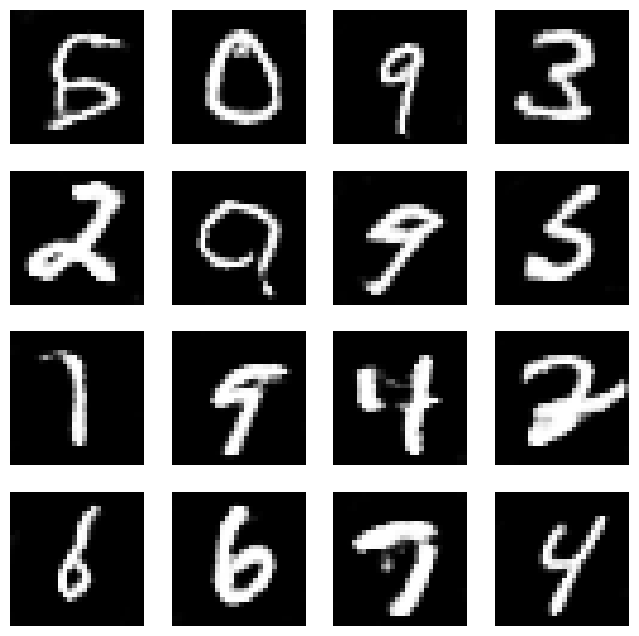

Epoch 102/185 (54.6%): [0/50048] (0.0%) D Error: 1.3224 G Error: 1.4188


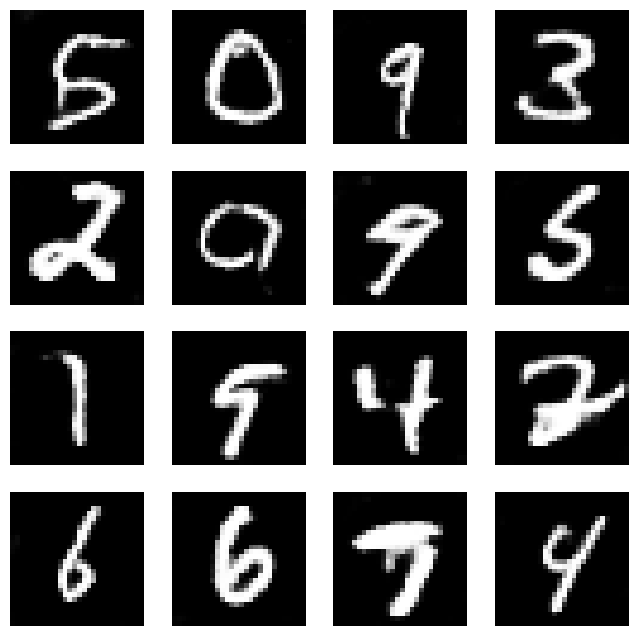

Epoch 103/185 (55.1%): [0/50048] (0.0%) D Error: 1.0918 G Error: 2.3895


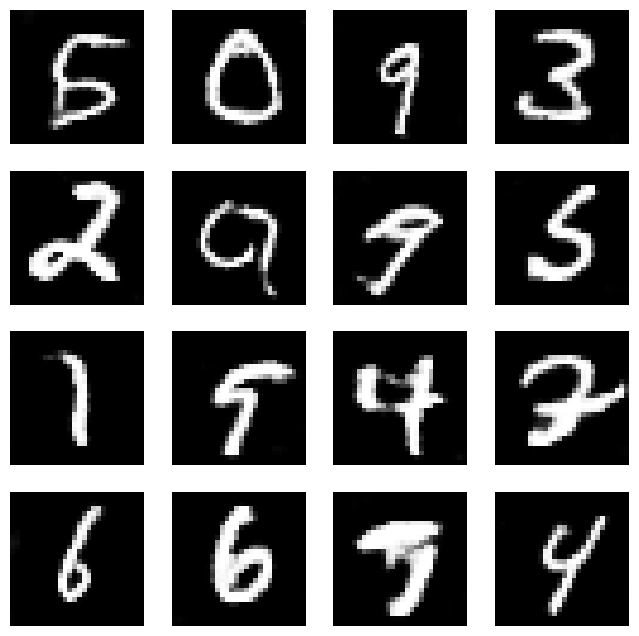

Epoch 104/185 (55.7%): [0/50048] (0.0%) D Error: 1.1363 G Error: 3.5777


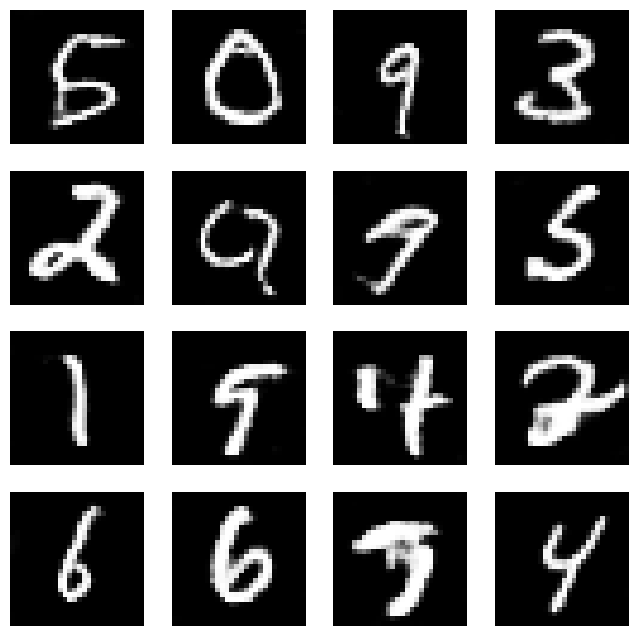

Epoch 105/185 (56.2%): [0/50048] (0.0%) D Error: 0.8598 G Error: 2.5389


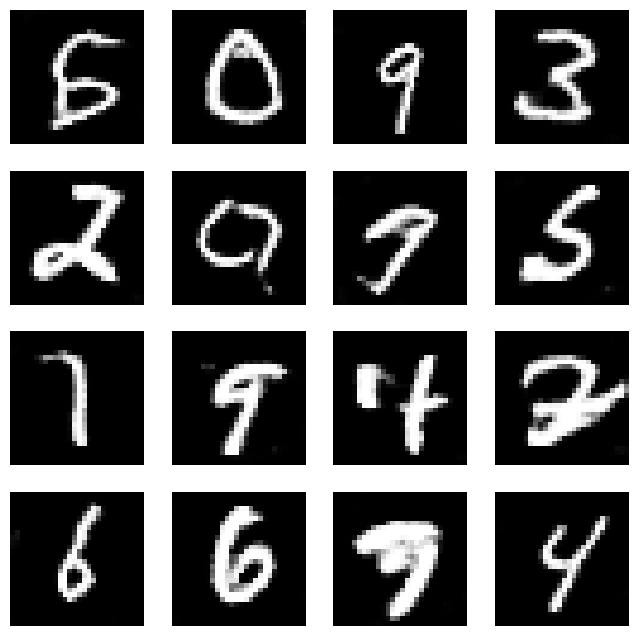

Epoch 106/185 (56.8%): [0/50048] (0.0%) D Error: 1.0840 G Error: 1.5991


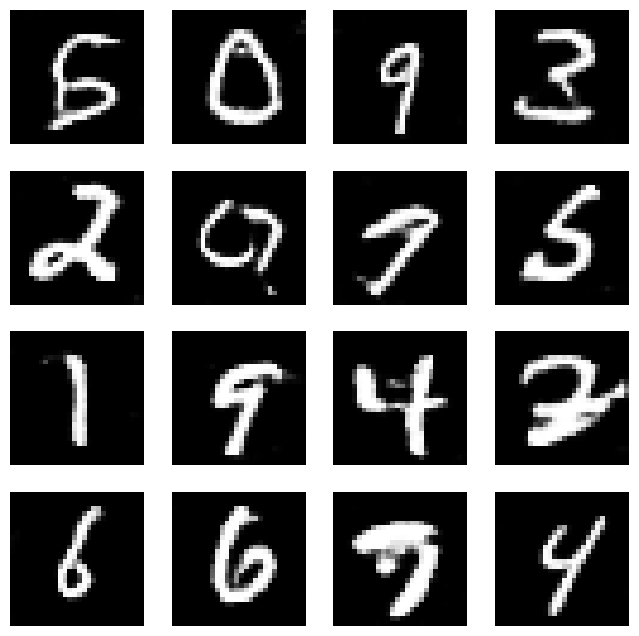

Epoch 107/185 (57.3%): [0/50048] (0.0%) D Error: 0.4379 G Error: 2.4118


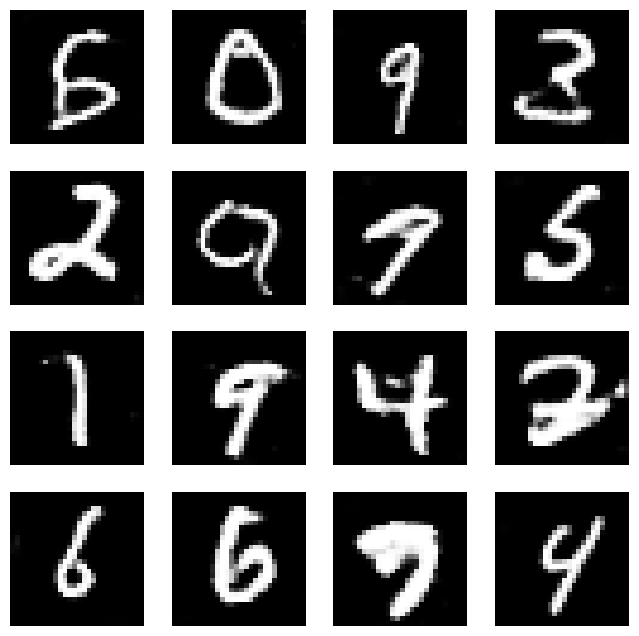

Epoch 108/185 (57.8%): [0/50048] (0.0%) D Error: 0.5989 G Error: 3.6272


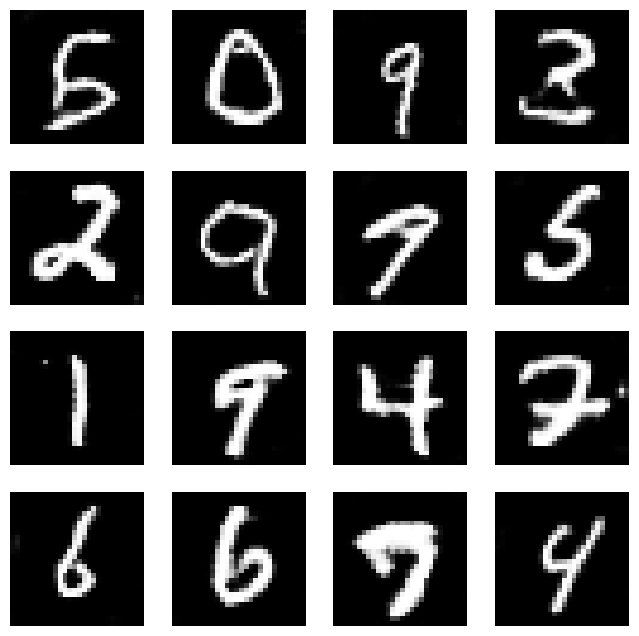

Epoch 109/185 (58.4%): [0/50048] (0.0%) D Error: 0.8155 G Error: 1.7056


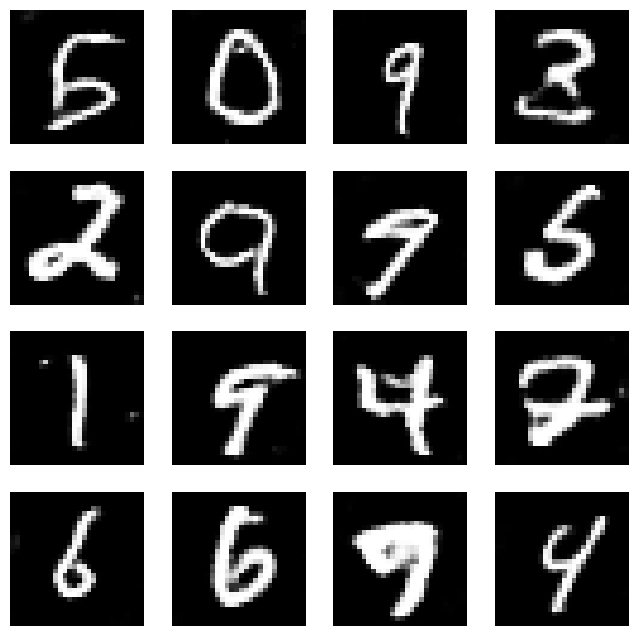

Epoch 110/185 (58.9%): [0/50048] (0.0%) D Error: 0.8455 G Error: 2.5562


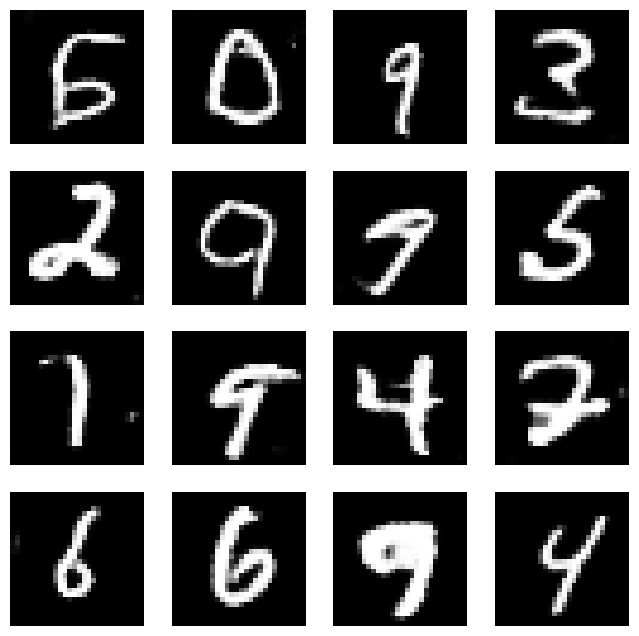

Epoch 111/185 (59.5%): [0/50048] (0.0%) D Error: 0.4562 G Error: 2.2826


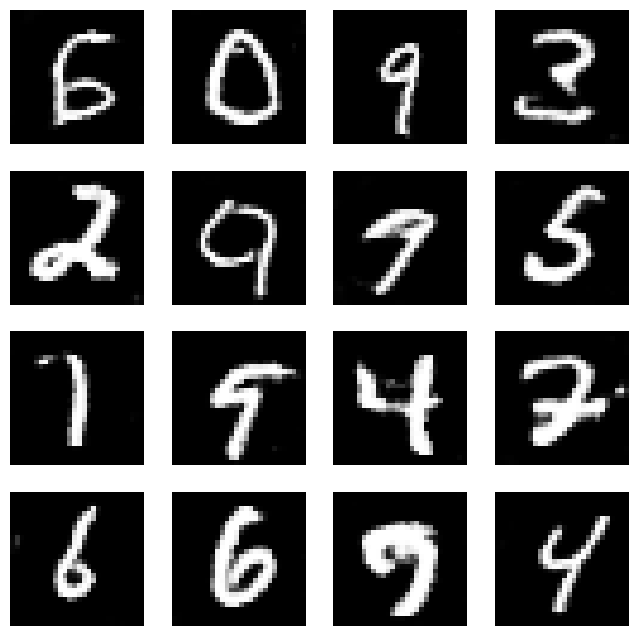

Epoch 112/185 (60.0%): [0/50048] (0.0%) D Error: 1.0390 G Error: 1.0259


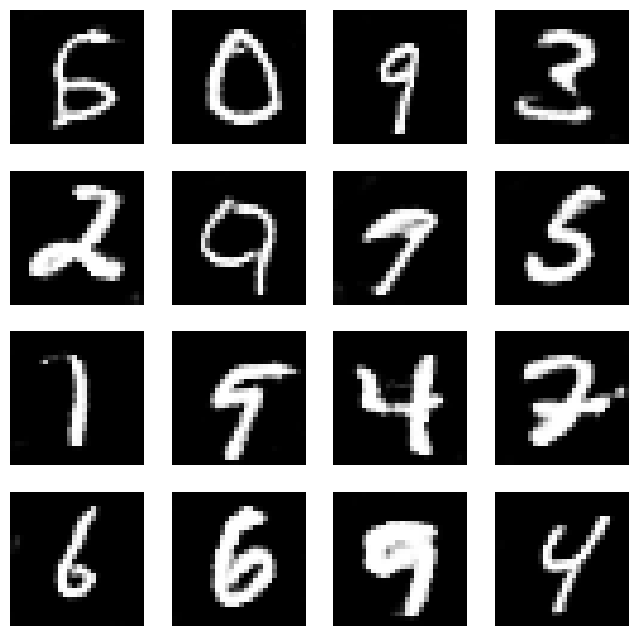

Epoch 113/185 (60.5%): [0/50048] (0.0%) D Error: 0.5370 G Error: 1.4206


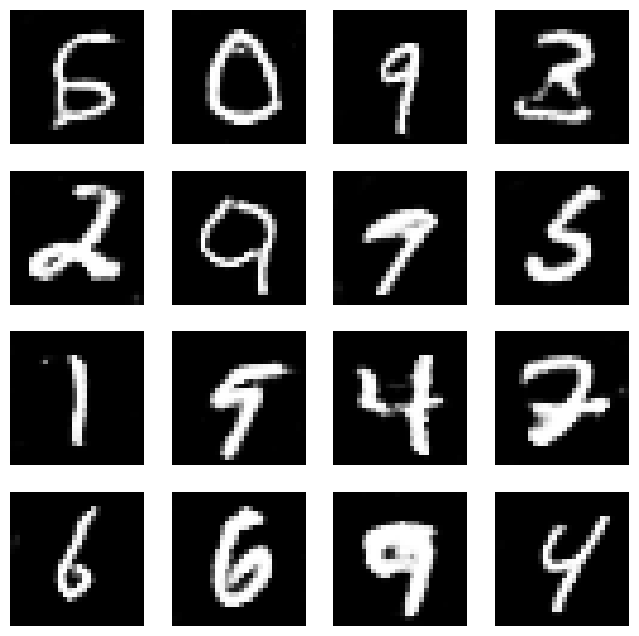

Epoch 114/185 (61.1%): [0/50048] (0.0%) D Error: 0.7471 G Error: 1.5859


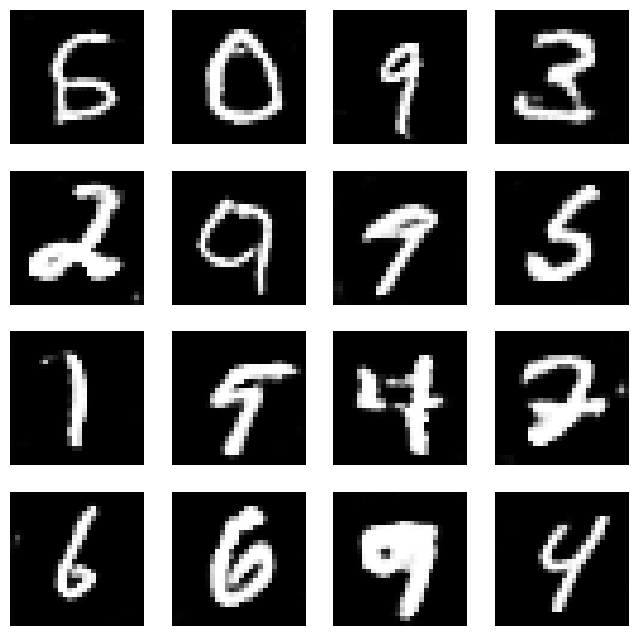

Epoch 115/185 (61.6%): [0/50048] (0.0%) D Error: 0.4427 G Error: 4.5761


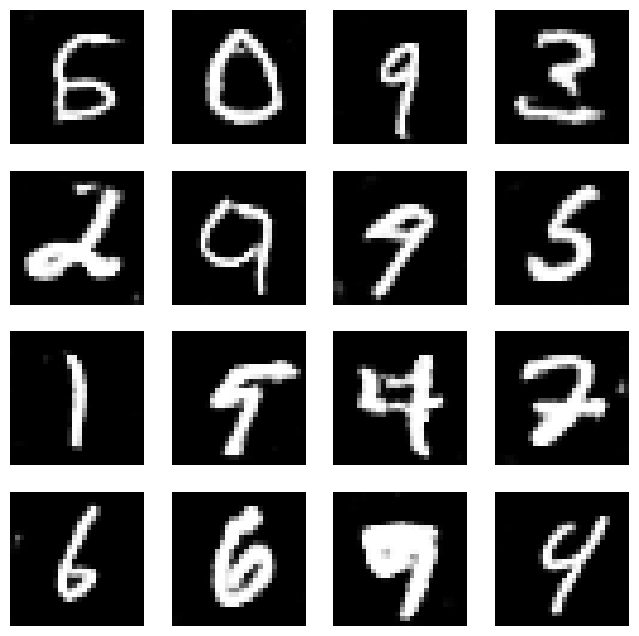

Epoch 116/185 (62.2%): [0/50048] (0.0%) D Error: 0.6357 G Error: 1.7725


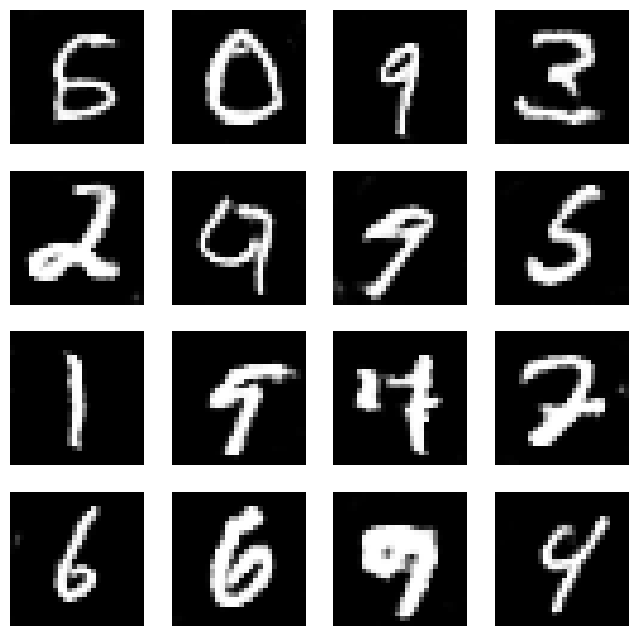

Epoch 117/185 (62.7%): [0/50048] (0.0%) D Error: 1.6363 G Error: 2.9727


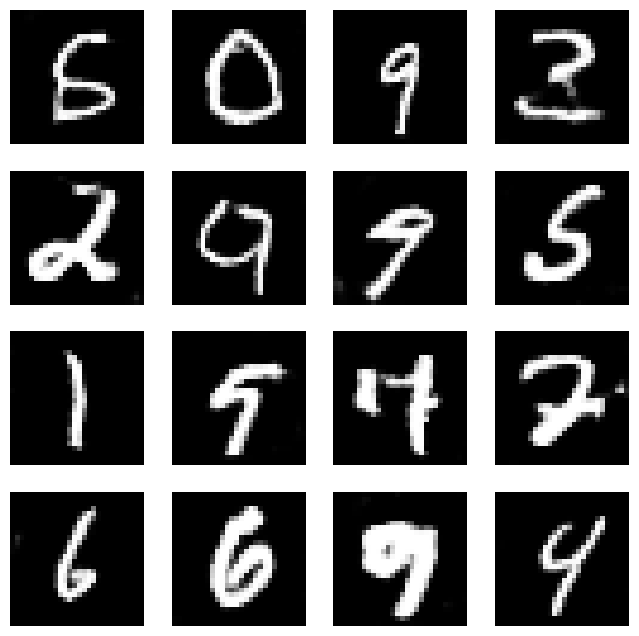

Epoch 118/185 (63.2%): [0/50048] (0.0%) D Error: 0.4157 G Error: 2.5918


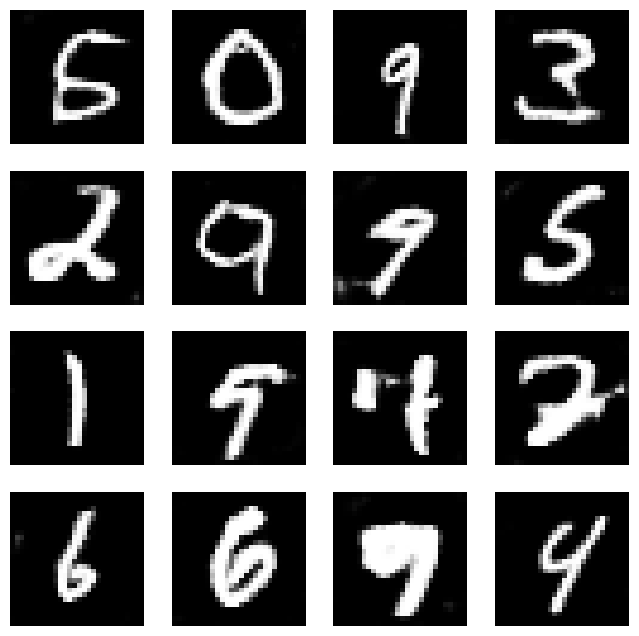

Epoch 119/185 (63.8%): [0/50048] (0.0%) D Error: 0.8870 G Error: 1.8687


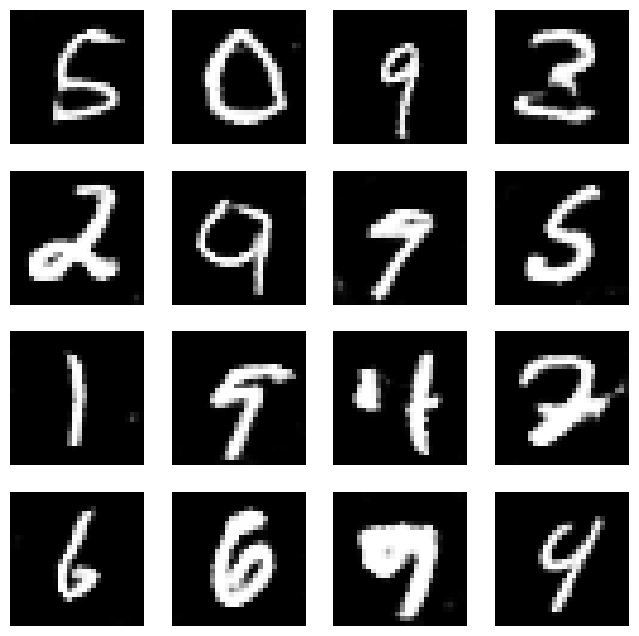

Epoch 120/185 (64.3%): [0/50048] (0.0%) D Error: 0.8603 G Error: 1.9669


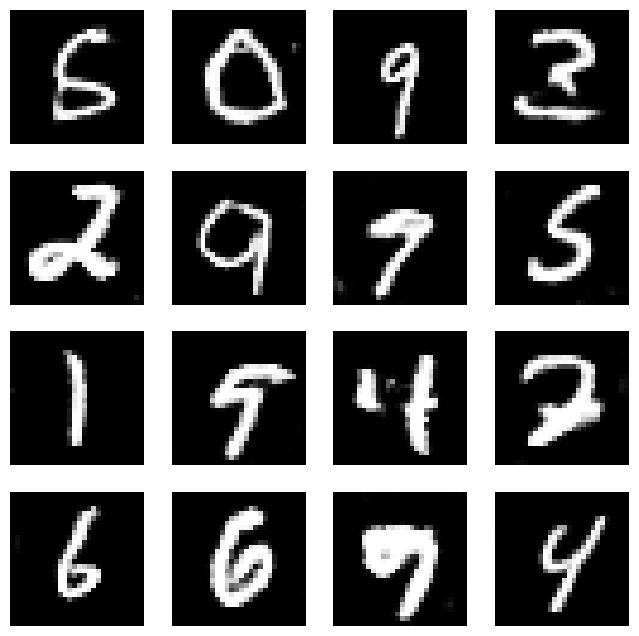

Epoch 121/185 (64.9%): [0/50048] (0.0%) D Error: 0.8356 G Error: 3.4133


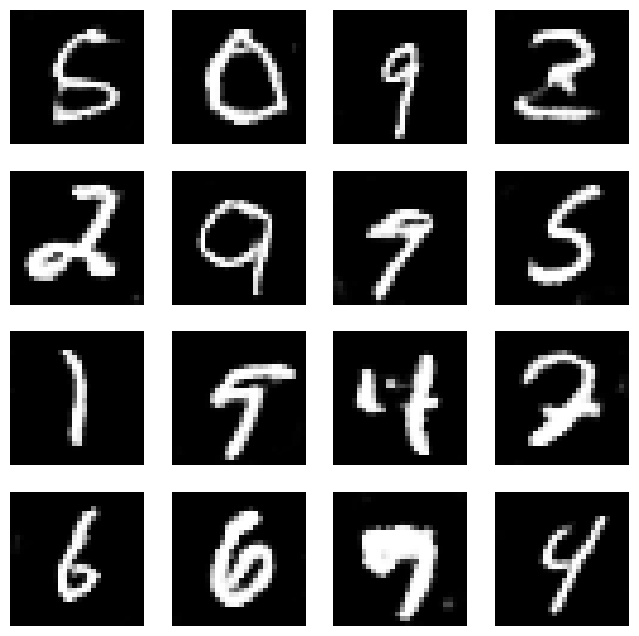

Epoch 122/185 (65.4%): [0/50048] (0.0%) D Error: 0.9186 G Error: 2.1295


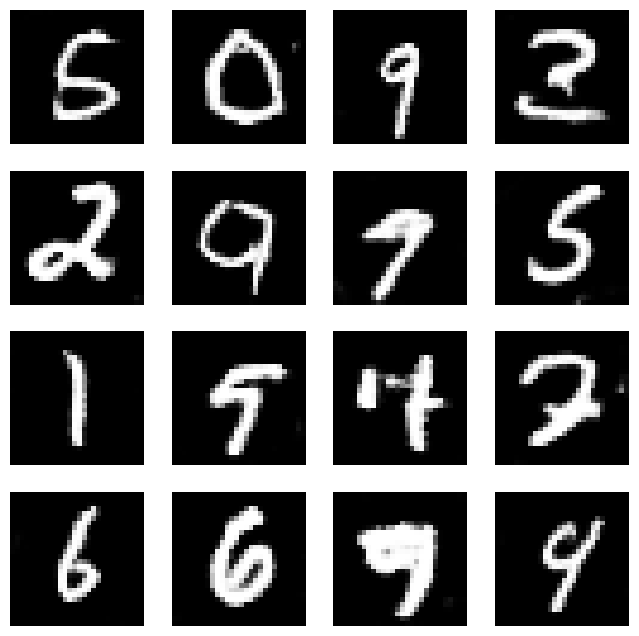

Epoch 123/185 (65.9%): [0/50048] (0.0%) D Error: 1.1299 G Error: 1.6948


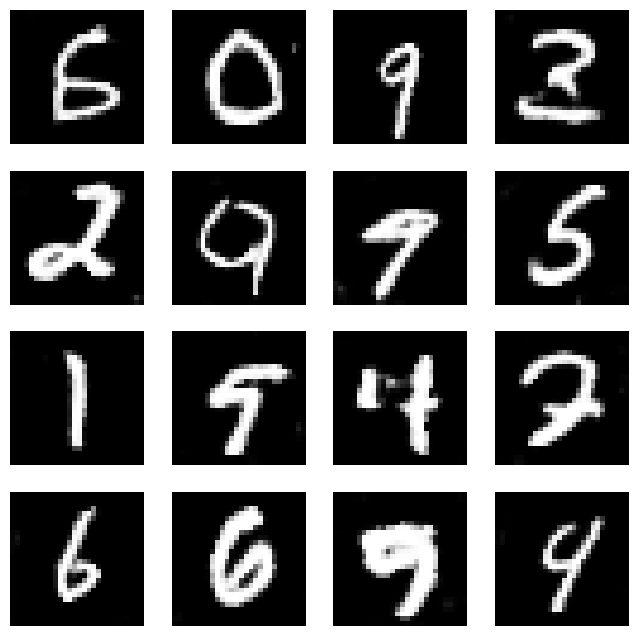

Epoch 124/185 (66.5%): [0/50048] (0.0%) D Error: 0.6320 G Error: 0.2534


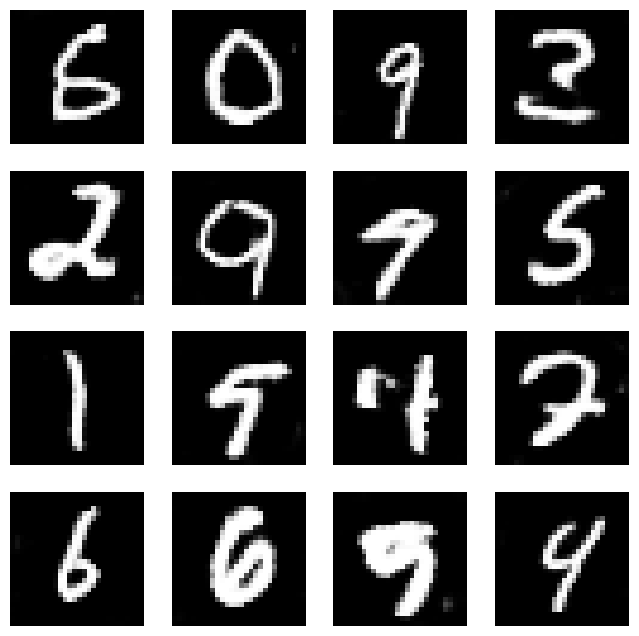

Epoch 125/185 (67.0%): [0/50048] (0.0%) D Error: 0.6185 G Error: 1.4563


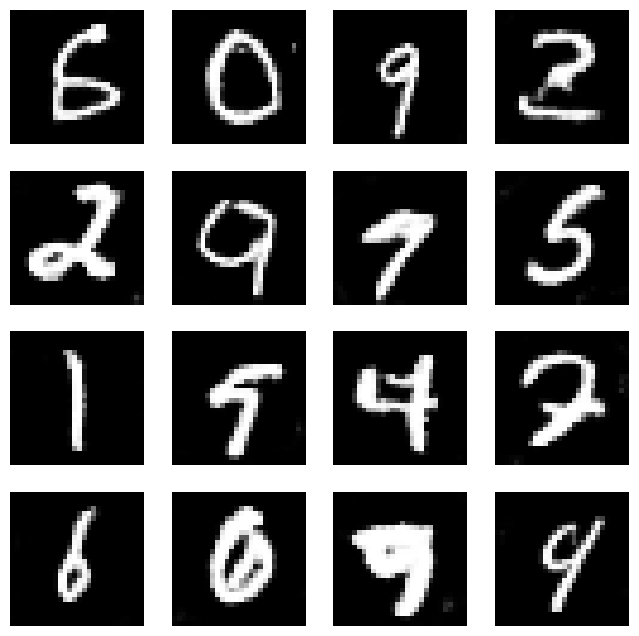

Epoch 126/185 (67.6%): [0/50048] (0.0%) D Error: 1.5274 G Error: 1.8620


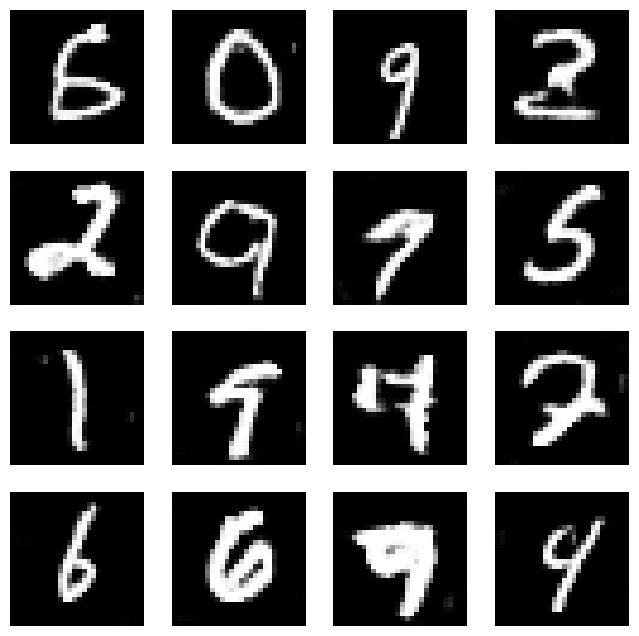

Epoch 127/185 (68.1%): [0/50048] (0.0%) D Error: 0.6124 G Error: 0.9533


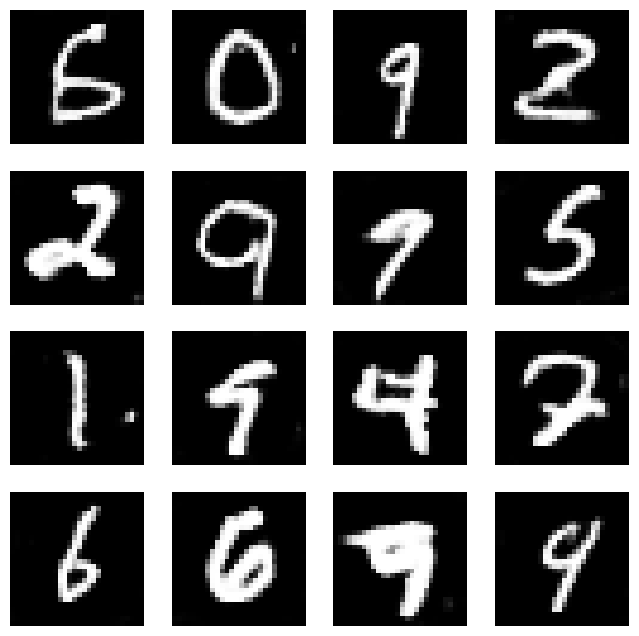

Epoch 128/185 (68.6%): [0/50048] (0.0%) D Error: 0.4875 G Error: 1.9913


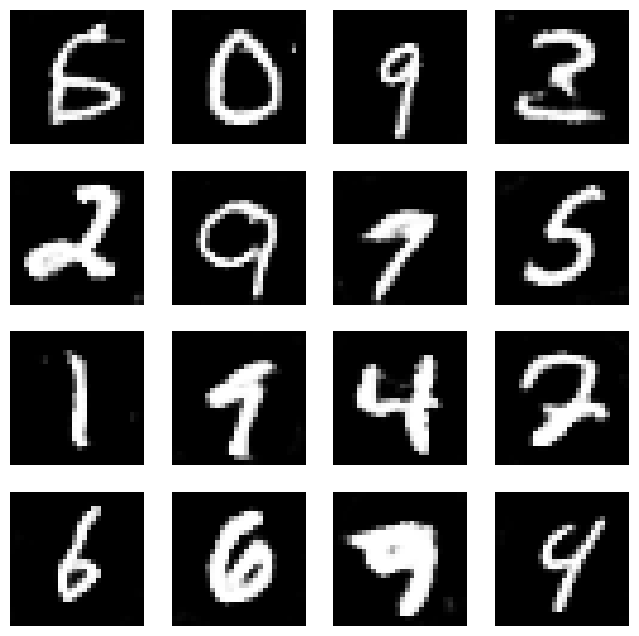

Epoch 129/185 (69.2%): [0/50048] (0.0%) D Error: 1.0228 G Error: 2.2046


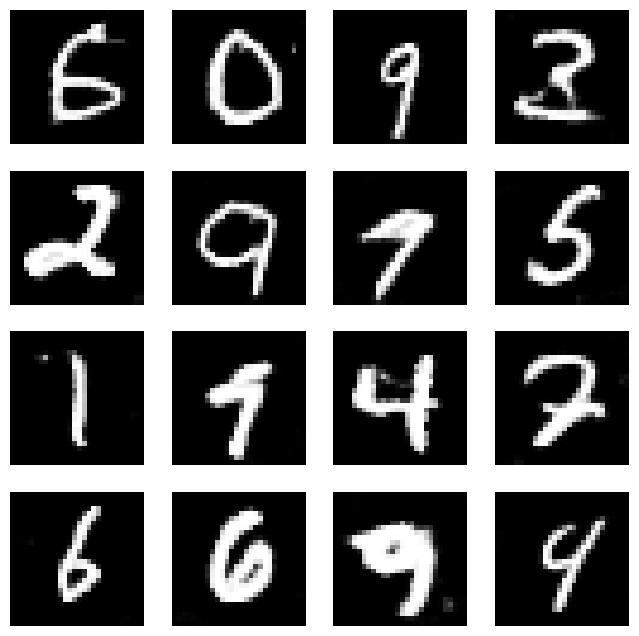

Epoch 130/185 (69.7%): [0/50048] (0.0%) D Error: 0.3995 G Error: 1.9148


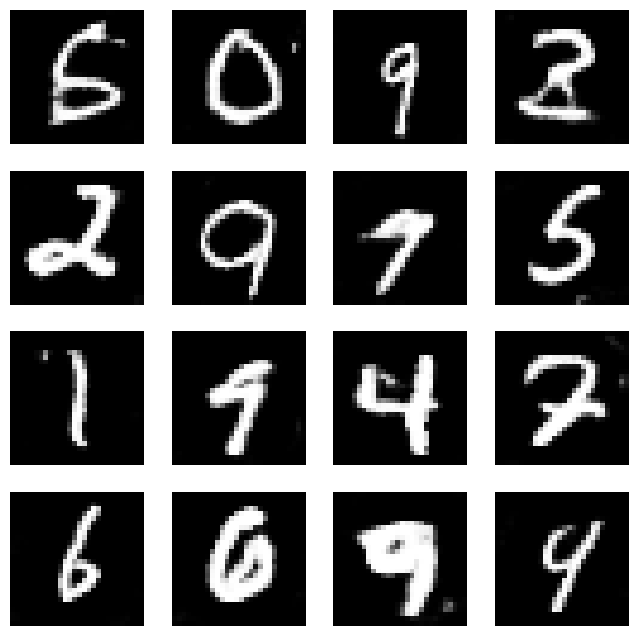

Epoch 131/185 (70.3%): [0/50048] (0.0%) D Error: 1.2395 G Error: 0.7362


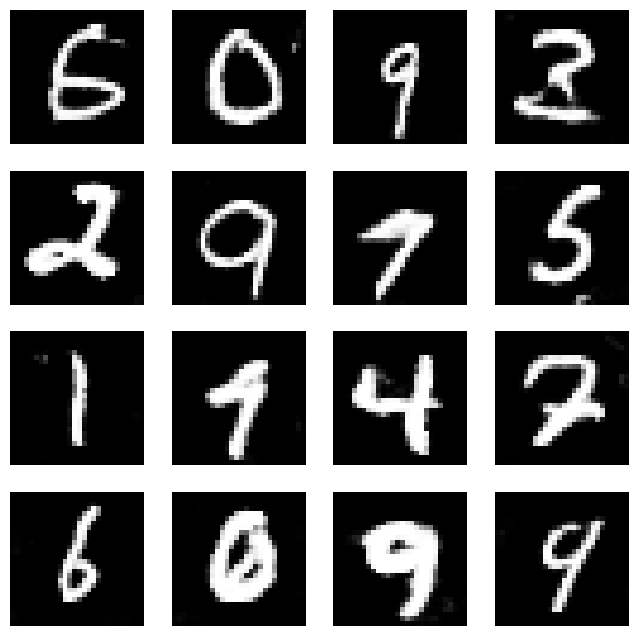

Epoch 132/185 (70.8%): [0/50048] (0.0%) D Error: 0.7699 G Error: 1.4196


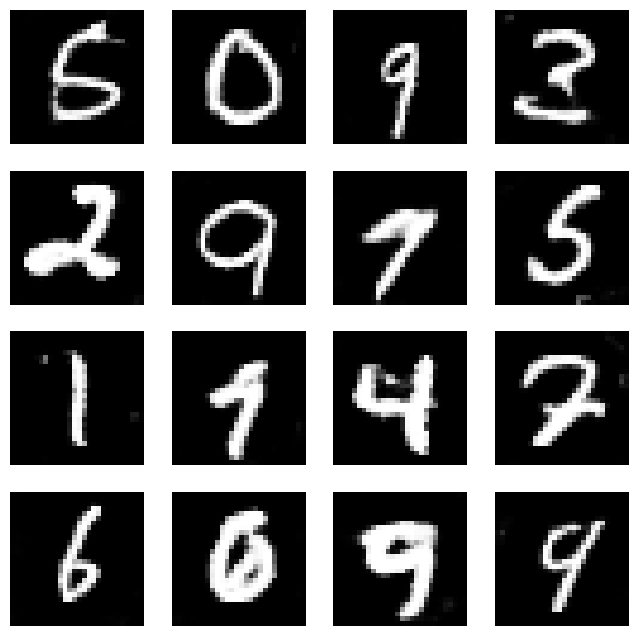

Epoch 133/185 (71.4%): [0/50048] (0.0%) D Error: 0.9050 G Error: 1.7487


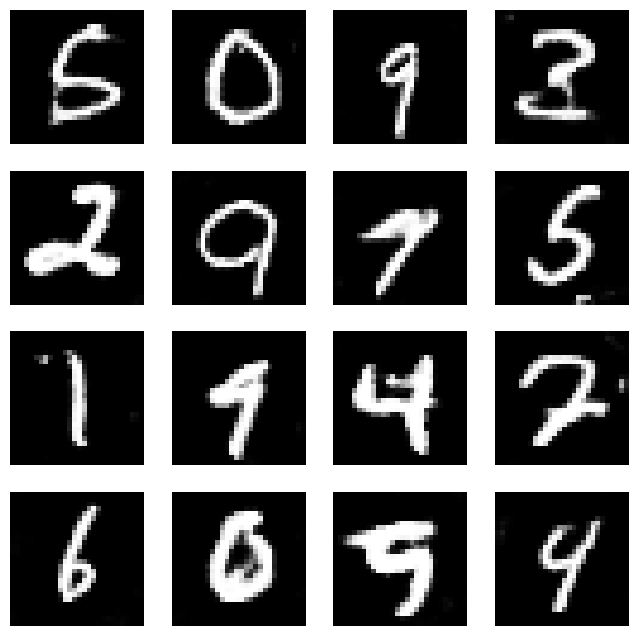

Epoch 134/185 (71.9%): [0/50048] (0.0%) D Error: 0.6169 G Error: 3.4105


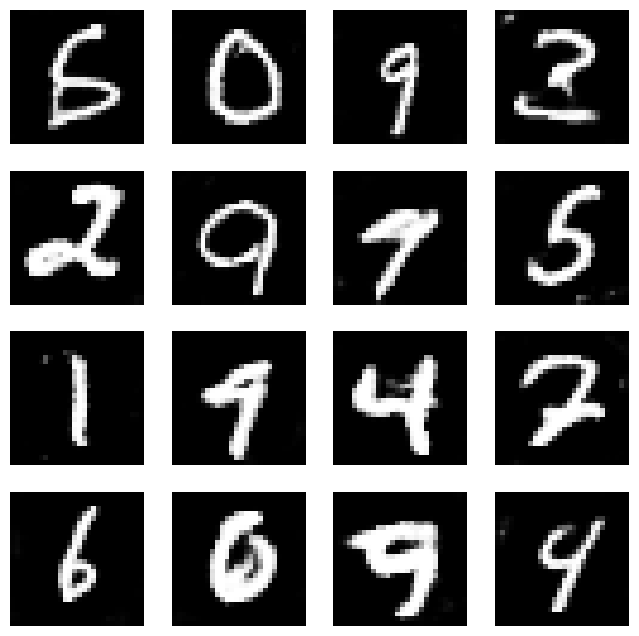

Epoch 135/185 (72.4%): [0/50048] (0.0%) D Error: 0.7236 G Error: 1.2147


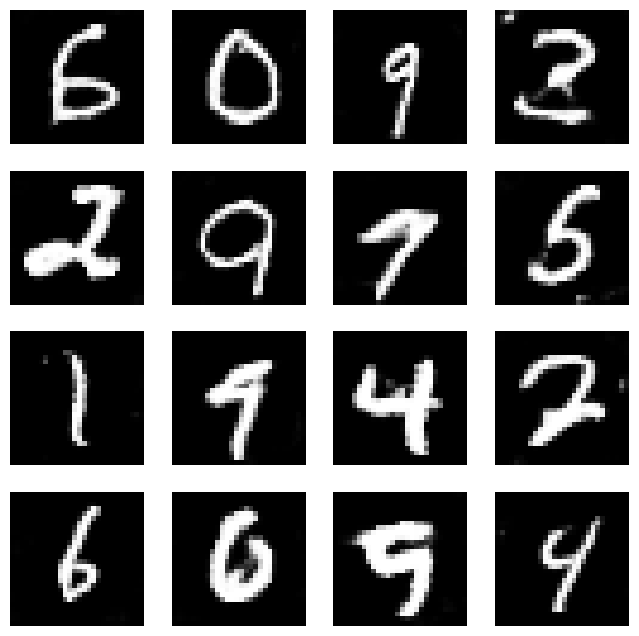

Epoch 136/185 (73.0%): [0/50048] (0.0%) D Error: 0.8689 G Error: 0.9309


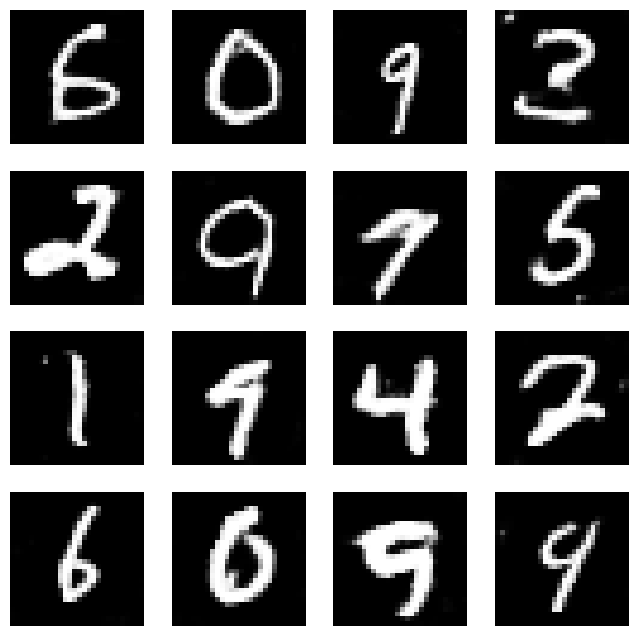

Epoch 137/185 (73.5%): [0/50048] (0.0%) D Error: 0.4130 G Error: 1.1180


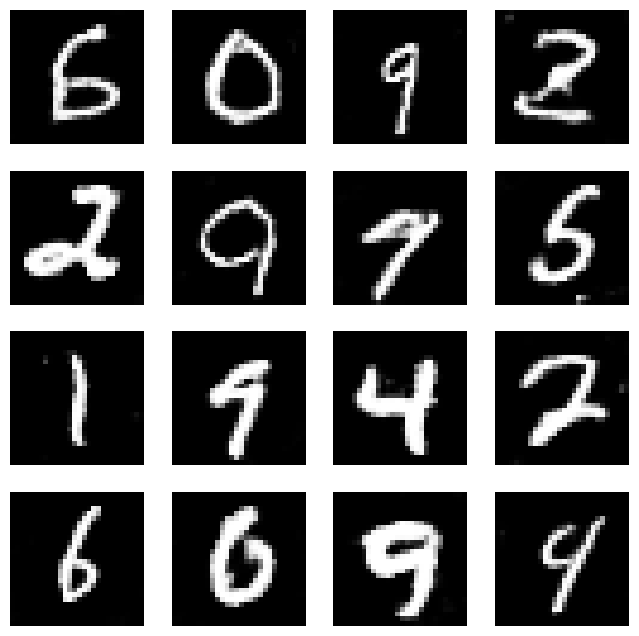

Epoch 138/185 (74.1%): [0/50048] (0.0%) D Error: 1.0403 G Error: 1.6227


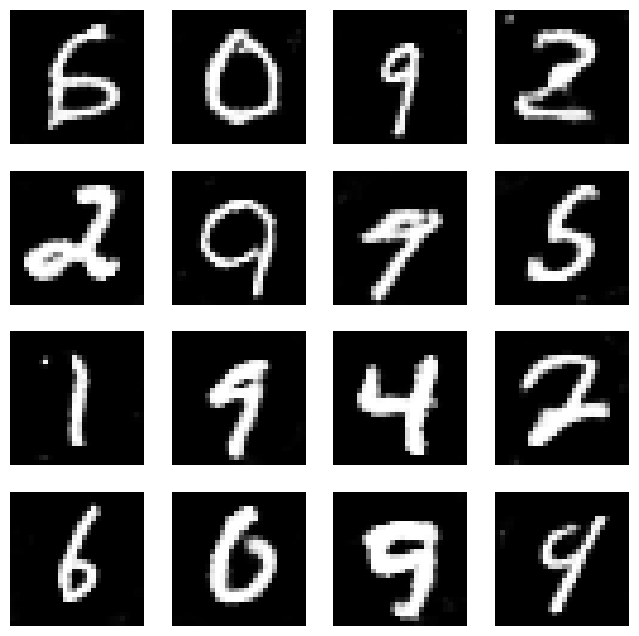

Epoch 139/185 (74.6%): [0/50048] (0.0%) D Error: 0.3255 G Error: 1.8508


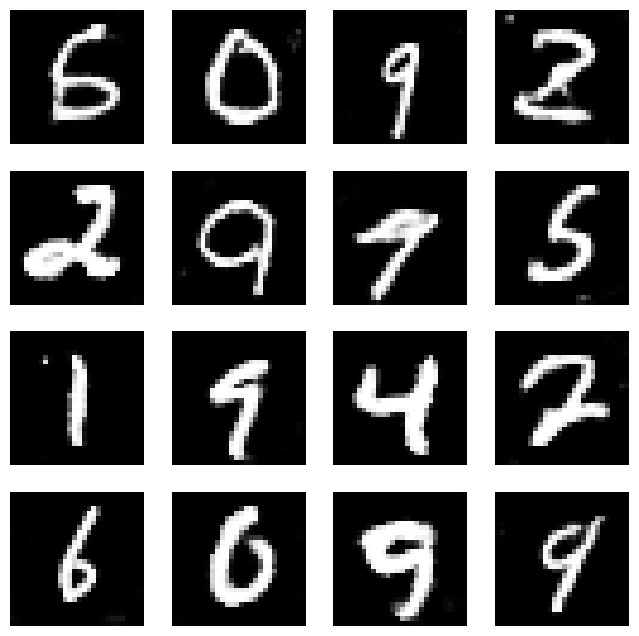

Epoch 140/185 (75.1%): [0/50048] (0.0%) D Error: 0.7704 G Error: 0.5817


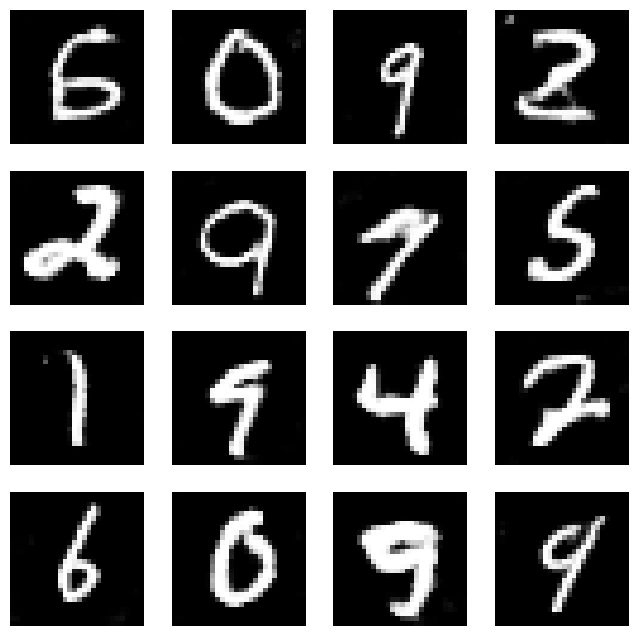

Epoch 141/185 (75.7%): [0/50048] (0.0%) D Error: 0.5891 G Error: 0.9464


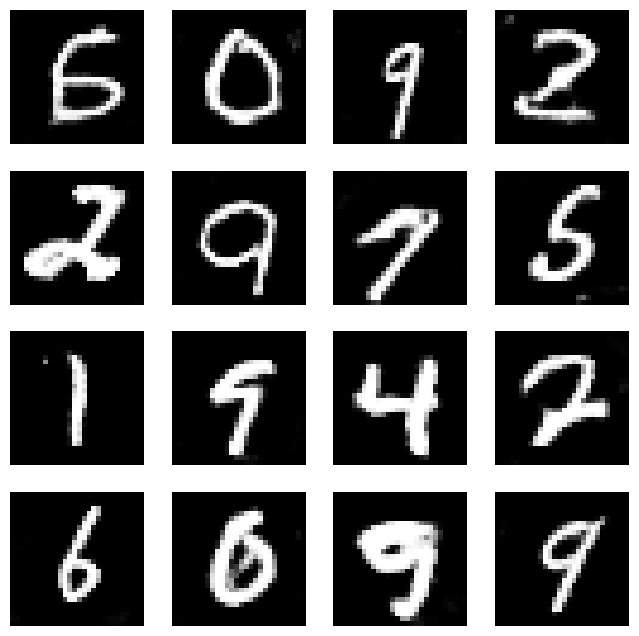

Epoch 142/185 (76.2%): [0/50048] (0.0%) D Error: 0.4080 G Error: 0.8191


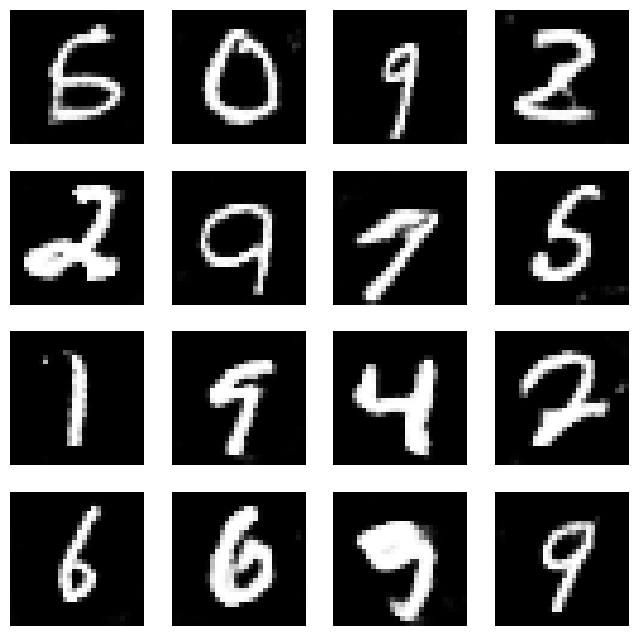

Epoch 143/185 (76.8%): [0/50048] (0.0%) D Error: 0.8365 G Error: 1.6871


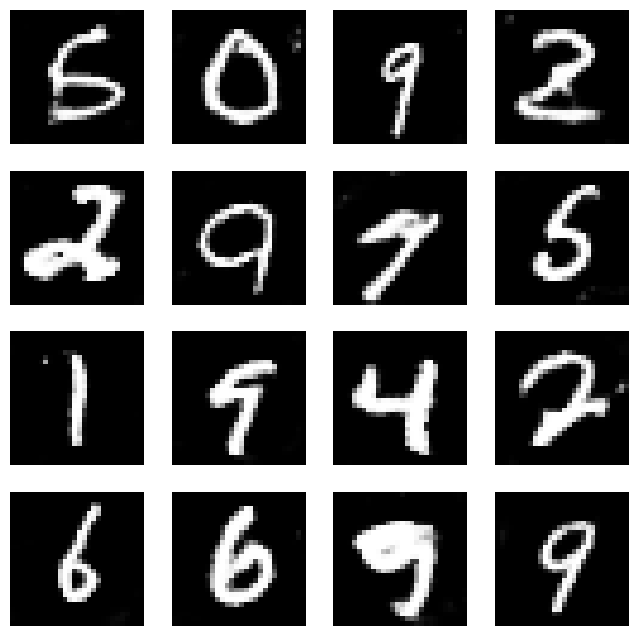

Epoch 144/185 (77.3%): [0/50048] (0.0%) D Error: 0.7643 G Error: 0.9550


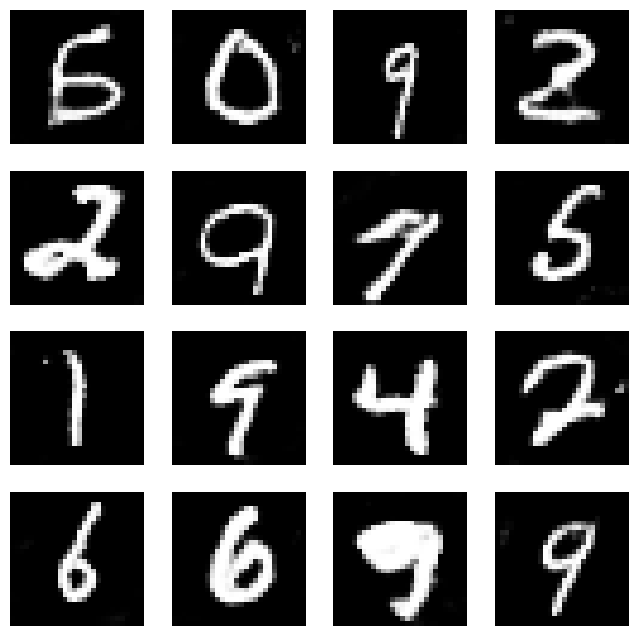

Epoch 145/185 (77.8%): [0/50048] (0.0%) D Error: 1.0978 G Error: 3.4599


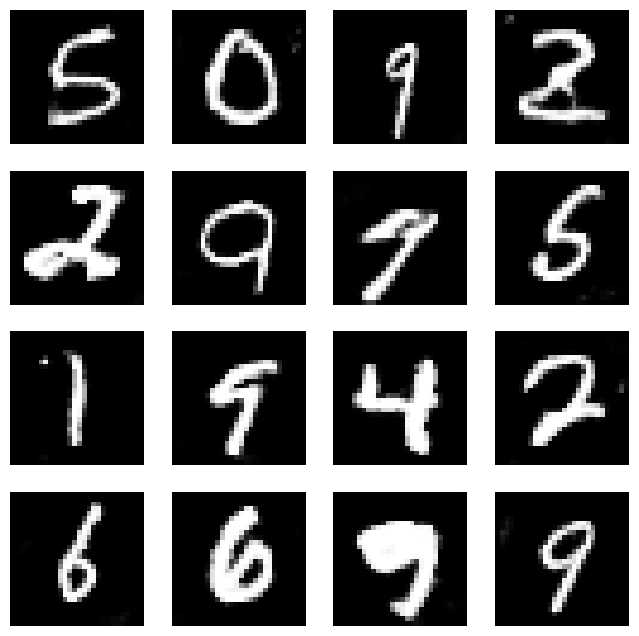

Epoch 146/185 (78.4%): [0/50048] (0.0%) D Error: 0.3775 G Error: 2.1500


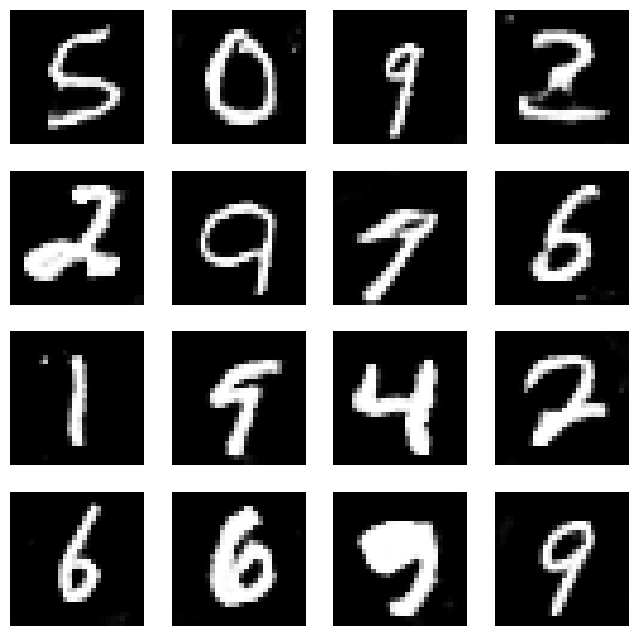

Epoch 147/185 (78.9%): [0/50048] (0.0%) D Error: 0.7643 G Error: 1.8215


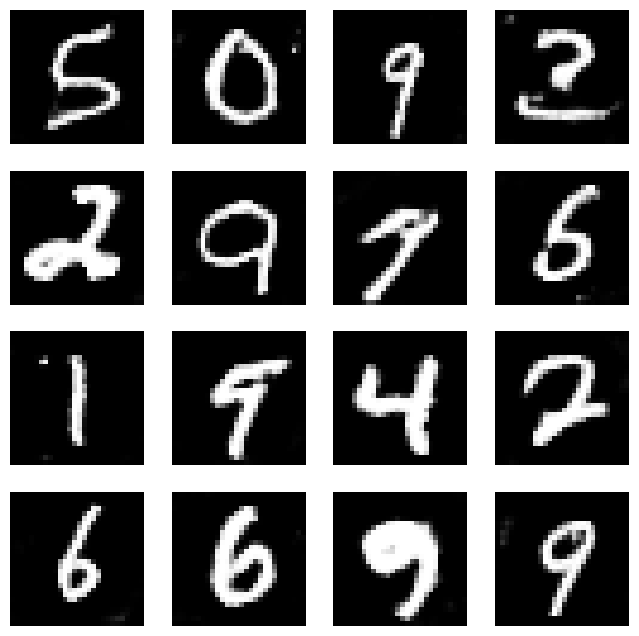

Epoch 148/185 (79.5%): [0/50048] (0.0%) D Error: 0.3455 G Error: 3.3763


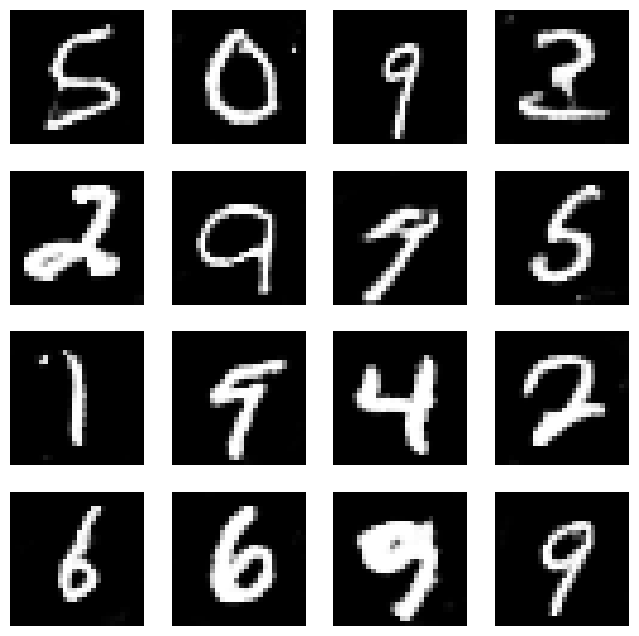

Epoch 149/185 (80.0%): [0/50048] (0.0%) D Error: 0.8360 G Error: 2.3574


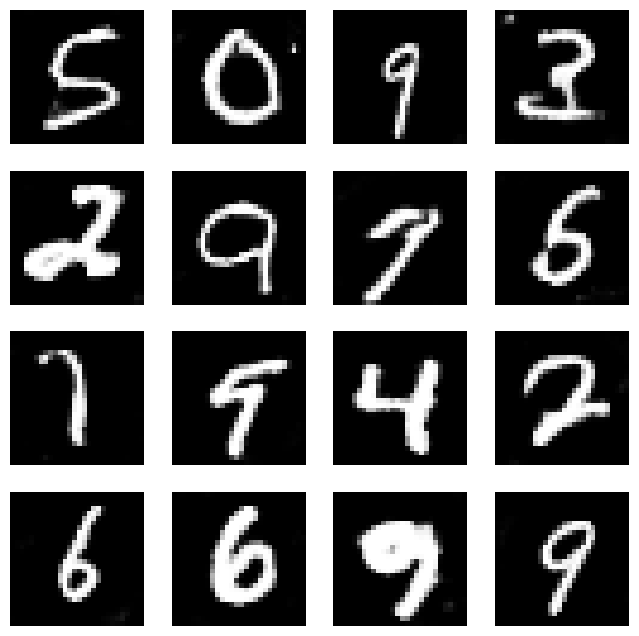

Epoch 150/185 (80.5%): [0/50048] (0.0%) D Error: 0.5226 G Error: 1.5636


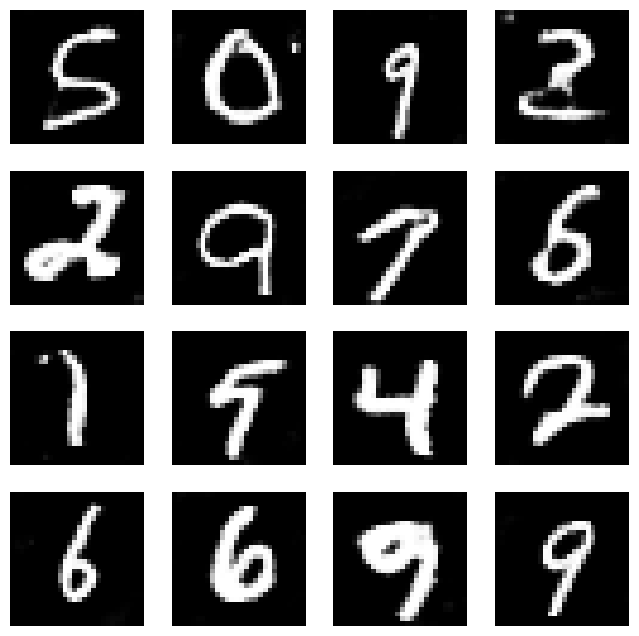

Epoch 151/185 (81.1%): [0/50048] (0.0%) D Error: 1.3186 G Error: 0.8310


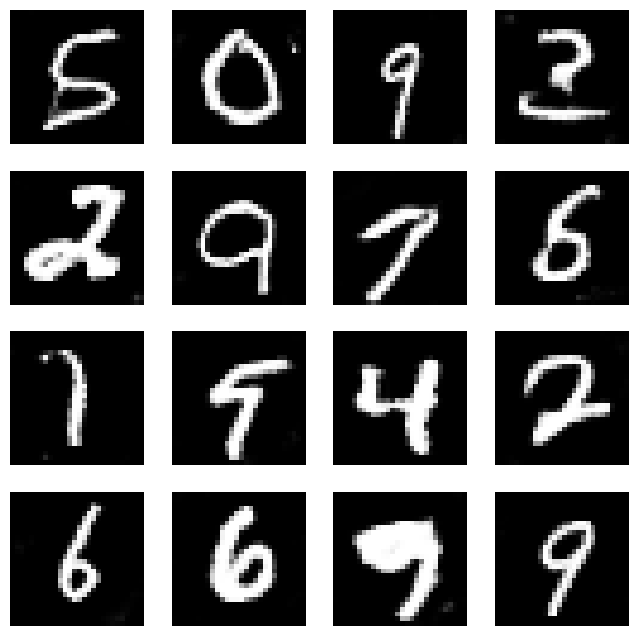

Epoch 152/185 (81.6%): [0/50048] (0.0%) D Error: 0.3245 G Error: 1.5258


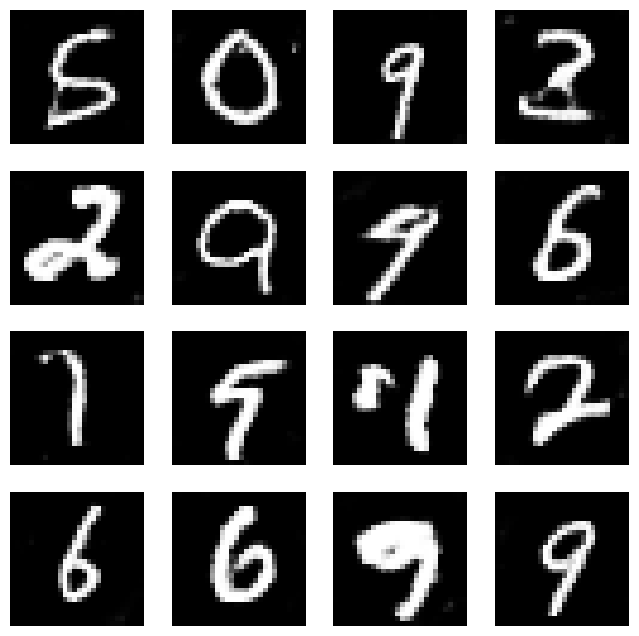

Epoch 153/185 (82.2%): [0/50048] (0.0%) D Error: 0.5966 G Error: 1.9022


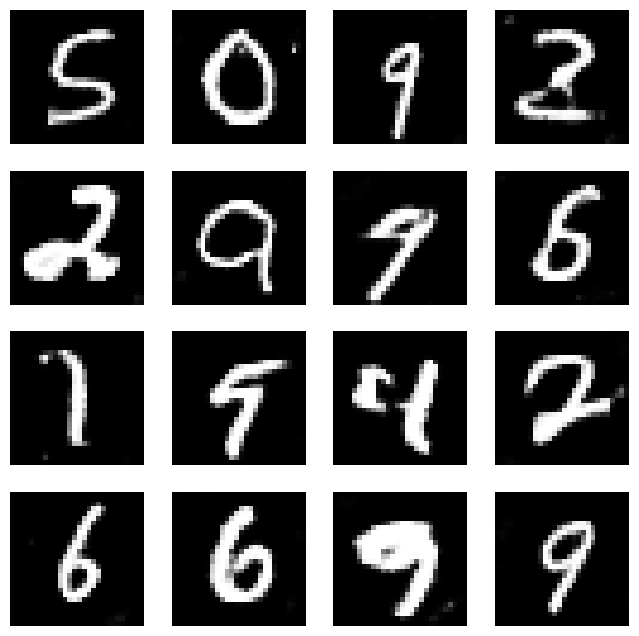

Epoch 154/185 (82.7%): [0/50048] (0.0%) D Error: 0.6773 G Error: 0.9509


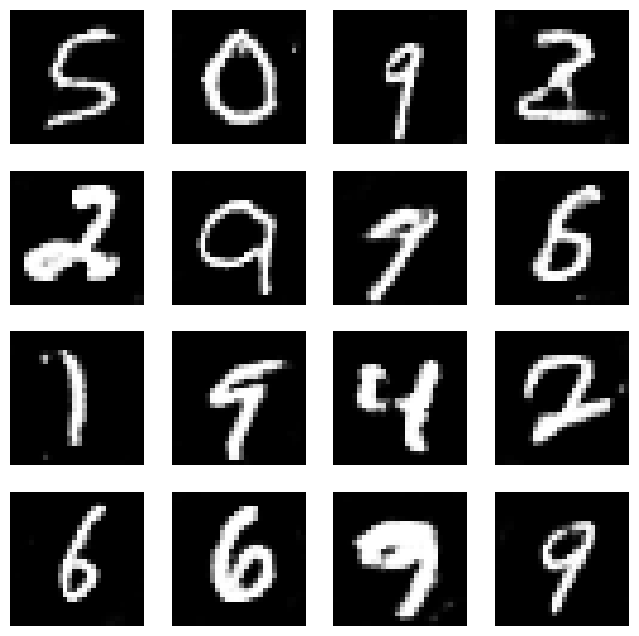

Epoch 155/185 (83.2%): [0/50048] (0.0%) D Error: 0.9635 G Error: 0.5842


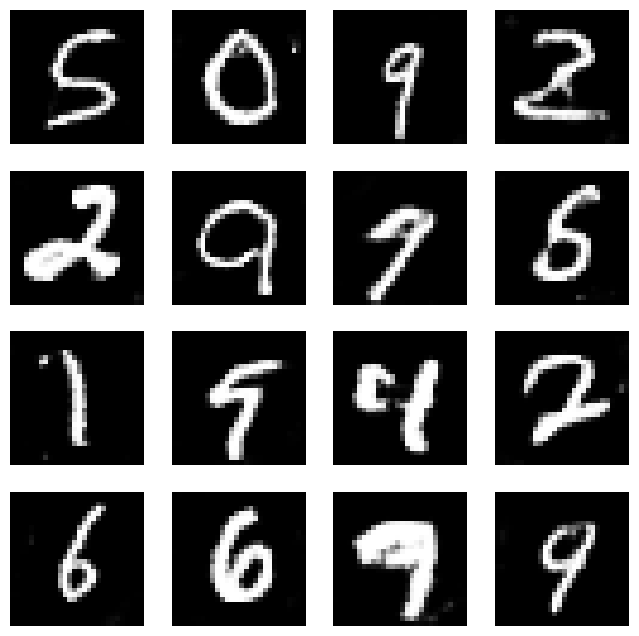

Epoch 156/185 (83.8%): [0/50048] (0.0%) D Error: 0.9946 G Error: 1.1419


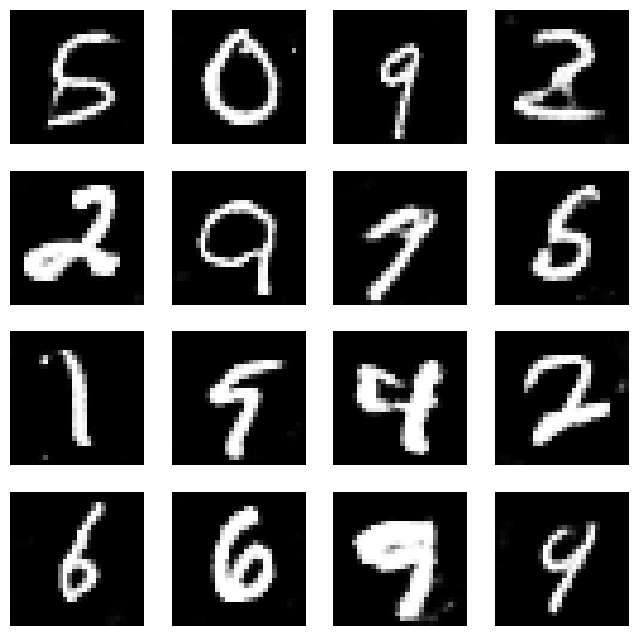

Epoch 157/185 (84.3%): [0/50048] (0.0%) D Error: 0.4147 G Error: 1.7722


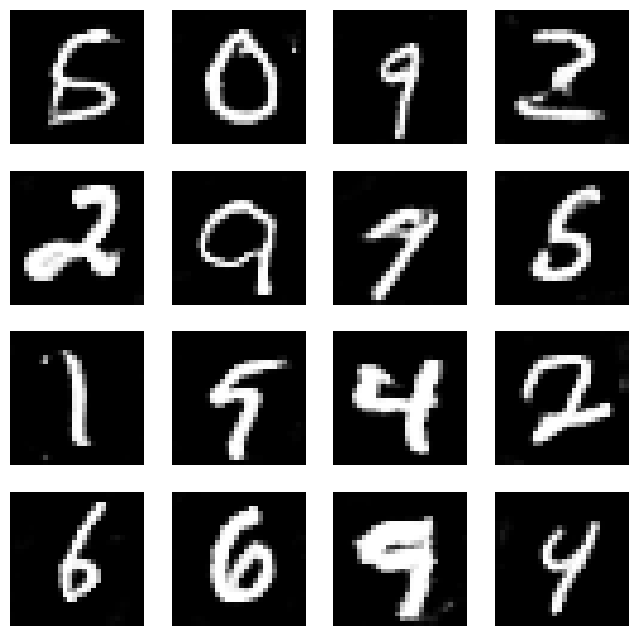

Epoch 158/185 (84.9%): [0/50048] (0.0%) D Error: 0.1685 G Error: 1.9364


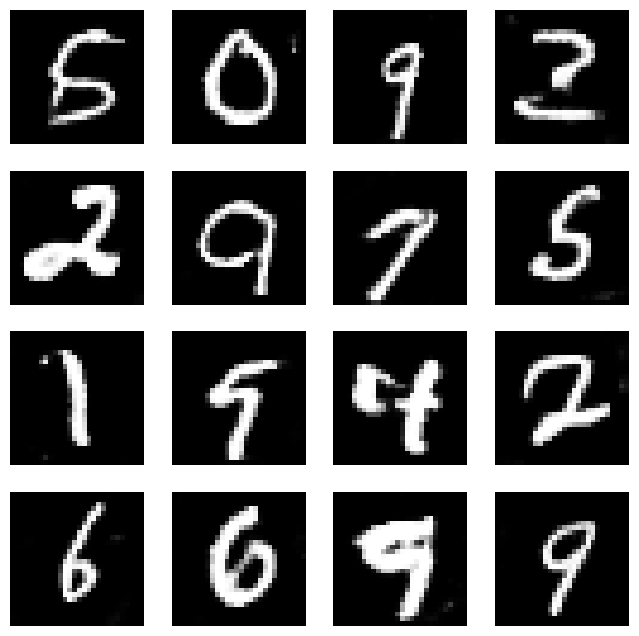

Epoch 159/185 (85.4%): [0/50048] (0.0%) D Error: 0.7106 G Error: 1.1394


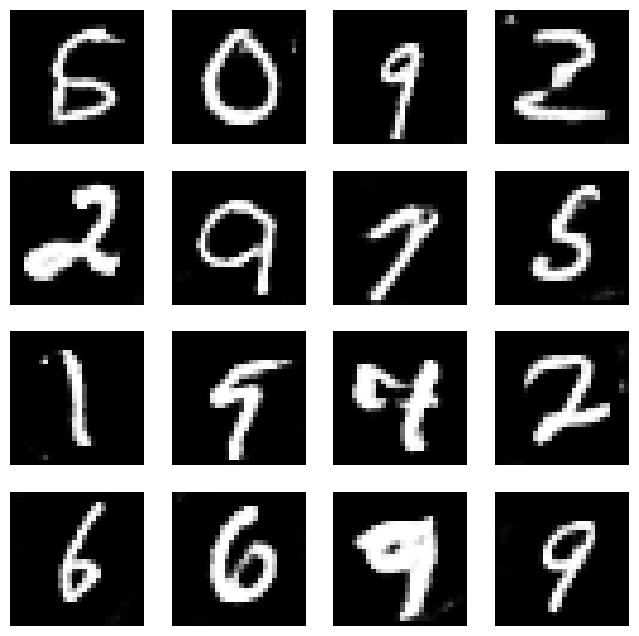

Epoch 160/185 (85.9%): [0/50048] (0.0%) D Error: 0.9603 G Error: 1.5739


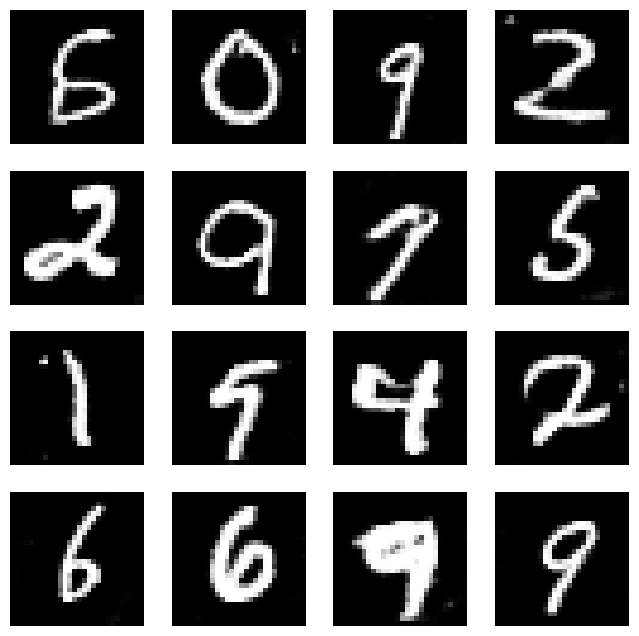

Epoch 161/185 (86.5%): [0/50048] (0.0%) D Error: 0.4838 G Error: 2.6303


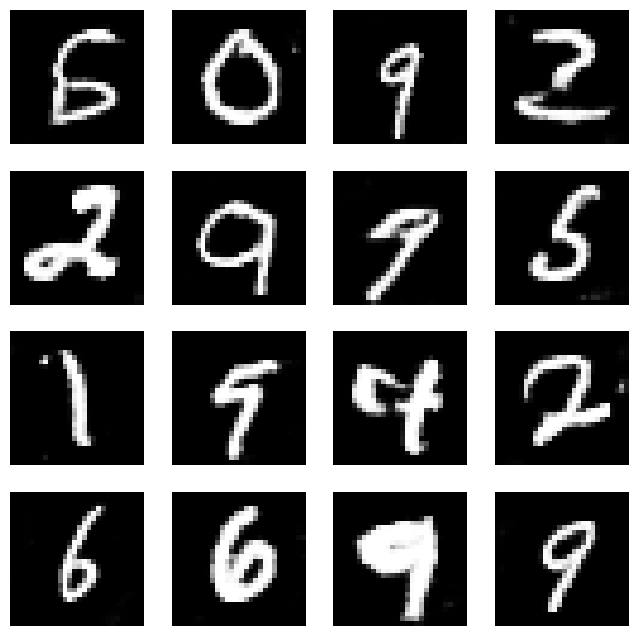

Epoch 162/185 (87.0%): [0/50048] (0.0%) D Error: 0.3660 G Error: 1.4312


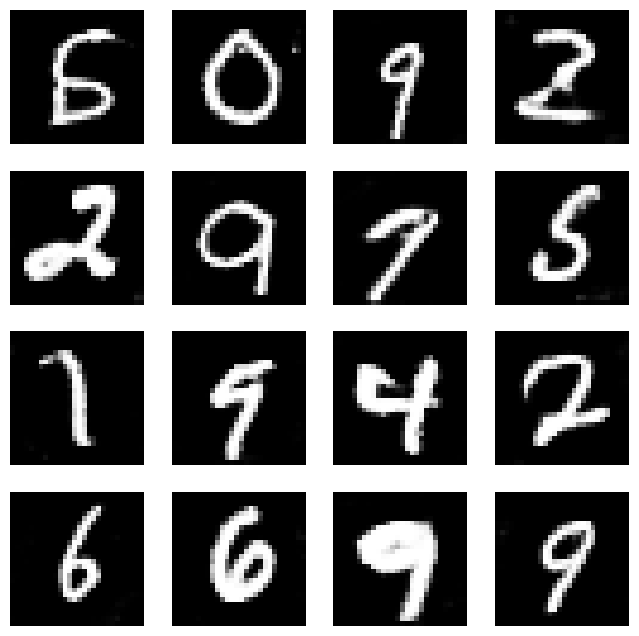

Epoch 163/185 (87.6%): [0/50048] (0.0%) D Error: 0.9543 G Error: 1.0390


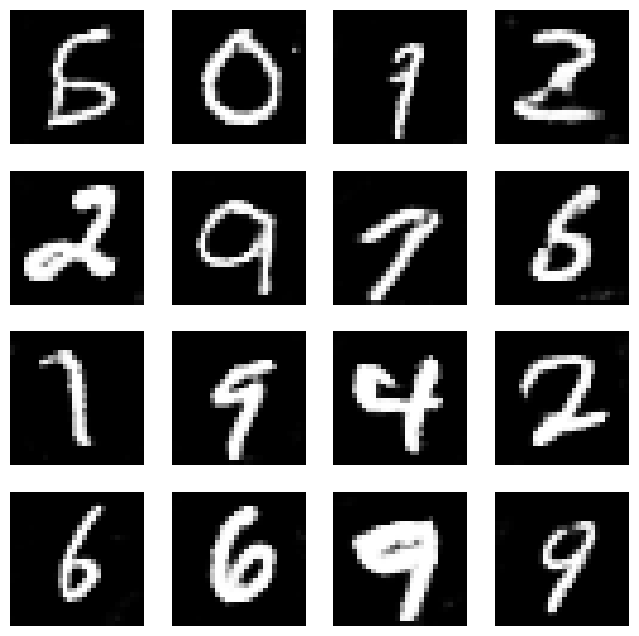

Epoch 164/185 (88.1%): [0/50048] (0.0%) D Error: 0.9231 G Error: 2.2177


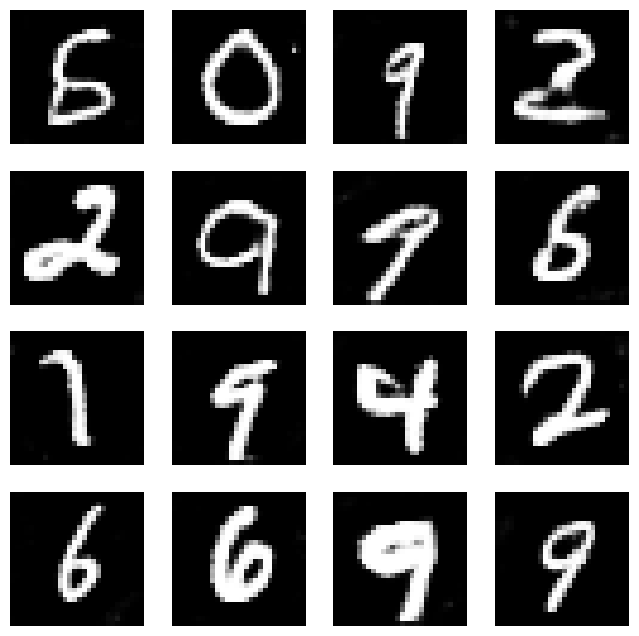

Epoch 165/185 (88.6%): [0/50048] (0.0%) D Error: 0.5134 G Error: 0.9942


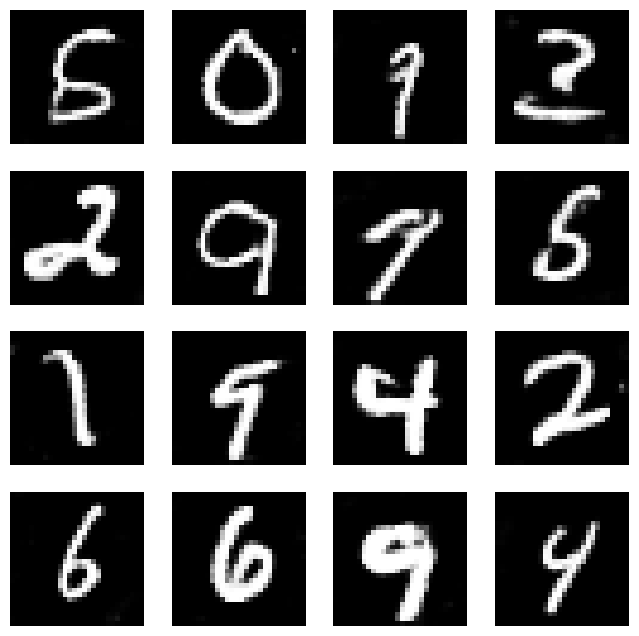

Epoch 166/185 (89.2%): [0/50048] (0.0%) D Error: 0.6093 G Error: 1.0055


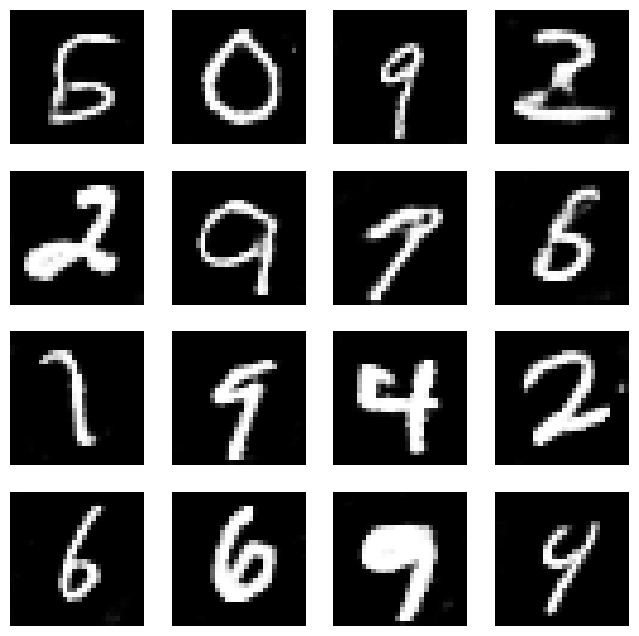

Epoch 167/185 (89.7%): [0/50048] (0.0%) D Error: 0.1421 G Error: 2.7178


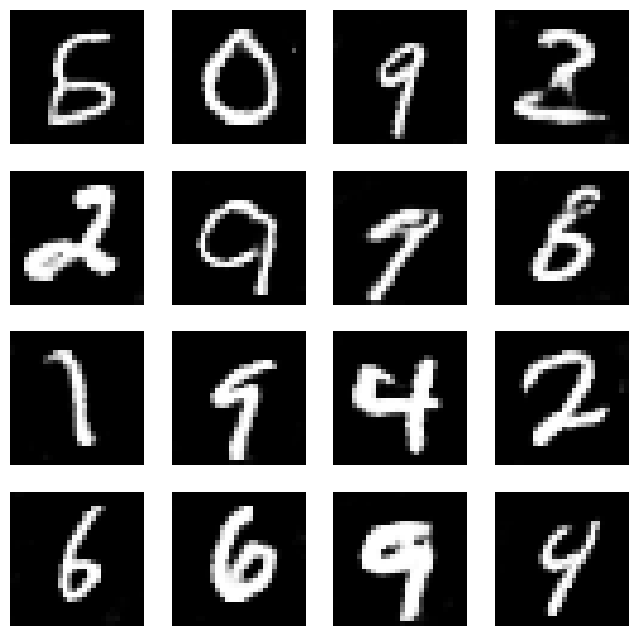

Epoch 168/185 (90.3%): [0/50048] (0.0%) D Error: 0.3478 G Error: 2.0908


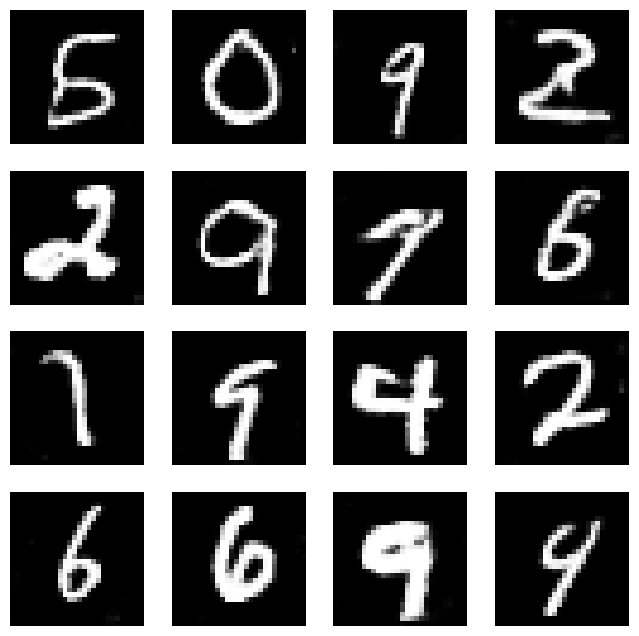

Epoch 169/185 (90.8%): [0/50048] (0.0%) D Error: 0.2457 G Error: 3.1660


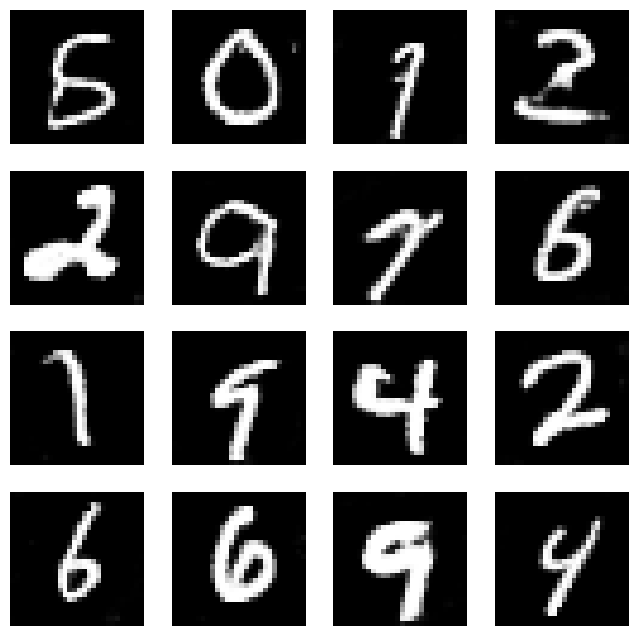

Epoch 170/185 (91.4%): [0/50048] (0.0%) D Error: 0.6178 G Error: 2.4639


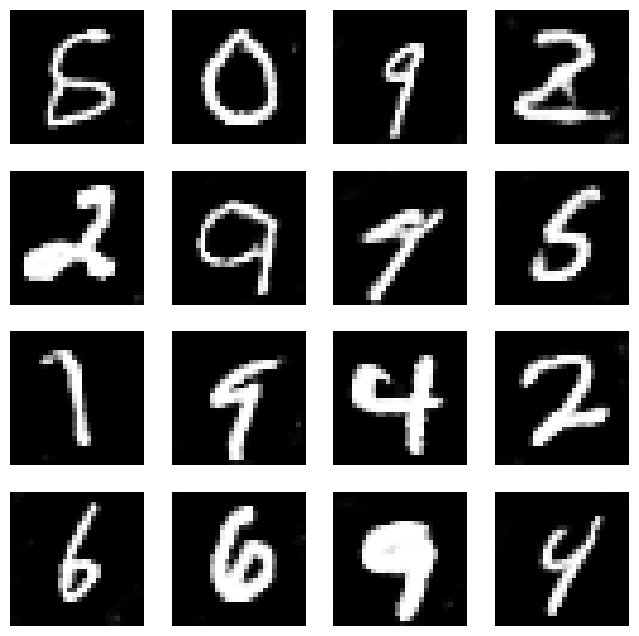

Epoch 171/185 (91.9%): [0/50048] (0.0%) D Error: 0.4830 G Error: 1.3379


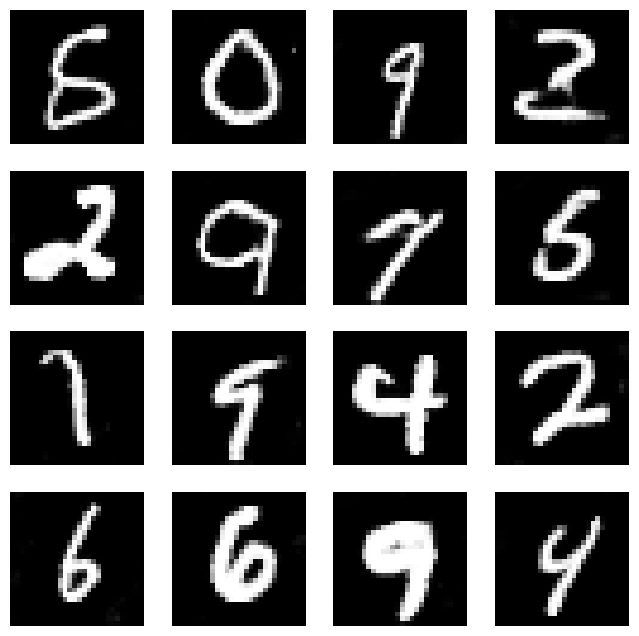

Epoch 172/185 (92.4%): [0/50048] (0.0%) D Error: 0.7168 G Error: 2.0494


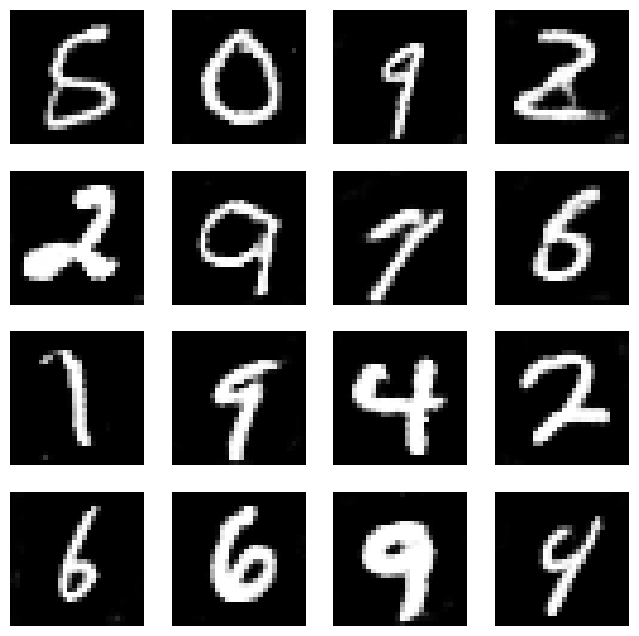

Epoch 173/185 (93.0%): [0/50048] (0.0%) D Error: 0.3428 G Error: 3.0691


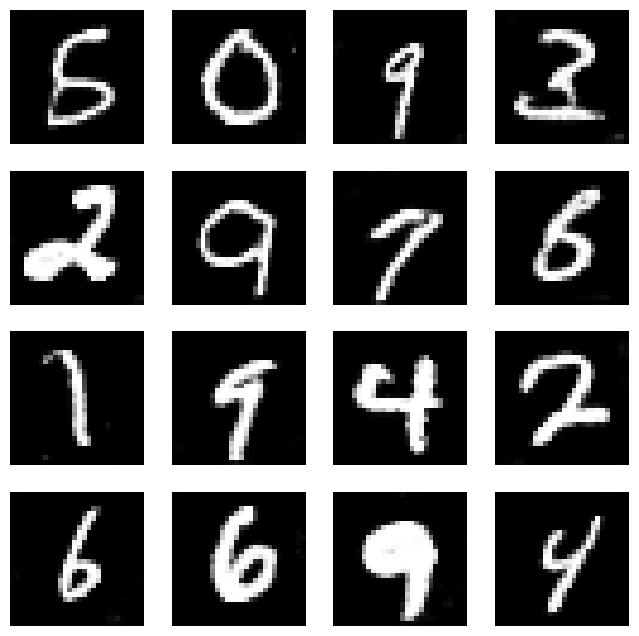

Epoch 174/185 (93.5%): [0/50048] (0.0%) D Error: 0.9336 G Error: 1.8687


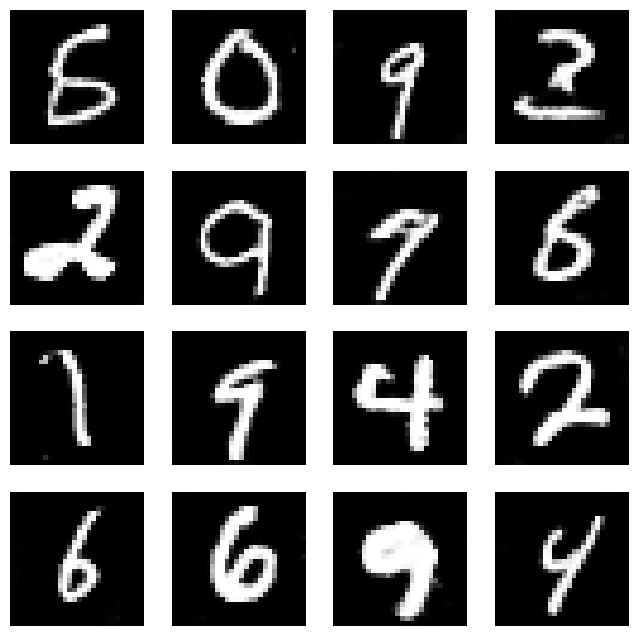

Epoch 175/185 (94.1%): [0/50048] (0.0%) D Error: 0.5102 G Error: 1.1977


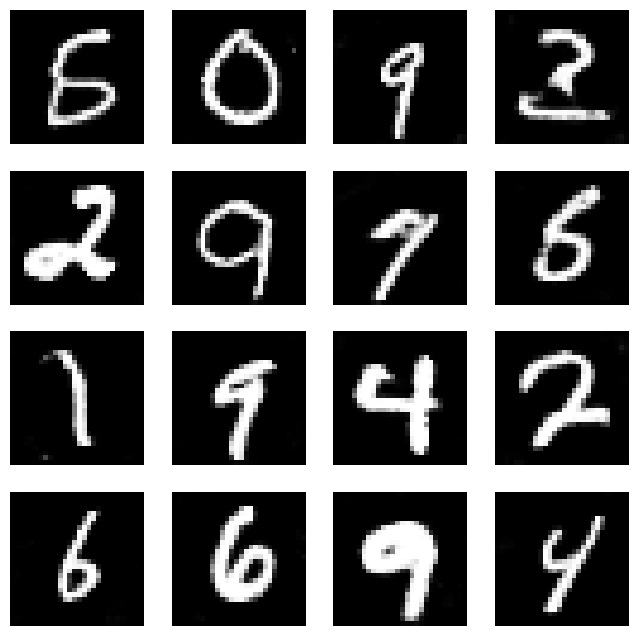

Epoch 176/185 (94.6%): [0/50048] (0.0%) D Error: 0.8996 G Error: 2.9389


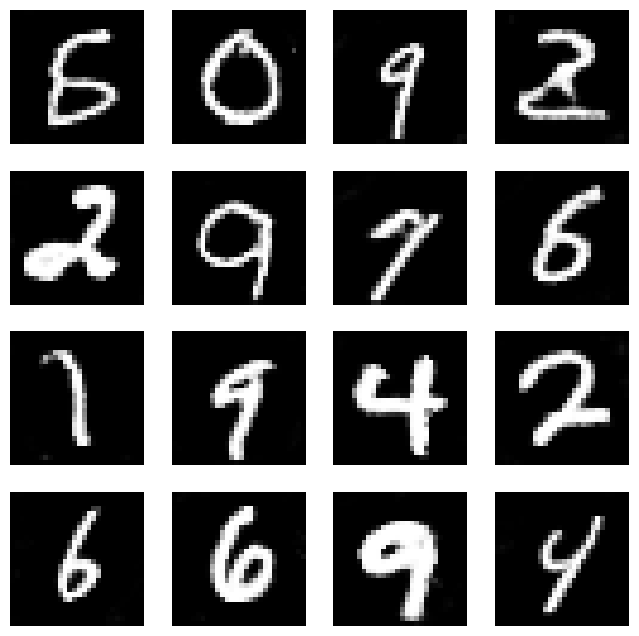

Epoch 177/185 (95.1%): [0/50048] (0.0%) D Error: 0.2639 G Error: 3.0171


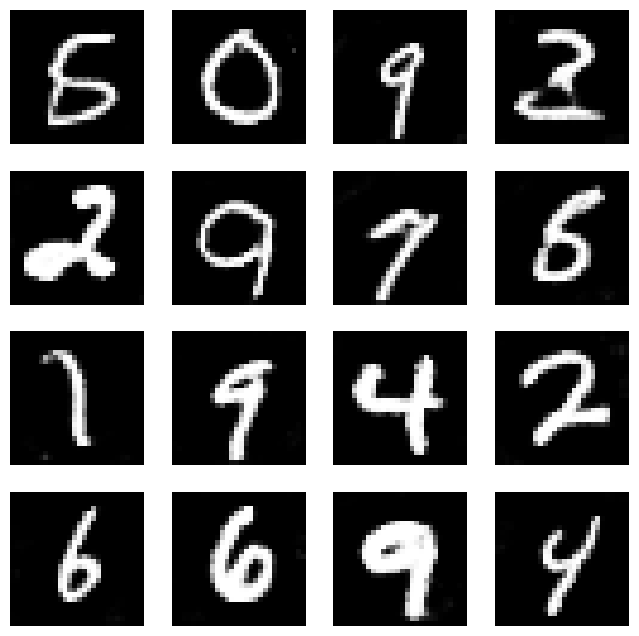

Epoch 178/185 (95.7%): [0/50048] (0.0%) D Error: 0.4578 G Error: 2.9646


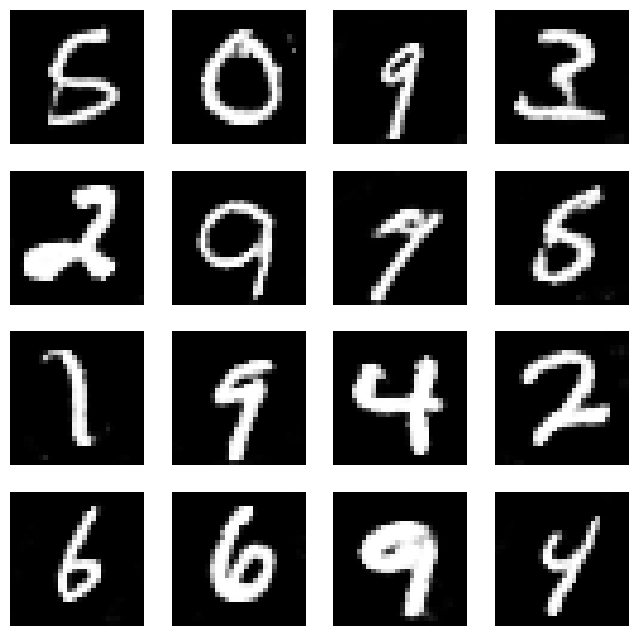

Epoch 179/185 (96.2%): [0/50048] (0.0%) D Error: 0.6200 G Error: 3.8360


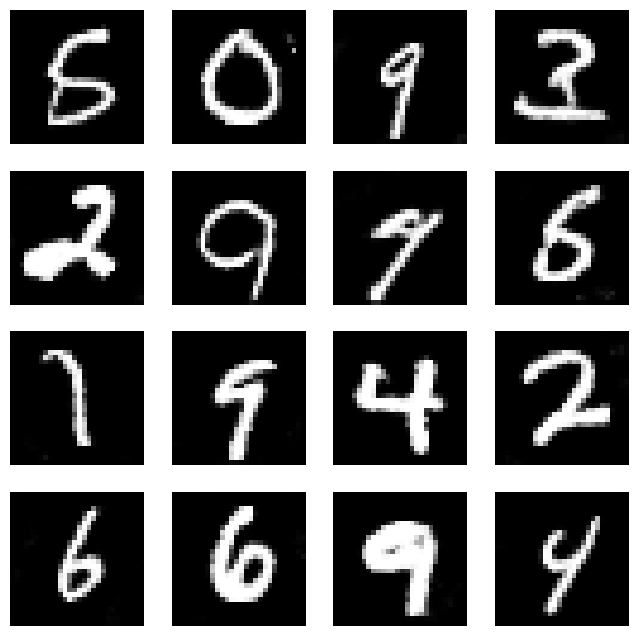

Epoch 180/185 (96.8%): [0/50048] (0.0%) D Error: 0.6128 G Error: 1.5318


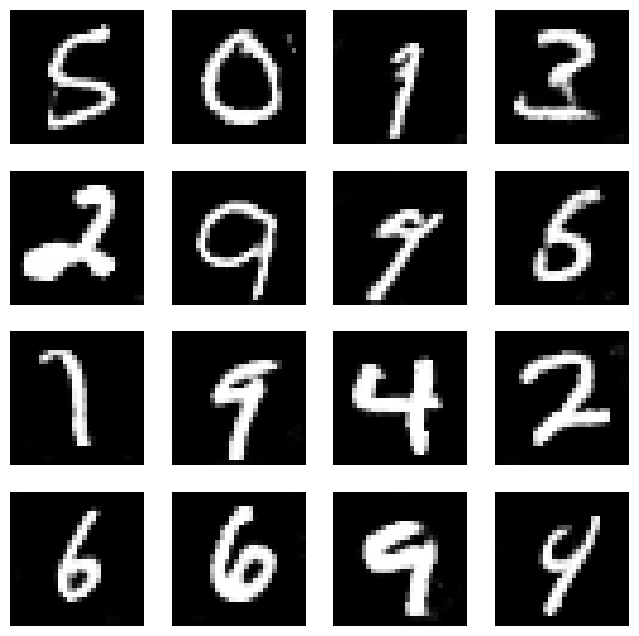

Epoch 181/185 (97.3%): [0/50048] (0.0%) D Error: 0.2712 G Error: 1.3832


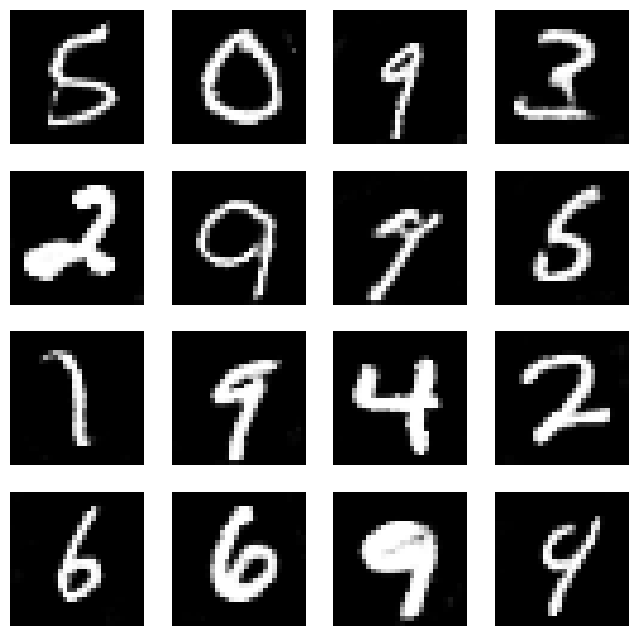

Epoch 182/185 (97.8%): [0/50048] (0.0%) D Error: 0.5511 G Error: 1.5839


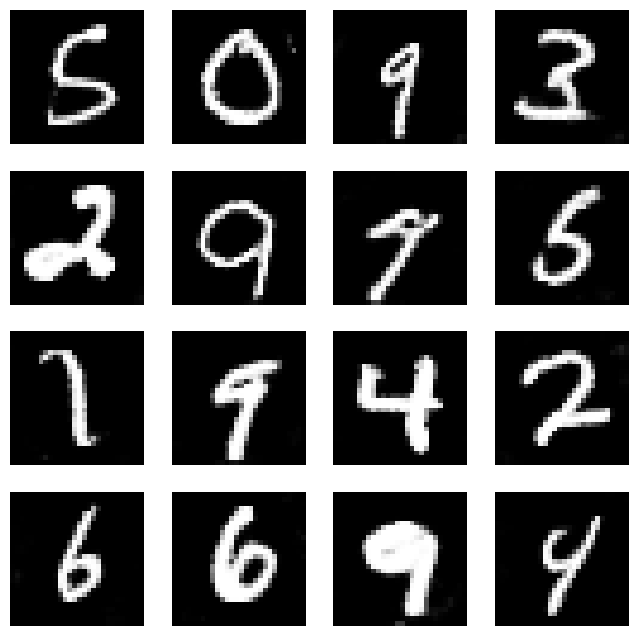

Epoch 183/185 (98.4%): [0/50048] (0.0%) D Error: 0.9292 G Error: 2.4118


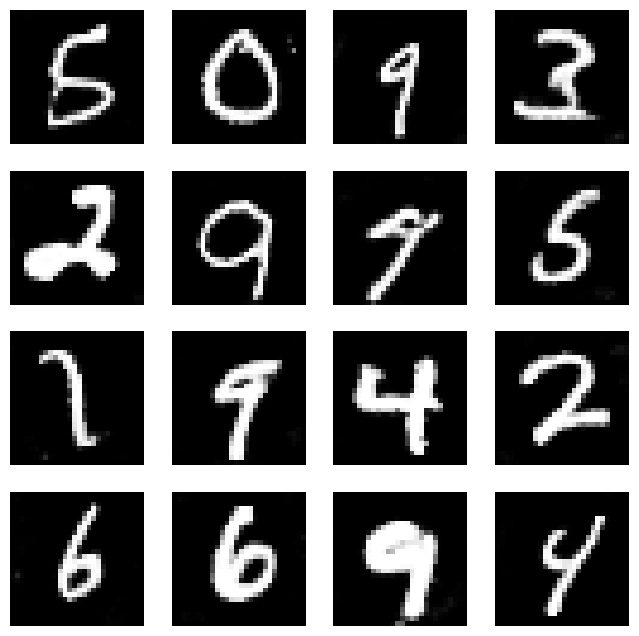

Epoch 184/185 (98.9%): [0/50048] (0.0%) D Error: 0.4919 G Error: 1.4455


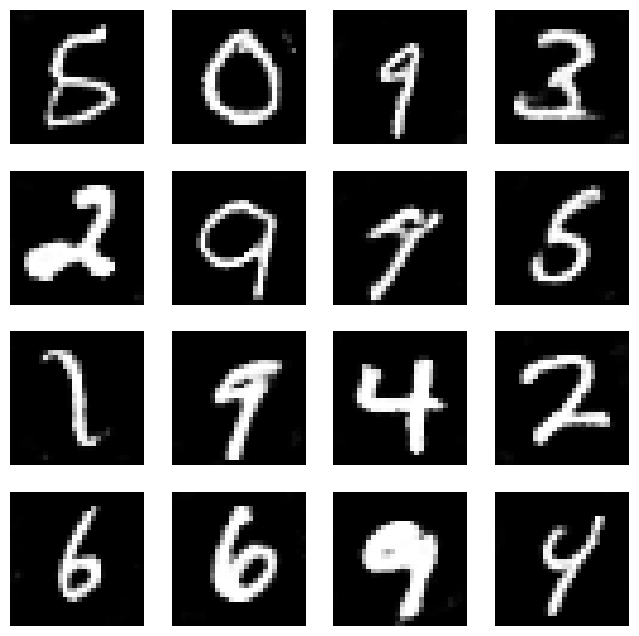

Epoch 185/185 (99.5%): [0/50048] (0.0%) D Error: 1.3632 G Error: 3.4091


In [26]:
generator, discriminator = train_gan(train_loader, 128)

# Compare

Use validation dataset to plot and compare the results of your trained models.

In [13]:
def display_images1(imgs):
    fig, axs = plt.subplots(nrows=4, ncols=10, figsize=(18,6))
    count = 0
    for y in range(4):
        for x in range(10):
            img = imgs[count]
            axs[y][x].imshow(img, cmap="gray")
            axs[y][x].axis('off')
            count += 1
    fig.suptitle('Reconstruction by VAE')
    plt.show()

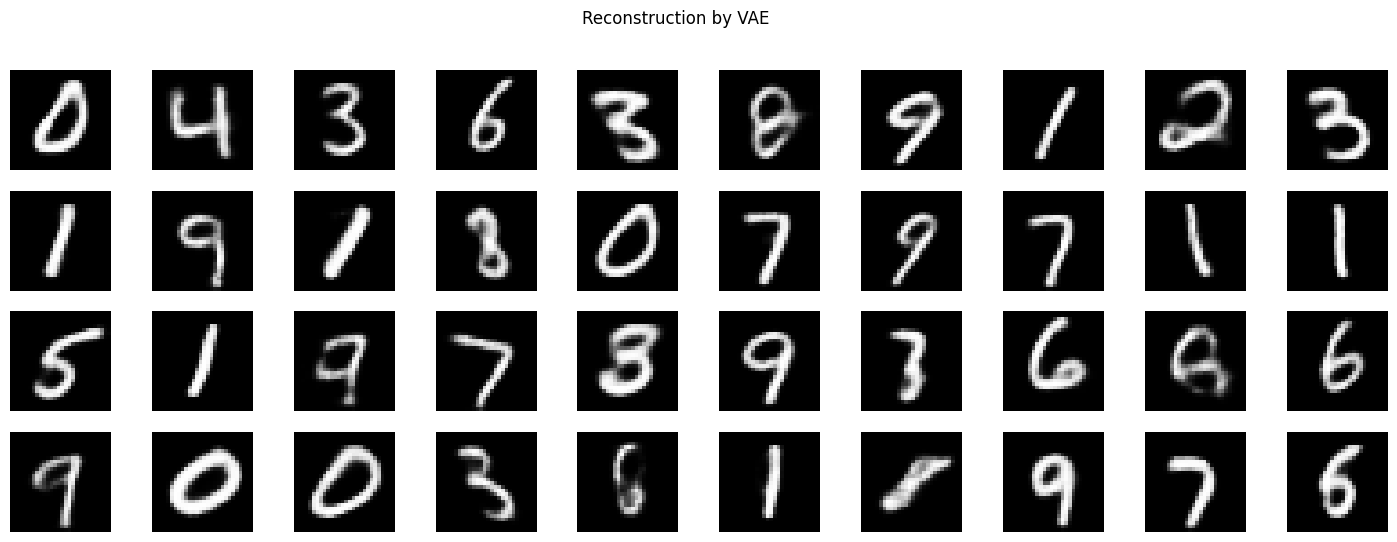

In [14]:
model_vae.eval()
images_vae = []
for i in range(40):
    a, t = next(iter(val_loader))
    a = a.to('cuda') 

    recon, mu, std = model_vae(a[:1])

    b = recon.squeeze().detach().cpu().numpy()
    images_vae.append(b)

display_images1(images_vae)

In [28]:
def display_images2(imgs):
    fig, axs = plt.subplots(nrows=4, ncols=10, figsize=(18,6))
    count = 0
    for y in range(4):
        for x in range(10):
            img = imgs[count].view(28, 28)
            axs[y][x].axis('off')
            axs[y][x].imshow(img, cmap="gray")
            count += 1
    fig.suptitle('Reconstruction by GAN')
    plt.show()

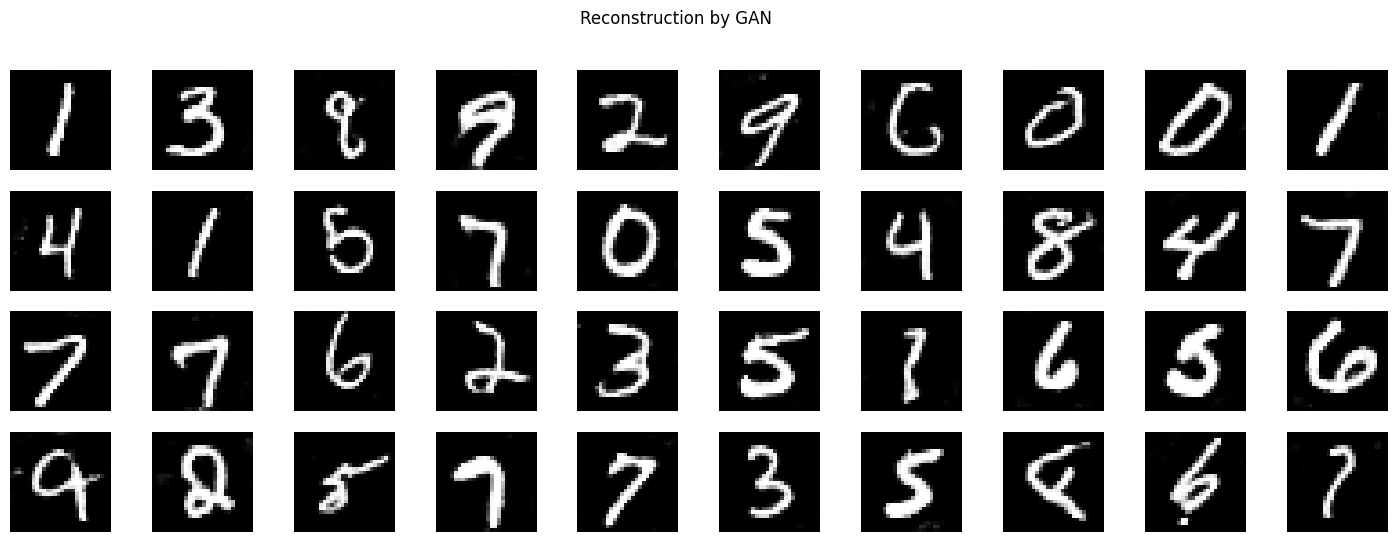

In [33]:
test_images = vec_to_imgs(generator(noise(40).to(device).to(device))).data.cpu()
display_images2(test_images)

also you can see the loss of both models in their sections

##### RESOURCES

-   https://www.kaggle.com/code/sinclairg/pytorch-gan-generating-mnist-digits -> for training part of the GAN model
-   https://github.com/williamcfrancis/Variational-Autoencoder-for-MNIST/blob/main/VAE_Digit_Recognition.ipynb -> for training part of the VAE model

###### The architecture of both models was designed by myself 